In [ ]:
from pathlib import Path
import os
from lightglue import LightGlue, SuperPoint, DISK, SIFT, ALIKED, DoGHardNet
from lightglue.utils import load_image, rbd
from lightglue import viz2d
import pandas as pd
import cv2
import matplotlib.pyplot as plt
import torch
from lightglue import match_pair
from itertools import combinations
import h5py
import numpy as np
import re
import subprocess
import pycolmap
from database import COLMAPDatabase
from h5_to_db import add_keypoints, add_matches
from tqdm import tqdm
import kornia.feature as KF
import open3d as o3d

In [3]:
def read_csv(path): 
    file_path = os.path.join(os.getcwd(),"image-matching-challenge-2025", path)
    return pd.read_csv(file_path)

In [5]:
def open_image(img_paths, scenes, n_cols=7, figsize=(15, 8)): 
    n_rows = len(img_paths) // 7 + 1
    fig, axes = plt.subplots(n_rows, n_cols, figsize=figsize)
    axes = axes.flatten()
    
    for i, img_path in enumerate(img_paths):
        #In case we have more images than subplots
        if i >= len(axes): 
            break
        img = cv2.imread(img_path)
        if img is None: 
            axes[i].set_title("No Image found")
            axes[i].axis("off")
            continue
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        axes[i].imshow(img_rgb)
        axes[i].axis("off")
        axes[i].set_title(f"{scenes[i]}")
        
    for j in range(i+1, len(axes)): 
        axes[j].axis("off")
    plt.show()

In [6]:
df = read_csv("train_labels.csv")
df["image_path"] = df.apply(lambda row: os.path.join(os.getcwd(), "image-matching-challenge-2025", "train",  row["dataset"], row["image"]), axis=1)
scene_samples = df["scene"].values[:54]
img_path_samples = df["image_path"].values[:54]

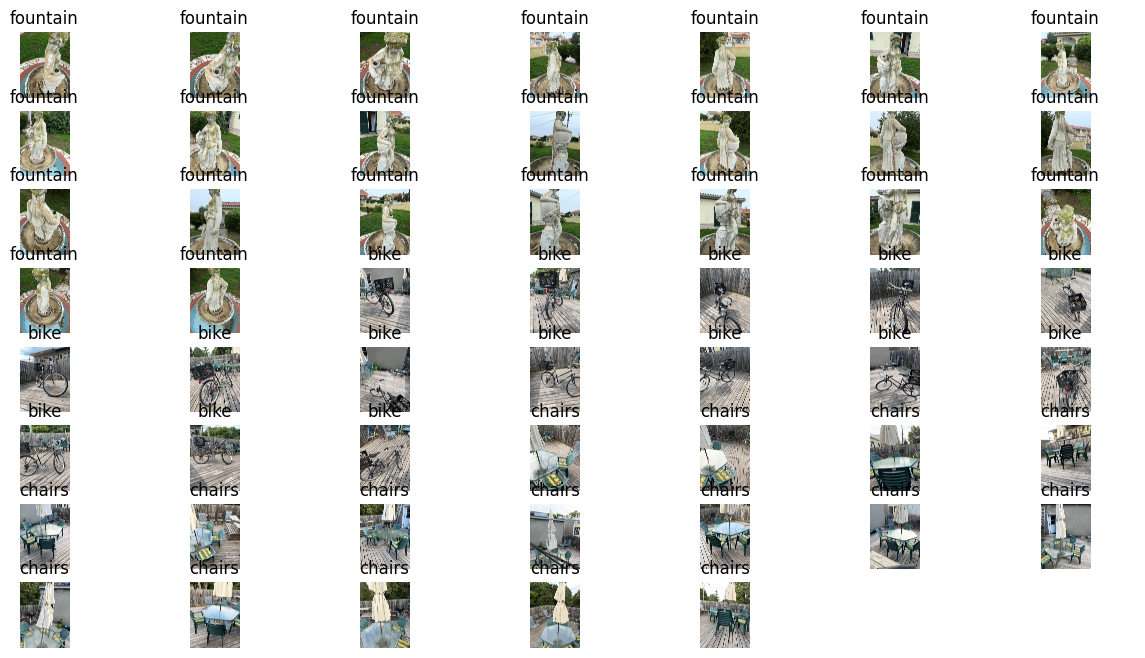

In [7]:
open_image(img_path_samples, scene_samples)

In [8]:
def get_pair_index(paths): 
    #Obtains all index pairs of small list
    return list(combinations(range(len(paths)), 2))
                   
def find_keypoints(extractor, paths, feature_dir): 
    with h5py.File(feature_dir/ "keypoints.h5", mode="w") as f_keypoints, h5py.File(feature_dir / "descriptors.h5", mode="w") as f_descriptors: 
        for path in tqdm(paths, desc="Computing and saving keypoints..."): 
            #If path is a string and not Path(..) object
            if(isinstance(path, str)): 
                path = Path(path)
            key = path.name
            
            #Using inference_mode to save memory and efficienter
            with torch.inference_mode(): 
                image = load_image(path)
                feats = extractor.extract(image)
                keypoints = feats["keypoints"]
                descriptors = feats["descriptors"]
                if not isinstance(keypoints, np.ndarray): 
                    keypoints = keypoints.squeeze().cpu().numpy()
                if not isinstance(descriptors, np.ndarray): 
                    descriptors = descriptors.squeeze().cpu().numpy() 
                f_keypoints[key] = keypoints
                f_descriptors[key] = descriptors
                

In [96]:
def compare_image(f_keypoints, f_descriptors, f_matches, device, key1_path, key2_path, matcher,  show_comparison = False, show_points=False):
    min_matches=20
    image0 = load_image(key1_path)
    image1 = load_image(key2_path)
    key1 = Path(key1_path).name
    key2 = Path(key2_path).name

    feats0 = {
        "keypoints": torch.from_numpy(f_keypoints[key1][...])[None].to(device), 
        "descriptors": torch.from_numpy(f_descriptors[key1][...])[None].to(device)
    }
    feats1 = {
        "keypoints": torch.from_numpy(f_keypoints[key2][...])[None].to(device), 
        "descriptors": torch.from_numpy(f_descriptors[key2][...])[None].to(device)
    }
    #Match the features
    matches01 = matcher({'image0': feats0, 'image1': feats1})
    feats0, feats1, matches01 = [rbd(x) for x in [feats0, feats1, matches01]]
    matches = matches01['matches'].to(device)
    #print(matches)
    points0 = feats0['keypoints'][matches[..., 0]]
    points1 = feats1['keypoints'][matches[..., 1]]
    desc0 = feats0['descriptors'][matches[..., 0]]
    desc1 = feats1['descriptors'][matches[..., 1]]
    #print(matches[..., 0])
    #print(feats0['descriptors'][0][matches[..., 0]])
    #print(matches[..., 0].max(), matches[..., 0].min())

    # Compute L2 distance between descriptors (to match matcher output style)
    descriptor_distances = torch.norm(desc0 - desc1, dim=1)
    #descriptor_distances = descriptor_distances.unsqueeze(1)  # from [N] to [N,1]
    distance = torch.norm(points0 - points1, dim=1)
    if show_comparison: 
        axes = viz2d.plot_images([image0, image1])
        viz2d.plot_matches(points0, points1, color="lime", lw=0.2)
        viz2d.add_text(0, f'Stop after {matches01["stop"]} layers', fs=20)
        kpc0, kpc1 = viz2d.cm_prune(matches01["prune0"]), viz2d.cm_prune(matches01["prune1"])
        viz2d.plot_images([image0, image1])
        viz2d.plot_keypoints([feats0["keypoints"], feats1["keypoints"]], colors=[kpc0, kpc1], ps=10)
        
    n_matches = len(matches)  
    if n_matches >= min_matches: 
        group = f_matches.require_group(key1)
        group.create_dataset(key2, data=matches.detach().cpu().numpy().reshape(-1, 2))

#Importing h5 file to colmap database
def import_into_colmap(path, feature_dir, database_path): 
    db = COLMAPDatabase.connect(database_path)
    db.create_tables()
    single_camera = False
    fname_to_id = add_keypoints(db, feature_dir, path, "", "simple-pinhole", single_camera)
    add_matches(db, 
                feature_dir, 
                fname_to_id)
    db.commit()

#Reconstruct the 3d image by finding the rotation matrix and translation vector
def reconstruct_images(output_path, database_path, images_dir):
    mapper_options = pycolmap.IncrementalPipelineOptions()
    mapper_options.min_model_size = 3
    mapper_options.max_num_models = 2
    
    maps = pycolmap.incremental_mapping(
        database_path=database_path, 
        image_path=images_dir,
        output_path=Path.cwd() / output_path, 
        options=mapper_options,
    )

    #Create
    data = []
    for model in maps.values(): 
        for image_id, image in model.images.items(): 
            rotation = image.cam_from_world.rotation.matrix().flatten().tolist()
            translation = image.cam_from_world.translation.tolist()
            row = [image.name, ";".join(str(x) for x in rotation) , ";".join(str(x) for x in translation)]
            data.append(row)
    
    columns = (['image_name'] + ['rotation_matrix'] + ['translation_vector'])
    
    #Save to CSV
    df = pd.DataFrame(data, columns=columns)
    file_name = 'camera_poses.csv'
    df.to_csv(file_name, index=False)
    
    print(f'Camera poses saved to {file_name}')

In [97]:
#To 3d visualize the reconstructed image
def visualize_reconstructed(reconstruct_path):  
    recon = pycolmap.Reconstruction(reconstruct_path)
    points = [point.xyz for point in recon.points3D.values()]
    pcd = o3d.geometry.PointCloud()
    pcd.points = o3d.utility.Vector3dVector(points)
    o3d.visualization.draw_geometries([pcd])

Running everything together

In [9]:
#Load the extractor and matcher
extractor = ALIKED(max_num_keypoints=2048, resize = 1024).eval()

#To create dataset keypoints.h5 and descriptors.h5
find_keypoints(extractor, img_path_samples , feature_dir)

path_pair_index = get_pair_index(img_path_samples)
feature_dir = Path(os.path.join(os.getcwd() , "feature_extraction"))

#Load the LightGlue Matcher
matcher = LightGlue(features="aliked", depth_confidence=1.0, width_confidence=1.0).eval().to(device)

#Delete old "matches.h5"
file_path = os.path.join(feature_dir, "matches.h5")
if os.path.exists(file_path): 
    os.remove(file_path)
print("File deleted")

In [18]:
#Device Type: "cuda" or "cpu"
device = "cuda"

#Create dataset "matches.h5" that matches another photo
with h5py.File(feature_dir / "keypoints.h5", mode="r") as f_keypoints, h5py.File(feature_dir / "descriptors.h5", mode="r") as f_descriptors, h5py.File(feature_dir/"matches.h5", mode="a") as f_matches: 
    for i1, i2 in tqdm(path_pair_index, desc="Computing keypoint distances"):
        key1, key2 = Path(img_path_samples[i1]), Path(img_path_samples[i2])
#        compare_image(f_keypoints, f_descriptors, f_matches, device, key1, key2, matcher, False)

Computing keypoint distances:   0%|                                                   | 1/1431 [00:00<23:40,  1.01it/s]

Matching fountain_image_116.png with fountain_image_108.png: 292 Matches


Computing keypoint distances:   0%|                                                   | 2/1431 [00:01<20:18,  1.17it/s]

Matching fountain_image_116.png with fountain_image_101.png: 42 Matches


Computing keypoint distances:   0%|                                                   | 3/1431 [00:02<19:32,  1.22it/s]

Matching fountain_image_116.png with fountain_image_082.png: 46 Matches


Computing keypoint distances:   0%|▏                                                  | 4/1431 [00:03<19:14,  1.24it/s]

Matching fountain_image_116.png with fountain_image_071.png: 60 Matches


Computing keypoint distances:   0%|▏                                                  | 5/1431 [00:04<19:08,  1.24it/s]

Matching fountain_image_116.png with fountain_image_025.png: 167 Matches


Computing keypoint distances:   0%|▏                                                  | 6/1431 [00:04<19:06,  1.24it/s]

Matching fountain_image_116.png with fountain_image_000.png: 83 Matches


Computing keypoint distances:   0%|▏                                                  | 7/1431 [00:05<18:50,  1.26it/s]

Matching fountain_image_116.png with fountain_image_007.png: 27 Matches


Computing keypoint distances:   1%|▎                                                  | 8/1431 [00:06<18:50,  1.26it/s]

Matching fountain_image_116.png with fountain_image_012.png: 94 Matches


Computing keypoint distances:   1%|▎                                                  | 9/1431 [00:07<18:49,  1.26it/s]

Matching fountain_image_116.png with fountain_image_033.png: 463 Matches


Computing keypoint distances:   1%|▎                                                 | 10/1431 [00:08<18:23,  1.29it/s]

Matching fountain_image_116.png with fountain_image_173.png: 376 Matches


Computing keypoint distances:   1%|▍                                                 | 11/1431 [00:08<18:47,  1.26it/s]

Matching fountain_image_116.png with fountain_image_056.png: 260 Matches


Computing keypoint distances:   1%|▍                                                 | 12/1431 [00:09<19:42,  1.20it/s]

Matching fountain_image_116.png with fountain_image_186.png: 26 Matches


Computing keypoint distances:   1%|▍                                                 | 13/1431 [00:10<21:12,  1.11it/s]

Matching fountain_image_116.png with fountain_image_199.png: 16 Matches


Computing keypoint distances:   1%|▍                                                 | 14/1431 [00:11<20:29,  1.15it/s]

Matching fountain_image_116.png with fountain_image_230.png: 156 Matches


Computing keypoint distances:   1%|▌                                                 | 15/1431 [00:12<20:17,  1.16it/s]

Matching fountain_image_116.png with fountain_image_214.png: 31 Matches


Computing keypoint distances:   1%|▌                                                 | 16/1431 [00:13<19:36,  1.20it/s]

Matching fountain_image_116.png with fountain_image_041.png: 858 Matches


Computing keypoint distances:   1%|▌                                                 | 17/1431 [00:13<19:06,  1.23it/s]

Matching fountain_image_116.png with fountain_image_166.png: 184 Matches


Computing keypoint distances:   1%|▋                                                 | 18/1431 [00:14<18:49,  1.25it/s]

Matching fountain_image_116.png with fountain_image_163.png: 69 Matches


Computing keypoint distances:   1%|▋                                                 | 19/1431 [00:15<18:24,  1.28it/s]

Matching fountain_image_116.png with fountain_image_155.png: 17 Matches


Computing keypoint distances:   1%|▋                                                 | 20/1431 [00:16<18:17,  1.29it/s]

Matching fountain_image_116.png with fountain_image_143.png: 107 Matches


Computing keypoint distances:   1%|▋                                                 | 21/1431 [00:17<18:14,  1.29it/s]

Matching fountain_image_116.png with fountain_image_136.png: 22 Matches


Computing keypoint distances:   2%|▊                                                 | 22/1431 [00:17<18:15,  1.29it/s]

Matching fountain_image_116.png with fountain_image_129.png: 81 Matches


Computing keypoint distances:   2%|▊                                                 | 23/1431 [00:18<18:15,  1.28it/s]

Matching fountain_image_116.png with bike_image_119.png: 57 Matches


Computing keypoint distances:   2%|▊                                                 | 24/1431 [00:19<18:32,  1.27it/s]

Matching fountain_image_116.png with bike_image_115.png: 16 Matches


Computing keypoint distances:   2%|▊                                                 | 25/1431 [00:20<18:22,  1.28it/s]

Matching fountain_image_116.png with bike_image_038.png: 6 Matches


Computing keypoint distances:   2%|▉                                                 | 26/1431 [00:20<18:17,  1.28it/s]

Matching fountain_image_116.png with bike_image_049.png: 5 Matches


Computing keypoint distances:   2%|▉                                                 | 27/1431 [00:21<18:15,  1.28it/s]

Matching fountain_image_116.png with bike_image_139.png: 11 Matches


Computing keypoint distances:   2%|▉                                                 | 28/1431 [00:22<18:09,  1.29it/s]

Matching fountain_image_116.png with bike_image_029.png: 25 Matches


Computing keypoint distances:   2%|█                                                 | 29/1431 [00:23<18:10,  1.29it/s]

Matching fountain_image_116.png with bike_image_150.png: 10 Matches


Computing keypoint distances:   2%|█                                                 | 30/1431 [00:24<18:17,  1.28it/s]

Matching fountain_image_116.png with bike_image_137.png: 9 Matches


Computing keypoint distances:   2%|█                                                 | 31/1431 [00:24<18:26,  1.27it/s]

Matching fountain_image_116.png with bike_image_004.png: 24 Matches


Computing keypoint distances:   2%|█                                                 | 32/1431 [00:25<18:14,  1.28it/s]

Matching fountain_image_116.png with bike_image_128.png: 26 Matches


Computing keypoint distances:   2%|█▏                                                | 33/1431 [00:26<18:10,  1.28it/s]

Matching fountain_image_116.png with bike_image_062.png: 15 Matches


Computing keypoint distances:   2%|█▏                                                | 34/1431 [00:27<18:09,  1.28it/s]

Matching fountain_image_116.png with bike_image_076.png: 16 Matches


Computing keypoint distances:   2%|█▏                                                | 35/1431 [00:28<18:21,  1.27it/s]

Matching fountain_image_116.png with bike_image_088.png: 24 Matches


Computing keypoint distances:   3%|█▎                                                | 36/1431 [00:28<18:23,  1.26it/s]

Matching fountain_image_116.png with bike_image_094.png: 31 Matches


Computing keypoint distances:   3%|█▎                                                | 37/1431 [00:29<18:23,  1.26it/s]

Matching fountain_image_116.png with bike_image_101.png: 11 Matches


Computing keypoint distances:   3%|█▎                                                | 38/1431 [00:30<18:23,  1.26it/s]

Matching fountain_image_116.png with chairs_image_122.png: 24 Matches


Computing keypoint distances:   3%|█▎                                                | 39/1431 [00:31<18:16,  1.27it/s]

Matching fountain_image_116.png with chairs_image_115.png: 15 Matches


Computing keypoint distances:   3%|█▍                                                | 40/1431 [00:31<18:12,  1.27it/s]

Matching fountain_image_116.png with chairs_image_103.png: 41 Matches


Computing keypoint distances:   3%|█▍                                                | 41/1431 [00:32<18:15,  1.27it/s]

Matching fountain_image_116.png with chairs_image_094.png: 17 Matches


Computing keypoint distances:   3%|█▍                                                | 42/1431 [00:33<18:33,  1.25it/s]

Matching fountain_image_116.png with chairs_image_051.png: 4 Matches


Computing keypoint distances:   3%|█▌                                                | 43/1431 [00:34<18:45,  1.23it/s]

Matching fountain_image_116.png with chairs_image_131.png: 30 Matches


Computing keypoint distances:   3%|█▌                                                | 44/1431 [00:35<18:36,  1.24it/s]

Matching fountain_image_116.png with chairs_image_004.png: 9 Matches


Computing keypoint distances:   3%|█▌                                                | 45/1431 [00:35<18:23,  1.26it/s]

Matching fountain_image_116.png with chairs_image_160.png: 21 Matches


Computing keypoint distances:   3%|█▌                                                | 46/1431 [00:36<18:17,  1.26it/s]

Matching fountain_image_116.png with chairs_image_035.png: 31 Matches


Computing keypoint distances:   3%|█▋                                                | 47/1431 [00:37<18:35,  1.24it/s]

Matching fountain_image_116.png with chairs_image_045.png: 53 Matches


Computing keypoint distances:   3%|█▋                                                | 48/1431 [00:38<19:02,  1.21it/s]

Matching fountain_image_116.png with chairs_image_155.png: 28 Matches


Computing keypoint distances:   3%|█▋                                                | 49/1431 [00:39<18:35,  1.24it/s]

Matching fountain_image_116.png with chairs_image_152.png: 10 Matches


Computing keypoint distances:   3%|█▋                                                | 50/1431 [00:40<18:44,  1.23it/s]

Matching fountain_image_116.png with chairs_image_020.png: 21 Matches


Computing keypoint distances:   4%|█▊                                                | 51/1431 [00:40<19:07,  1.20it/s]

Matching fountain_image_116.png with chairs_image_144.png: 15 Matches


Computing keypoint distances:   4%|█▊                                                | 52/1431 [00:41<18:50,  1.22it/s]

Matching fountain_image_116.png with chairs_image_141.png: 17 Matches


Computing keypoint distances:   4%|█▊                                                | 53/1431 [00:42<18:47,  1.22it/s]

Matching fountain_image_116.png with chairs_image_073.png: 12 Matches


Computing keypoint distances:   4%|█▉                                                | 54/1431 [00:43<19:04,  1.20it/s]

Matching fountain_image_108.png with fountain_image_101.png: 422 Matches


Computing keypoint distances:   4%|█▉                                                | 55/1431 [00:44<19:07,  1.20it/s]

Matching fountain_image_108.png with fountain_image_082.png: 23 Matches


Computing keypoint distances:   4%|█▉                                                | 56/1431 [00:45<18:53,  1.21it/s]

Matching fountain_image_108.png with fountain_image_071.png: 40 Matches


Computing keypoint distances:   4%|█▉                                                | 57/1431 [00:45<18:42,  1.22it/s]

Matching fountain_image_108.png with fountain_image_025.png: 411 Matches


Computing keypoint distances:   4%|██                                                | 58/1431 [00:46<18:36,  1.23it/s]

Matching fountain_image_108.png with fountain_image_000.png: 120 Matches


Computing keypoint distances:   4%|██                                                | 59/1431 [00:47<18:19,  1.25it/s]

Matching fountain_image_108.png with fountain_image_007.png: 54 Matches


Computing keypoint distances:   4%|██                                                | 60/1431 [00:48<18:22,  1.24it/s]

Matching fountain_image_108.png with fountain_image_012.png: 166 Matches


Computing keypoint distances:   4%|██▏                                               | 61/1431 [00:49<18:43,  1.22it/s]

Matching fountain_image_108.png with fountain_image_033.png: 648 Matches


Computing keypoint distances:   4%|██▏                                               | 62/1431 [00:49<18:30,  1.23it/s]

Matching fountain_image_108.png with fountain_image_173.png: 92 Matches


Computing keypoint distances:   4%|██▏                                               | 63/1431 [00:50<18:51,  1.21it/s]

Matching fountain_image_108.png with fountain_image_056.png: 63 Matches


Computing keypoint distances:   4%|██▏                                               | 64/1431 [00:51<18:43,  1.22it/s]

Matching fountain_image_108.png with fountain_image_186.png: 14 Matches


Computing keypoint distances:   5%|██▎                                               | 65/1431 [00:52<18:54,  1.20it/s]

Matching fountain_image_108.png with fountain_image_199.png: 22 Matches


Computing keypoint distances:   5%|██▎                                               | 66/1431 [00:53<19:00,  1.20it/s]

Matching fountain_image_108.png with fountain_image_230.png: 72 Matches


Computing keypoint distances:   5%|██▎                                               | 67/1431 [00:54<18:51,  1.21it/s]

Matching fountain_image_108.png with fountain_image_214.png: 22 Matches


Computing keypoint distances:   5%|██▍                                               | 68/1431 [00:54<19:04,  1.19it/s]

Matching fountain_image_108.png with fountain_image_041.png: 217 Matches


Computing keypoint distances:   5%|██▍                                               | 69/1431 [00:55<18:49,  1.21it/s]

Matching fountain_image_108.png with fountain_image_166.png: 202 Matches


Computing keypoint distances:   5%|██▍                                               | 70/1431 [00:56<18:59,  1.19it/s]

Matching fountain_image_108.png with fountain_image_163.png: 349 Matches


Computing keypoint distances:   5%|██▍                                               | 71/1431 [00:57<19:06,  1.19it/s]

Matching fountain_image_108.png with fountain_image_155.png: 196 Matches


Computing keypoint distances:   5%|██▌                                               | 72/1431 [00:58<19:06,  1.19it/s]

Matching fountain_image_108.png with fountain_image_143.png: 66 Matches


Computing keypoint distances:   5%|██▌                                               | 73/1431 [00:59<19:18,  1.17it/s]

Matching fountain_image_108.png with fountain_image_136.png: 56 Matches


Computing keypoint distances:   5%|██▌                                               | 74/1431 [01:00<19:14,  1.18it/s]

Matching fountain_image_108.png with fountain_image_129.png: 35 Matches


Computing keypoint distances:   5%|██▌                                               | 75/1431 [01:00<18:56,  1.19it/s]

Matching fountain_image_108.png with bike_image_119.png: 40 Matches


Computing keypoint distances:   5%|██▋                                               | 76/1431 [01:01<19:01,  1.19it/s]

Matching fountain_image_108.png with bike_image_115.png: 9 Matches


Computing keypoint distances:   5%|██▋                                               | 77/1431 [01:02<18:57,  1.19it/s]

Matching fountain_image_108.png with bike_image_038.png: 19 Matches


Computing keypoint distances:   5%|██▋                                               | 78/1431 [01:03<19:00,  1.19it/s]

Matching fountain_image_108.png with bike_image_049.png: 51 Matches


Computing keypoint distances:   6%|██▊                                               | 79/1431 [01:04<19:21,  1.16it/s]

Matching fountain_image_108.png with bike_image_139.png: 6 Matches


Computing keypoint distances:   6%|██▊                                               | 80/1431 [01:05<19:17,  1.17it/s]

Matching fountain_image_108.png with bike_image_029.png: 30 Matches


Computing keypoint distances:   6%|██▊                                               | 81/1431 [01:05<19:19,  1.16it/s]

Matching fountain_image_108.png with bike_image_150.png: 16 Matches


Computing keypoint distances:   6%|██▊                                               | 82/1431 [01:06<19:21,  1.16it/s]

Matching fountain_image_108.png with bike_image_137.png: 20 Matches


Computing keypoint distances:   6%|██▉                                               | 83/1431 [01:07<19:57,  1.13it/s]

Matching fountain_image_108.png with bike_image_004.png: 26 Matches


Computing keypoint distances:   6%|██▉                                               | 84/1431 [01:08<19:37,  1.14it/s]

Matching fountain_image_108.png with bike_image_128.png: 5 Matches


Computing keypoint distances:   6%|██▉                                               | 85/1431 [01:09<19:38,  1.14it/s]

Matching fountain_image_108.png with bike_image_062.png: 8 Matches


Computing keypoint distances:   6%|███                                               | 86/1431 [01:10<20:09,  1.11it/s]

Matching fountain_image_108.png with bike_image_076.png: 33 Matches


Computing keypoint distances:   6%|███                                               | 87/1431 [01:11<20:05,  1.12it/s]

Matching fountain_image_108.png with bike_image_088.png: 33 Matches


Computing keypoint distances:   6%|███                                               | 88/1431 [01:12<21:54,  1.02it/s]

Matching fountain_image_108.png with bike_image_094.png: 34 Matches


Computing keypoint distances:   6%|███                                               | 89/1431 [01:13<21:35,  1.04it/s]

Matching fountain_image_108.png with bike_image_101.png: 13 Matches


Computing keypoint distances:   6%|███▏                                              | 90/1431 [01:14<21:47,  1.03it/s]

Matching fountain_image_108.png with chairs_image_122.png: 11 Matches


Computing keypoint distances:   6%|███▏                                              | 91/1431 [01:15<21:08,  1.06it/s]

Matching fountain_image_108.png with chairs_image_115.png: 11 Matches


Computing keypoint distances:   6%|███▏                                              | 92/1431 [01:16<20:50,  1.07it/s]

Matching fountain_image_108.png with chairs_image_103.png: 26 Matches


Computing keypoint distances:   6%|███▏                                              | 93/1431 [01:17<20:28,  1.09it/s]

Matching fountain_image_108.png with chairs_image_094.png: 26 Matches


Computing keypoint distances:   7%|███▎                                              | 94/1431 [01:18<20:27,  1.09it/s]

Matching fountain_image_108.png with chairs_image_051.png: 5 Matches


Computing keypoint distances:   7%|███▎                                              | 95/1431 [01:18<20:07,  1.11it/s]

Matching fountain_image_108.png with chairs_image_131.png: 22 Matches


Computing keypoint distances:   7%|███▎                                              | 96/1431 [01:19<19:54,  1.12it/s]

Matching fountain_image_108.png with chairs_image_004.png: 12 Matches


Computing keypoint distances:   7%|███▍                                              | 97/1431 [01:20<19:49,  1.12it/s]

Matching fountain_image_108.png with chairs_image_160.png: 6 Matches


Computing keypoint distances:   7%|███▍                                              | 98/1431 [01:21<20:20,  1.09it/s]

Matching fountain_image_108.png with chairs_image_035.png: 13 Matches


Computing keypoint distances:   7%|███▍                                              | 99/1431 [01:22<20:02,  1.11it/s]

Matching fountain_image_108.png with chairs_image_045.png: 4 Matches


Computing keypoint distances:   7%|███▍                                             | 100/1431 [01:23<20:11,  1.10it/s]

Matching fountain_image_108.png with chairs_image_155.png: 18 Matches


Computing keypoint distances:   7%|███▍                                             | 101/1431 [01:24<20:10,  1.10it/s]

Matching fountain_image_108.png with chairs_image_152.png: 37 Matches


Computing keypoint distances:   7%|███▍                                             | 102/1431 [01:25<20:09,  1.10it/s]

Matching fountain_image_108.png with chairs_image_020.png: 42 Matches


Computing keypoint distances:   7%|███▌                                             | 103/1431 [01:26<21:11,  1.04it/s]

Matching fountain_image_108.png with chairs_image_144.png: 19 Matches


Computing keypoint distances:   7%|███▌                                             | 104/1431 [01:27<22:18,  1.01s/it]

Matching fountain_image_108.png with chairs_image_141.png: 18 Matches


Computing keypoint distances:   7%|███▌                                             | 105/1431 [01:28<22:25,  1.01s/it]

Matching fountain_image_108.png with chairs_image_073.png: 23 Matches


Computing keypoint distances:   7%|███▋                                             | 106/1431 [01:29<23:04,  1.04s/it]

Matching fountain_image_101.png with fountain_image_082.png: 44 Matches


Computing keypoint distances:   7%|███▋                                             | 107/1431 [01:30<24:30,  1.11s/it]

Matching fountain_image_101.png with fountain_image_071.png: 41 Matches


Computing keypoint distances:   8%|███▋                                             | 108/1431 [01:31<23:30,  1.07s/it]

Matching fountain_image_101.png with fountain_image_025.png: 534 Matches


Computing keypoint distances:   8%|███▋                                             | 109/1431 [01:32<22:57,  1.04s/it]

Matching fountain_image_101.png with fountain_image_000.png: 27 Matches


Computing keypoint distances:   8%|███▊                                             | 110/1431 [01:33<23:12,  1.05s/it]

Matching fountain_image_101.png with fountain_image_007.png: 208 Matches


Computing keypoint distances:   8%|███▊                                             | 111/1431 [01:34<23:15,  1.06s/it]

Matching fountain_image_101.png with fountain_image_012.png: 365 Matches


Computing keypoint distances:   8%|███▊                                             | 112/1431 [01:35<22:46,  1.04s/it]

Matching fountain_image_101.png with fountain_image_033.png: 235 Matches


Computing keypoint distances:   8%|███▊                                             | 113/1431 [01:37<23:14,  1.06s/it]

Matching fountain_image_101.png with fountain_image_173.png: 67 Matches


Computing keypoint distances:   8%|███▉                                             | 114/1431 [01:38<22:56,  1.05s/it]

Matching fountain_image_101.png with fountain_image_056.png: 54 Matches


Computing keypoint distances:   8%|███▉                                             | 115/1431 [01:39<23:00,  1.05s/it]

Matching fountain_image_101.png with fountain_image_186.png: 21 Matches


Computing keypoint distances:   8%|███▉                                             | 116/1431 [01:40<22:04,  1.01s/it]

Matching fountain_image_101.png with fountain_image_199.png: 17 Matches


Computing keypoint distances:   8%|████                                             | 117/1431 [01:41<21:54,  1.00s/it]

Matching fountain_image_101.png with fountain_image_230.png: 97 Matches


Computing keypoint distances:   8%|████                                             | 118/1431 [01:41<21:34,  1.01it/s]

Matching fountain_image_101.png with fountain_image_214.png: 24 Matches


Computing keypoint distances:   8%|████                                             | 119/1431 [01:42<21:11,  1.03it/s]

Matching fountain_image_101.png with fountain_image_041.png: 60 Matches


Computing keypoint distances:   8%|████                                             | 120/1431 [01:43<21:12,  1.03it/s]

Matching fountain_image_101.png with fountain_image_166.png: 79 Matches


Computing keypoint distances:   8%|████▏                                            | 121/1431 [01:44<21:28,  1.02it/s]

Matching fountain_image_101.png with fountain_image_163.png: 223 Matches


Computing keypoint distances:   9%|████▏                                            | 122/1431 [01:45<21:15,  1.03it/s]

Matching fountain_image_101.png with fountain_image_155.png: 276 Matches


Computing keypoint distances:   9%|████▏                                            | 123/1431 [01:46<20:56,  1.04it/s]

Matching fountain_image_101.png with fountain_image_143.png: 325 Matches


Computing keypoint distances:   9%|████▏                                            | 124/1431 [01:47<20:57,  1.04it/s]

Matching fountain_image_101.png with fountain_image_136.png: 71 Matches


Computing keypoint distances:   9%|████▎                                            | 125/1431 [01:48<20:45,  1.05it/s]

Matching fountain_image_101.png with fountain_image_129.png: 20 Matches


Computing keypoint distances:   9%|████▎                                            | 126/1431 [01:49<20:37,  1.05it/s]

Matching fountain_image_101.png with bike_image_119.png: 25 Matches


Computing keypoint distances:   9%|████▎                                            | 127/1431 [01:50<21:05,  1.03it/s]

Matching fountain_image_101.png with bike_image_115.png: 31 Matches


Computing keypoint distances:   9%|████▍                                            | 128/1431 [01:51<21:28,  1.01it/s]

Matching fountain_image_101.png with bike_image_038.png: 13 Matches


Computing keypoint distances:   9%|████▍                                            | 129/1431 [01:52<21:54,  1.01s/it]

Matching fountain_image_101.png with bike_image_049.png: 55 Matches


Computing keypoint distances:   9%|████▍                                            | 130/1431 [01:53<21:31,  1.01it/s]

Matching fountain_image_101.png with bike_image_139.png: 11 Matches


Computing keypoint distances:   9%|████▍                                            | 131/1431 [01:54<21:52,  1.01s/it]

Matching fountain_image_101.png with bike_image_029.png: 16 Matches


Computing keypoint distances:   9%|████▌                                            | 132/1431 [01:55<21:49,  1.01s/it]

Matching fountain_image_101.png with bike_image_150.png: 3 Matches


Computing keypoint distances:   9%|████▌                                            | 133/1431 [01:56<22:00,  1.02s/it]

Matching fountain_image_101.png with bike_image_137.png: 9 Matches


Computing keypoint distances:   9%|████▌                                            | 134/1431 [01:57<21:56,  1.01s/it]

Matching fountain_image_101.png with bike_image_004.png: 23 Matches


Computing keypoint distances:   9%|████▌                                            | 135/1431 [01:58<21:38,  1.00s/it]

Matching fountain_image_101.png with bike_image_128.png: 20 Matches


Computing keypoint distances:  10%|████▋                                            | 136/1431 [01:59<21:08,  1.02it/s]

Matching fountain_image_101.png with bike_image_062.png: 16 Matches


Computing keypoint distances:  10%|████▋                                            | 137/1431 [02:00<20:45,  1.04it/s]

Matching fountain_image_101.png with bike_image_076.png: 14 Matches


Computing keypoint distances:  10%|████▋                                            | 138/1431 [02:01<20:28,  1.05it/s]

Matching fountain_image_101.png with bike_image_088.png: 5 Matches


Computing keypoint distances:  10%|████▊                                            | 139/1431 [02:02<20:33,  1.05it/s]

Matching fountain_image_101.png with bike_image_094.png: 39 Matches


Computing keypoint distances:  10%|████▊                                            | 140/1431 [02:03<20:31,  1.05it/s]

Matching fountain_image_101.png with bike_image_101.png: 8 Matches


Computing keypoint distances:  10%|████▊                                            | 141/1431 [02:04<20:27,  1.05it/s]

Matching fountain_image_101.png with chairs_image_122.png: 53 Matches


Computing keypoint distances:  10%|████▊                                            | 142/1431 [02:05<20:13,  1.06it/s]

Matching fountain_image_101.png with chairs_image_115.png: 21 Matches


Computing keypoint distances:  10%|████▉                                            | 143/1431 [02:06<20:33,  1.04it/s]

Matching fountain_image_101.png with chairs_image_103.png: 8 Matches


Computing keypoint distances:  10%|████▉                                            | 144/1431 [02:07<20:53,  1.03it/s]

Matching fountain_image_101.png with chairs_image_094.png: 7 Matches


Computing keypoint distances:  10%|████▉                                            | 145/1431 [02:08<21:04,  1.02it/s]

Matching fountain_image_101.png with chairs_image_051.png: 3 Matches


Computing keypoint distances:  10%|████▉                                            | 146/1431 [02:09<21:08,  1.01it/s]

Matching fountain_image_101.png with chairs_image_131.png: 17 Matches


Computing keypoint distances:  10%|█████                                            | 147/1431 [02:10<20:56,  1.02it/s]

Matching fountain_image_101.png with chairs_image_004.png: 32 Matches


Computing keypoint distances:  10%|█████                                            | 148/1431 [02:11<22:29,  1.05s/it]

Matching fountain_image_101.png with chairs_image_160.png: 25 Matches


Computing keypoint distances:  10%|█████                                            | 149/1431 [02:12<22:07,  1.04s/it]

Matching fountain_image_101.png with chairs_image_035.png: 22 Matches


Computing keypoint distances:  10%|█████▏                                           | 150/1431 [02:13<21:49,  1.02s/it]

Matching fountain_image_101.png with chairs_image_045.png: 11 Matches


Computing keypoint distances:  11%|█████▏                                           | 151/1431 [02:14<22:20,  1.05s/it]

Matching fountain_image_101.png with chairs_image_155.png: 24 Matches


Computing keypoint distances:  11%|█████▏                                           | 152/1431 [02:15<22:06,  1.04s/it]

Matching fountain_image_101.png with chairs_image_152.png: 25 Matches


Computing keypoint distances:  11%|█████▏                                           | 153/1431 [02:16<21:56,  1.03s/it]

Matching fountain_image_101.png with chairs_image_020.png: 25 Matches


Computing keypoint distances:  11%|█████▎                                           | 154/1431 [02:17<21:30,  1.01s/it]

Matching fountain_image_101.png with chairs_image_144.png: 21 Matches


Computing keypoint distances:  11%|█████▎                                           | 155/1431 [02:18<22:15,  1.05s/it]

Matching fountain_image_101.png with chairs_image_141.png: 36 Matches


Computing keypoint distances:  11%|█████▎                                           | 156/1431 [02:19<21:54,  1.03s/it]

Matching fountain_image_101.png with chairs_image_073.png: 3 Matches


Computing keypoint distances:  11%|█████▍                                           | 157/1431 [02:20<21:36,  1.02s/it]

Matching fountain_image_082.png with fountain_image_071.png: 385 Matches


Computing keypoint distances:  11%|█████▍                                           | 158/1431 [02:21<21:20,  1.01s/it]

Matching fountain_image_082.png with fountain_image_025.png: 83 Matches


Computing keypoint distances:  11%|█████▍                                           | 159/1431 [02:22<21:16,  1.00s/it]

Matching fountain_image_082.png with fountain_image_000.png: 467 Matches


Computing keypoint distances:  11%|█████▍                                           | 160/1431 [02:23<21:33,  1.02s/it]

Matching fountain_image_082.png with fountain_image_007.png: 138 Matches


Computing keypoint distances:  11%|█████▌                                           | 161/1431 [02:24<21:32,  1.02s/it]

Matching fountain_image_082.png with fountain_image_012.png: 94 Matches


Computing keypoint distances:  11%|█████▌                                           | 162/1431 [02:25<22:09,  1.05s/it]

Matching fountain_image_082.png with fountain_image_033.png: 126 Matches


Computing keypoint distances:  11%|█████▌                                           | 163/1431 [02:26<22:18,  1.06s/it]

Matching fountain_image_082.png with fountain_image_173.png: 85 Matches


Computing keypoint distances:  11%|█████▌                                           | 164/1431 [02:28<22:54,  1.08s/it]

Matching fountain_image_082.png with fountain_image_056.png: 129 Matches


Computing keypoint distances:  12%|█████▋                                           | 165/1431 [02:29<22:30,  1.07s/it]

Matching fountain_image_082.png with fountain_image_186.png: 90 Matches


Computing keypoint distances:  12%|█████▋                                           | 166/1431 [02:30<22:26,  1.06s/it]

Matching fountain_image_082.png with fountain_image_199.png: 313 Matches


Computing keypoint distances:  12%|█████▋                                           | 167/1431 [02:31<21:59,  1.04s/it]

Matching fountain_image_082.png with fountain_image_230.png: 48 Matches


Computing keypoint distances:  12%|█████▊                                           | 168/1431 [02:32<21:51,  1.04s/it]

Matching fountain_image_082.png with fountain_image_214.png: 335 Matches


Computing keypoint distances:  12%|█████▊                                           | 169/1431 [02:33<21:54,  1.04s/it]

Matching fountain_image_082.png with fountain_image_041.png: 98 Matches


Computing keypoint distances:  12%|█████▊                                           | 170/1431 [02:34<21:31,  1.02s/it]

Matching fountain_image_082.png with fountain_image_166.png: 37 Matches


Computing keypoint distances:  12%|█████▊                                           | 171/1431 [02:35<21:47,  1.04s/it]

Matching fountain_image_082.png with fountain_image_163.png: 83 Matches


Computing keypoint distances:  12%|█████▉                                           | 172/1431 [02:36<21:47,  1.04s/it]

Matching fountain_image_082.png with fountain_image_155.png: 127 Matches


Computing keypoint distances:  12%|█████▉                                           | 173/1431 [02:37<21:35,  1.03s/it]

Matching fountain_image_082.png with fountain_image_143.png: 40 Matches


Computing keypoint distances:  12%|█████▉                                           | 174/1431 [02:38<22:05,  1.05s/it]

Matching fountain_image_082.png with fountain_image_136.png: 708 Matches


Computing keypoint distances:  12%|█████▉                                           | 175/1431 [02:39<21:44,  1.04s/it]

Matching fountain_image_082.png with fountain_image_129.png: 384 Matches


Computing keypoint distances:  12%|██████                                           | 176/1431 [02:40<21:46,  1.04s/it]

Matching fountain_image_082.png with bike_image_119.png: 28 Matches


Computing keypoint distances:  12%|██████                                           | 177/1431 [02:41<22:17,  1.07s/it]

Matching fountain_image_082.png with bike_image_115.png: 54 Matches


Computing keypoint distances:  12%|██████                                           | 178/1431 [02:42<22:31,  1.08s/it]

Matching fountain_image_082.png with bike_image_038.png: 26 Matches


Computing keypoint distances:  13%|██████▏                                          | 179/1431 [02:43<22:00,  1.05s/it]

Matching fountain_image_082.png with bike_image_049.png: 25 Matches


Computing keypoint distances:  13%|██████▏                                          | 180/1431 [02:44<21:18,  1.02s/it]

Matching fountain_image_082.png with bike_image_139.png: 13 Matches


Computing keypoint distances:  13%|██████▏                                          | 181/1431 [02:45<22:15,  1.07s/it]

Matching fountain_image_082.png with bike_image_029.png: 39 Matches


Computing keypoint distances:  13%|██████▏                                          | 182/1431 [02:46<21:56,  1.05s/it]

Matching fountain_image_082.png with bike_image_150.png: 21 Matches


Computing keypoint distances:  13%|██████▎                                          | 183/1431 [02:47<21:46,  1.05s/it]

Matching fountain_image_082.png with bike_image_137.png: 33 Matches


Computing keypoint distances:  13%|██████▎                                          | 184/1431 [02:48<21:52,  1.05s/it]

Matching fountain_image_082.png with bike_image_004.png: 17 Matches


Computing keypoint distances:  13%|██████▎                                          | 185/1431 [02:50<21:45,  1.05s/it]

Matching fountain_image_082.png with bike_image_128.png: 13 Matches


Computing keypoint distances:  13%|██████▎                                          | 186/1431 [02:51<21:29,  1.04s/it]

Matching fountain_image_082.png with bike_image_062.png: 15 Matches


Computing keypoint distances:  13%|██████▍                                          | 187/1431 [02:52<21:34,  1.04s/it]

Matching fountain_image_082.png with bike_image_076.png: 26 Matches


Computing keypoint distances:  13%|██████▍                                          | 188/1431 [02:53<21:07,  1.02s/it]

Matching fountain_image_082.png with bike_image_088.png: 13 Matches


Computing keypoint distances:  13%|██████▍                                          | 189/1431 [02:54<20:49,  1.01s/it]

Matching fountain_image_082.png with bike_image_094.png: 26 Matches


Computing keypoint distances:  13%|██████▌                                          | 190/1431 [02:54<20:31,  1.01it/s]

Matching fountain_image_082.png with bike_image_101.png: 2 Matches


Computing keypoint distances:  13%|██████▌                                          | 191/1431 [02:56<20:39,  1.00it/s]

Matching fountain_image_082.png with chairs_image_122.png: 24 Matches


Computing keypoint distances:  13%|██████▌                                          | 192/1431 [02:57<20:53,  1.01s/it]

Matching fountain_image_082.png with chairs_image_115.png: 12 Matches


Computing keypoint distances:  13%|██████▌                                          | 193/1431 [02:58<20:49,  1.01s/it]

Matching fountain_image_082.png with chairs_image_103.png: 43 Matches


Computing keypoint distances:  14%|██████▋                                          | 194/1431 [02:59<20:32,  1.00it/s]

Matching fountain_image_082.png with chairs_image_094.png: 39 Matches


Computing keypoint distances:  14%|██████▋                                          | 195/1431 [02:59<20:18,  1.01it/s]

Matching fountain_image_082.png with chairs_image_051.png: 22 Matches


Computing keypoint distances:  14%|██████▋                                          | 196/1431 [03:01<20:42,  1.01s/it]

Matching fountain_image_082.png with chairs_image_131.png: 43 Matches


Computing keypoint distances:  14%|██████▋                                          | 197/1431 [03:02<20:41,  1.01s/it]

Matching fountain_image_082.png with chairs_image_004.png: 17 Matches


Computing keypoint distances:  14%|██████▊                                          | 198/1431 [03:03<20:45,  1.01s/it]

Matching fountain_image_082.png with chairs_image_160.png: 40 Matches


Computing keypoint distances:  14%|██████▊                                          | 199/1431 [03:04<20:53,  1.02s/it]

Matching fountain_image_082.png with chairs_image_035.png: 15 Matches


Computing keypoint distances:  14%|██████▊                                          | 200/1431 [03:05<20:43,  1.01s/it]

Matching fountain_image_082.png with chairs_image_045.png: 20 Matches


Computing keypoint distances:  14%|██████▉                                          | 201/1431 [03:06<20:40,  1.01s/it]

Matching fountain_image_082.png with chairs_image_155.png: 13 Matches


Computing keypoint distances:  14%|██████▉                                          | 202/1431 [03:07<20:29,  1.00s/it]

Matching fountain_image_082.png with chairs_image_152.png: 6 Matches


Computing keypoint distances:  14%|██████▉                                          | 203/1431 [03:08<20:26,  1.00it/s]

Matching fountain_image_082.png with chairs_image_020.png: 14 Matches


Computing keypoint distances:  14%|██████▉                                          | 204/1431 [03:09<20:50,  1.02s/it]

Matching fountain_image_082.png with chairs_image_144.png: 23 Matches


Computing keypoint distances:  14%|███████                                          | 205/1431 [03:10<20:40,  1.01s/it]

Matching fountain_image_082.png with chairs_image_141.png: 9 Matches


Computing keypoint distances:  14%|███████                                          | 206/1431 [03:11<20:45,  1.02s/it]

Matching fountain_image_082.png with chairs_image_073.png: 11 Matches


Computing keypoint distances:  14%|███████                                          | 207/1431 [03:12<21:11,  1.04s/it]

Matching fountain_image_071.png with fountain_image_025.png: 95 Matches


Computing keypoint distances:  15%|███████                                          | 208/1431 [03:13<22:01,  1.08s/it]

Matching fountain_image_071.png with fountain_image_000.png: 99 Matches


Computing keypoint distances:  15%|███████▏                                         | 209/1431 [03:14<22:14,  1.09s/it]

Matching fountain_image_071.png with fountain_image_007.png: 125 Matches


Computing keypoint distances:  15%|███████▏                                         | 210/1431 [03:15<24:25,  1.20s/it]

Matching fountain_image_071.png with fountain_image_012.png: 85 Matches


Computing keypoint distances:  15%|███████▏                                         | 211/1431 [03:17<25:11,  1.24s/it]

Matching fountain_image_071.png with fountain_image_033.png: 65 Matches


Computing keypoint distances:  15%|███████▎                                         | 212/1431 [03:18<25:13,  1.24s/it]

Matching fountain_image_071.png with fountain_image_173.png: 69 Matches


Computing keypoint distances:  15%|███████▎                                         | 213/1431 [03:19<26:15,  1.29s/it]

Matching fountain_image_071.png with fountain_image_056.png: 327 Matches


Computing keypoint distances:  15%|███████▎                                         | 214/1431 [03:21<25:12,  1.24s/it]

Matching fountain_image_071.png with fountain_image_186.png: 293 Matches


Computing keypoint distances:  15%|███████▎                                         | 215/1431 [03:22<24:12,  1.19s/it]

Matching fountain_image_071.png with fountain_image_199.png: 619 Matches


Computing keypoint distances:  15%|███████▍                                         | 216/1431 [03:23<23:48,  1.18s/it]

Matching fountain_image_071.png with fountain_image_230.png: 353 Matches


Computing keypoint distances:  15%|███████▍                                         | 217/1431 [03:24<23:22,  1.16s/it]

Matching fountain_image_071.png with fountain_image_214.png: 73 Matches


Computing keypoint distances:  15%|███████▍                                         | 218/1431 [03:25<24:25,  1.21s/it]

Matching fountain_image_071.png with fountain_image_041.png: 87 Matches


Computing keypoint distances:  15%|███████▍                                         | 219/1431 [03:26<24:19,  1.20s/it]

Matching fountain_image_071.png with fountain_image_166.png: 40 Matches


Computing keypoint distances:  15%|███████▌                                         | 220/1431 [03:28<24:04,  1.19s/it]

Matching fountain_image_071.png with fountain_image_163.png: 35 Matches


Computing keypoint distances:  15%|███████▌                                         | 221/1431 [03:29<23:47,  1.18s/it]

Matching fountain_image_071.png with fountain_image_155.png: 66 Matches


Computing keypoint distances:  16%|███████▌                                         | 222/1431 [03:30<23:52,  1.18s/it]

Matching fountain_image_071.png with fountain_image_143.png: 75 Matches


Computing keypoint distances:  16%|███████▋                                         | 223/1431 [03:31<23:28,  1.17s/it]

Matching fountain_image_071.png with fountain_image_136.png: 228 Matches


Computing keypoint distances:  16%|███████▋                                         | 224/1431 [03:32<23:25,  1.16s/it]

Matching fountain_image_071.png with fountain_image_129.png: 595 Matches


Computing keypoint distances:  16%|███████▋                                         | 225/1431 [03:34<24:24,  1.21s/it]

Matching fountain_image_071.png with bike_image_119.png: 44 Matches


Computing keypoint distances:  16%|███████▋                                         | 226/1431 [03:35<24:15,  1.21s/it]

Matching fountain_image_071.png with bike_image_115.png: 19 Matches


Computing keypoint distances:  16%|███████▊                                         | 227/1431 [03:36<23:54,  1.19s/it]

Matching fountain_image_071.png with bike_image_038.png: 9 Matches


Computing keypoint distances:  16%|███████▊                                         | 228/1431 [03:37<24:02,  1.20s/it]

Matching fountain_image_071.png with bike_image_049.png: 4 Matches


Computing keypoint distances:  16%|███████▊                                         | 229/1431 [03:38<23:54,  1.19s/it]

Matching fountain_image_071.png with bike_image_139.png: 4 Matches


Computing keypoint distances:  16%|███████▉                                         | 230/1431 [03:40<24:07,  1.21s/it]

Matching fountain_image_071.png with bike_image_029.png: 42 Matches


Computing keypoint distances:  16%|███████▉                                         | 231/1431 [03:41<23:53,  1.19s/it]

Matching fountain_image_071.png with bike_image_150.png: 9 Matches


Computing keypoint distances:  16%|███████▉                                         | 232/1431 [03:42<23:42,  1.19s/it]

Matching fountain_image_071.png with bike_image_137.png: 10 Matches


Computing keypoint distances:  16%|███████▉                                         | 233/1431 [03:43<24:13,  1.21s/it]

Matching fountain_image_071.png with bike_image_004.png: 9 Matches


Computing keypoint distances:  16%|████████                                         | 234/1431 [03:44<23:38,  1.19s/it]

Matching fountain_image_071.png with bike_image_128.png: 6 Matches


Computing keypoint distances:  16%|████████                                         | 235/1431 [03:45<23:07,  1.16s/it]

Matching fountain_image_071.png with bike_image_062.png: 8 Matches


Computing keypoint distances:  16%|████████                                         | 236/1431 [03:47<23:03,  1.16s/it]

Matching fountain_image_071.png with bike_image_076.png: 9 Matches


Computing keypoint distances:  17%|████████                                         | 237/1431 [03:48<23:42,  1.19s/it]

Matching fountain_image_071.png with bike_image_088.png: 30 Matches


Computing keypoint distances:  17%|████████▏                                        | 238/1431 [03:49<23:50,  1.20s/it]

Matching fountain_image_071.png with bike_image_094.png: 22 Matches


Computing keypoint distances:  17%|████████▏                                        | 239/1431 [03:50<23:50,  1.20s/it]

Matching fountain_image_071.png with bike_image_101.png: 14 Matches


Computing keypoint distances:  17%|████████▏                                        | 240/1431 [03:51<24:00,  1.21s/it]

Matching fountain_image_071.png with chairs_image_122.png: 20 Matches


Computing keypoint distances:  17%|████████▎                                        | 242/1431 [03:54<24:03,  1.21s/it]

Matching fountain_image_071.png with chairs_image_103.png: 12 Matches


Computing keypoint distances:  17%|████████▎                                        | 243/1431 [03:55<24:25,  1.23s/it]

Matching fountain_image_071.png with chairs_image_094.png: 14 Matches


Computing keypoint distances:  17%|████████▎                                        | 244/1431 [03:56<23:59,  1.21s/it]

Matching fountain_image_071.png with chairs_image_051.png: 16 Matches


Computing keypoint distances:  17%|████████▍                                        | 245/1431 [03:58<25:00,  1.26s/it]

Matching fountain_image_071.png with chairs_image_131.png: 22 Matches


Computing keypoint distances:  17%|████████▍                                        | 246/1431 [03:59<24:36,  1.25s/it]

Matching fountain_image_071.png with chairs_image_004.png: 10 Matches


Computing keypoint distances:  17%|████████▍                                        | 247/1431 [04:00<24:44,  1.25s/it]

Matching fountain_image_071.png with chairs_image_160.png: 9 Matches


Computing keypoint distances:  17%|████████▍                                        | 248/1431 [04:02<26:07,  1.32s/it]

Matching fountain_image_071.png with chairs_image_035.png: 5 Matches


Computing keypoint distances:  17%|████████▌                                        | 249/1431 [04:03<26:28,  1.34s/it]

Matching fountain_image_071.png with chairs_image_045.png: 9 Matches


Computing keypoint distances:  17%|████████▌                                        | 250/1431 [04:04<25:43,  1.31s/it]

Matching fountain_image_071.png with chairs_image_155.png: 11 Matches


Computing keypoint distances:  18%|████████▌                                        | 251/1431 [04:06<25:24,  1.29s/it]

Matching fountain_image_071.png with chairs_image_152.png: 12 Matches


Computing keypoint distances:  18%|████████▋                                        | 252/1431 [04:07<26:01,  1.32s/it]

Matching fountain_image_071.png with chairs_image_020.png: 4 Matches


Computing keypoint distances:  18%|████████▋                                        | 253/1431 [04:08<26:42,  1.36s/it]

Matching fountain_image_071.png with chairs_image_144.png: 13 Matches


Computing keypoint distances:  18%|████████▋                                        | 254/1431 [04:10<27:45,  1.42s/it]

Matching fountain_image_071.png with chairs_image_141.png: 17 Matches


Computing keypoint distances:  18%|████████▋                                        | 255/1431 [04:11<27:09,  1.39s/it]

Matching fountain_image_071.png with chairs_image_073.png: 41 Matches


Computing keypoint distances:  18%|████████▊                                        | 256/1431 [04:13<26:49,  1.37s/it]

Matching fountain_image_025.png with fountain_image_000.png: 97 Matches


Computing keypoint distances:  18%|████████▊                                        | 257/1431 [04:14<26:02,  1.33s/it]

Matching fountain_image_025.png with fountain_image_007.png: 148 Matches


Computing keypoint distances:  18%|████████▊                                        | 258/1431 [04:15<24:58,  1.28s/it]

Matching fountain_image_025.png with fountain_image_012.png: 225 Matches


Computing keypoint distances:  18%|████████▊                                        | 259/1431 [04:16<24:17,  1.24s/it]

Matching fountain_image_025.png with fountain_image_033.png: 480 Matches


Computing keypoint distances:  18%|████████▉                                        | 260/1431 [04:17<23:26,  1.20s/it]

Matching fountain_image_025.png with fountain_image_173.png: 68 Matches


Computing keypoint distances:  18%|████████▉                                        | 261/1431 [04:18<22:33,  1.16s/it]

Matching fountain_image_025.png with fountain_image_056.png: 94 Matches


Computing keypoint distances:  18%|████████▉                                        | 262/1431 [04:19<22:20,  1.15s/it]

Matching fountain_image_025.png with fountain_image_186.png: 17 Matches


Computing keypoint distances:  18%|█████████                                        | 263/1431 [04:21<22:55,  1.18s/it]

Matching fountain_image_025.png with fountain_image_199.png: 63 Matches


Computing keypoint distances:  18%|█████████                                        | 264/1431 [04:22<23:34,  1.21s/it]

Matching fountain_image_025.png with fountain_image_230.png: 64 Matches


Computing keypoint distances:  19%|█████████                                        | 265/1431 [04:23<23:38,  1.22s/it]

Matching fountain_image_025.png with fountain_image_214.png: 84 Matches


Computing keypoint distances:  19%|█████████                                        | 266/1431 [04:24<23:34,  1.21s/it]

Matching fountain_image_025.png with fountain_image_041.png: 308 Matches


Computing keypoint distances:  19%|█████████▏                                       | 267/1431 [04:26<24:13,  1.25s/it]

Matching fountain_image_025.png with fountain_image_166.png: 341 Matches


Computing keypoint distances:  19%|█████████▏                                       | 268/1431 [04:27<23:02,  1.19s/it]

Matching fountain_image_025.png with fountain_image_163.png: 479 Matches


Computing keypoint distances:  19%|█████████▏                                       | 269/1431 [04:28<22:31,  1.16s/it]

Matching fountain_image_025.png with fountain_image_155.png: 409 Matches


Computing keypoint distances:  19%|█████████▏                                       | 270/1431 [04:29<22:50,  1.18s/it]

Matching fountain_image_025.png with fountain_image_143.png: 63 Matches


Computing keypoint distances:  19%|█████████▎                                       | 271/1431 [04:30<22:41,  1.17s/it]

Matching fountain_image_025.png with fountain_image_136.png: 58 Matches


Computing keypoint distances:  19%|█████████▎                                       | 272/1431 [04:31<22:53,  1.18s/it]

Matching fountain_image_025.png with fountain_image_129.png: 41 Matches


Computing keypoint distances:  19%|█████████▎                                       | 273/1431 [04:33<23:24,  1.21s/it]

Matching fountain_image_025.png with bike_image_119.png: 17 Matches


Computing keypoint distances:  19%|█████████▍                                       | 274/1431 [04:34<24:13,  1.26s/it]

Matching fountain_image_025.png with bike_image_115.png: 20 Matches


Computing keypoint distances:  19%|█████████▍                                       | 275/1431 [04:35<23:09,  1.20s/it]

Matching fountain_image_025.png with bike_image_038.png: 16 Matches


Computing keypoint distances:  19%|█████████▍                                       | 276/1431 [04:36<23:04,  1.20s/it]

Matching fountain_image_025.png with bike_image_049.png: 35 Matches


Computing keypoint distances:  19%|█████████▍                                       | 277/1431 [04:38<23:35,  1.23s/it]

Matching fountain_image_025.png with bike_image_139.png: 5 Matches


Computing keypoint distances:  19%|█████████▌                                       | 278/1431 [04:39<23:46,  1.24s/it]

Matching fountain_image_025.png with bike_image_029.png: 22 Matches


Computing keypoint distances:  19%|█████████▌                                       | 279/1431 [04:40<24:55,  1.30s/it]

Matching fountain_image_025.png with bike_image_150.png: 13 Matches


Computing keypoint distances:  20%|█████████▌                                       | 280/1431 [04:41<23:17,  1.21s/it]

Matching fountain_image_025.png with bike_image_137.png: 3 Matches


Computing keypoint distances:  20%|█████████▌                                       | 281/1431 [04:43<24:12,  1.26s/it]

Matching fountain_image_025.png with bike_image_004.png: 5 Matches


Computing keypoint distances:  20%|█████████▋                                       | 282/1431 [04:44<22:58,  1.20s/it]

Matching fountain_image_025.png with bike_image_128.png: 2 Matches


Computing keypoint distances:  20%|█████████▋                                       | 283/1431 [04:45<22:27,  1.17s/it]

Matching fountain_image_025.png with bike_image_062.png: 12 Matches


Computing keypoint distances:  20%|█████████▋                                       | 284/1431 [04:46<22:03,  1.15s/it]

Matching fountain_image_025.png with bike_image_076.png: 26 Matches


Computing keypoint distances:  20%|█████████▊                                       | 285/1431 [04:47<21:51,  1.14s/it]

Matching fountain_image_025.png with bike_image_088.png: 8 Matches


Computing keypoint distances:  20%|█████████▊                                       | 286/1431 [04:48<21:31,  1.13s/it]

Matching fountain_image_025.png with bike_image_094.png: 15 Matches


Computing keypoint distances:  20%|█████████▊                                       | 287/1431 [04:49<21:24,  1.12s/it]

Matching fountain_image_025.png with bike_image_101.png: 1 Matches


Computing keypoint distances:  20%|█████████▊                                       | 288/1431 [04:50<21:18,  1.12s/it]

Matching fountain_image_025.png with chairs_image_122.png: 25 Matches


Computing keypoint distances:  20%|█████████▉                                       | 289/1431 [04:52<21:17,  1.12s/it]

Matching fountain_image_025.png with chairs_image_115.png: 4 Matches


Computing keypoint distances:  20%|█████████▉                                       | 290/1431 [04:53<21:20,  1.12s/it]

Matching fountain_image_025.png with chairs_image_103.png: 18 Matches


Computing keypoint distances:  20%|█████████▉                                       | 291/1431 [04:54<21:03,  1.11s/it]

Matching fountain_image_025.png with chairs_image_094.png: 52 Matches


Computing keypoint distances:  20%|█████████▉                                       | 292/1431 [04:55<20:40,  1.09s/it]

Matching fountain_image_025.png with chairs_image_051.png: 24 Matches


Computing keypoint distances:  20%|██████████                                       | 293/1431 [04:56<21:00,  1.11s/it]

Matching fountain_image_025.png with chairs_image_131.png: 18 Matches


Computing keypoint distances:  21%|██████████                                       | 294/1431 [04:57<21:04,  1.11s/it]

Matching fountain_image_025.png with chairs_image_004.png: 8 Matches


Computing keypoint distances:  21%|██████████                                       | 295/1431 [04:58<20:58,  1.11s/it]

Matching fountain_image_025.png with chairs_image_160.png: 7 Matches


Computing keypoint distances:  21%|██████████▏                                      | 296/1431 [04:59<21:03,  1.11s/it]

Matching fountain_image_025.png with chairs_image_035.png: 7 Matches


Computing keypoint distances:  21%|██████████▏                                      | 297/1431 [05:00<20:39,  1.09s/it]

Matching fountain_image_025.png with chairs_image_045.png: 4 Matches


Computing keypoint distances:  21%|██████████▏                                      | 298/1431 [05:01<20:18,  1.08s/it]

Matching fountain_image_025.png with chairs_image_155.png: 25 Matches


Computing keypoint distances:  21%|██████████▏                                      | 299/1431 [05:03<21:25,  1.14s/it]

Matching fountain_image_025.png with chairs_image_152.png: 21 Matches


Computing keypoint distances:  21%|██████████▎                                      | 300/1431 [05:04<21:20,  1.13s/it]

Matching fountain_image_025.png with chairs_image_020.png: 19 Matches


Computing keypoint distances:  21%|██████████▎                                      | 301/1431 [05:05<20:59,  1.11s/it]

Matching fountain_image_025.png with chairs_image_144.png: 16 Matches


Computing keypoint distances:  21%|██████████▎                                      | 302/1431 [05:06<20:44,  1.10s/it]

Matching fountain_image_025.png with chairs_image_141.png: 18 Matches


Computing keypoint distances:  21%|██████████▍                                      | 303/1431 [05:07<20:24,  1.09s/it]

Matching fountain_image_025.png with chairs_image_073.png: 21 Matches


Computing keypoint distances:  21%|██████████▍                                      | 304/1431 [05:08<20:17,  1.08s/it]

Matching fountain_image_000.png with fountain_image_007.png: 431 Matches


Computing keypoint distances:  21%|██████████▍                                      | 305/1431 [05:09<20:00,  1.07s/it]

Matching fountain_image_000.png with fountain_image_012.png: 300 Matches


Computing keypoint distances:  21%|██████████▍                                      | 306/1431 [05:10<20:18,  1.08s/it]

Matching fountain_image_000.png with fountain_image_033.png: 101 Matches


Computing keypoint distances:  21%|██████████▌                                      | 307/1431 [05:11<20:13,  1.08s/it]

Matching fountain_image_000.png with fountain_image_173.png: 71 Matches


Computing keypoint distances:  22%|██████████▌                                      | 308/1431 [05:12<20:00,  1.07s/it]

Matching fountain_image_000.png with fountain_image_056.png: 117 Matches


Computing keypoint distances:  22%|██████████▌                                      | 309/1431 [05:13<20:07,  1.08s/it]

Matching fountain_image_000.png with fountain_image_186.png: 34 Matches


Computing keypoint distances:  22%|██████████▌                                      | 310/1431 [05:15<20:13,  1.08s/it]

Matching fountain_image_000.png with fountain_image_199.png: 64 Matches


Computing keypoint distances:  22%|██████████▋                                      | 311/1431 [05:16<20:03,  1.07s/it]

Matching fountain_image_000.png with fountain_image_230.png: 98 Matches


Computing keypoint distances:  22%|██████████▋                                      | 312/1431 [05:17<19:59,  1.07s/it]

Matching fountain_image_000.png with fountain_image_214.png: 776 Matches


Computing keypoint distances:  22%|██████████▋                                      | 313/1431 [05:18<19:52,  1.07s/it]

Matching fountain_image_000.png with fountain_image_041.png: 88 Matches


Computing keypoint distances:  22%|██████████▊                                      | 314/1431 [05:19<19:42,  1.06s/it]

Matching fountain_image_000.png with fountain_image_166.png: 38 Matches


Computing keypoint distances:  22%|██████████▊                                      | 315/1431 [05:20<19:40,  1.06s/it]

Matching fountain_image_000.png with fountain_image_163.png: 52 Matches


Computing keypoint distances:  22%|██████████▊                                      | 316/1431 [05:21<19:48,  1.07s/it]

Matching fountain_image_000.png with fountain_image_155.png: 94 Matches


Computing keypoint distances:  22%|██████████▊                                      | 317/1431 [05:22<19:58,  1.08s/it]

Matching fountain_image_000.png with fountain_image_143.png: 310 Matches


Computing keypoint distances:  22%|██████████▉                                      | 318/1431 [05:23<20:46,  1.12s/it]

Matching fountain_image_000.png with fountain_image_136.png: 413 Matches


Computing keypoint distances:  22%|██████████▉                                      | 319/1431 [05:24<20:51,  1.13s/it]

Matching fountain_image_000.png with fountain_image_129.png: 112 Matches


Computing keypoint distances:  22%|██████████▉                                      | 320/1431 [05:25<20:29,  1.11s/it]

Matching fountain_image_000.png with bike_image_119.png: 30 Matches


Computing keypoint distances:  22%|██████████▉                                      | 321/1431 [05:26<20:17,  1.10s/it]

Matching fountain_image_000.png with bike_image_115.png: 18 Matches


Computing keypoint distances:  23%|███████████                                      | 322/1431 [05:28<19:50,  1.07s/it]

Matching fountain_image_000.png with bike_image_038.png: 14 Matches


Computing keypoint distances:  23%|███████████                                      | 323/1431 [05:29<20:01,  1.08s/it]

Matching fountain_image_000.png with bike_image_049.png: 26 Matches


Computing keypoint distances:  23%|███████████                                      | 324/1431 [05:30<19:51,  1.08s/it]

Matching fountain_image_000.png with bike_image_139.png: 23 Matches


Computing keypoint distances:  23%|███████████▏                                     | 325/1431 [05:31<20:00,  1.09s/it]

Matching fountain_image_000.png with bike_image_029.png: 30 Matches


Computing keypoint distances:  23%|███████████▏                                     | 326/1431 [05:32<19:55,  1.08s/it]

Matching fountain_image_000.png with bike_image_150.png: 35 Matches


Computing keypoint distances:  23%|███████████▏                                     | 327/1431 [05:33<20:03,  1.09s/it]

Matching fountain_image_000.png with bike_image_137.png: 13 Matches


Computing keypoint distances:  23%|███████████▏                                     | 328/1431 [05:34<20:17,  1.10s/it]

Matching fountain_image_000.png with bike_image_004.png: 20 Matches


Computing keypoint distances:  23%|███████████▎                                     | 329/1431 [05:35<19:57,  1.09s/it]

Matching fountain_image_000.png with bike_image_128.png: 6 Matches


Computing keypoint distances:  23%|███████████▎                                     | 330/1431 [05:36<20:01,  1.09s/it]

Matching fountain_image_000.png with bike_image_062.png: 52 Matches


Computing keypoint distances:  23%|███████████▎                                     | 331/1431 [05:37<20:10,  1.10s/it]

Matching fountain_image_000.png with bike_image_076.png: 10 Matches


Computing keypoint distances:  23%|███████████▎                                     | 332/1431 [05:38<19:46,  1.08s/it]

Matching fountain_image_000.png with bike_image_088.png: 59 Matches


Computing keypoint distances:  23%|███████████▍                                     | 333/1431 [05:39<19:27,  1.06s/it]

Matching fountain_image_000.png with bike_image_094.png: 20 Matches


Computing keypoint distances:  23%|███████████▍                                     | 334/1431 [05:41<19:33,  1.07s/it]

Matching fountain_image_000.png with bike_image_101.png: 12 Matches


Computing keypoint distances:  23%|███████████▍                                     | 335/1431 [05:42<21:33,  1.18s/it]

Matching fountain_image_000.png with chairs_image_122.png: 9 Matches


Computing keypoint distances:  23%|███████████▌                                     | 336/1431 [05:43<21:48,  1.20s/it]

Matching fountain_image_000.png with chairs_image_115.png: 9 Matches


Computing keypoint distances:  24%|███████████▌                                     | 337/1431 [05:44<21:38,  1.19s/it]

Matching fountain_image_000.png with chairs_image_103.png: 25 Matches


Computing keypoint distances:  24%|███████████▌                                     | 338/1431 [05:46<21:23,  1.17s/it]

Matching fountain_image_000.png with chairs_image_094.png: 10 Matches


Computing keypoint distances:  24%|███████████▌                                     | 339/1431 [05:47<20:54,  1.15s/it]

Matching fountain_image_000.png with chairs_image_051.png: 15 Matches


Computing keypoint distances:  24%|███████████▋                                     | 340/1431 [05:48<20:50,  1.15s/it]

Matching fountain_image_000.png with chairs_image_131.png: 42 Matches


Computing keypoint distances:  24%|███████████▋                                     | 341/1431 [05:49<21:04,  1.16s/it]

Matching fountain_image_000.png with chairs_image_004.png: 27 Matches


Computing keypoint distances:  24%|███████████▋                                     | 342/1431 [05:50<21:19,  1.18s/it]

Matching fountain_image_000.png with chairs_image_160.png: 28 Matches


Computing keypoint distances:  24%|███████████▋                                     | 343/1431 [05:51<21:04,  1.16s/it]

Matching fountain_image_000.png with chairs_image_035.png: 29 Matches


Computing keypoint distances:  24%|███████████▊                                     | 344/1431 [05:52<21:20,  1.18s/it]

Matching fountain_image_000.png with chairs_image_045.png: 11 Matches


Computing keypoint distances:  24%|███████████▊                                     | 345/1431 [05:54<21:49,  1.21s/it]

Matching fountain_image_000.png with chairs_image_155.png: 7 Matches


Computing keypoint distances:  24%|███████████▊                                     | 346/1431 [05:55<21:26,  1.19s/it]

Matching fountain_image_000.png with chairs_image_152.png: 13 Matches


Computing keypoint distances:  24%|███████████▉                                     | 347/1431 [05:56<20:40,  1.14s/it]

Matching fountain_image_000.png with chairs_image_020.png: 36 Matches


Computing keypoint distances:  24%|███████████▉                                     | 348/1431 [05:57<21:06,  1.17s/it]

Matching fountain_image_000.png with chairs_image_144.png: 42 Matches


Computing keypoint distances:  24%|███████████▉                                     | 349/1431 [05:58<20:49,  1.16s/it]

Matching fountain_image_000.png with chairs_image_141.png: 40 Matches


Computing keypoint distances:  24%|███████████▉                                     | 350/1431 [05:59<20:34,  1.14s/it]

Matching fountain_image_000.png with chairs_image_073.png: 20 Matches


Computing keypoint distances:  25%|████████████                                     | 351/1431 [06:01<20:46,  1.15s/it]

Matching fountain_image_007.png with fountain_image_012.png: 666 Matches


Computing keypoint distances:  25%|████████████                                     | 352/1431 [06:02<20:46,  1.16s/it]

Matching fountain_image_007.png with fountain_image_033.png: 112 Matches


Computing keypoint distances:  25%|████████████                                     | 353/1431 [06:03<20:09,  1.12s/it]

Matching fountain_image_007.png with fountain_image_173.png: 20 Matches


Computing keypoint distances:  25%|████████████                                     | 354/1431 [06:04<20:12,  1.13s/it]

Matching fountain_image_007.png with fountain_image_056.png: 75 Matches


Computing keypoint distances:  25%|████████████▏                                    | 355/1431 [06:05<19:58,  1.11s/it]

Matching fountain_image_007.png with fountain_image_186.png: 32 Matches


Computing keypoint distances:  25%|████████████▏                                    | 356/1431 [06:06<19:34,  1.09s/it]

Matching fountain_image_007.png with fountain_image_199.png: 55 Matches


Computing keypoint distances:  25%|████████████▏                                    | 357/1431 [06:07<19:30,  1.09s/it]

Matching fountain_image_007.png with fountain_image_230.png: 21 Matches


Computing keypoint distances:  25%|████████████▎                                    | 358/1431 [06:08<19:32,  1.09s/it]

Matching fountain_image_007.png with fountain_image_214.png: 293 Matches


Computing keypoint distances:  25%|████████████▎                                    | 359/1431 [06:09<20:18,  1.14s/it]

Matching fountain_image_007.png with fountain_image_041.png: 37 Matches


Computing keypoint distances:  25%|████████████▎                                    | 360/1431 [06:11<20:12,  1.13s/it]

Matching fountain_image_007.png with fountain_image_166.png: 70 Matches


Computing keypoint distances:  25%|████████████▎                                    | 361/1431 [06:12<20:22,  1.14s/it]

Matching fountain_image_007.png with fountain_image_163.png: 85 Matches


Computing keypoint distances:  25%|████████████▍                                    | 362/1431 [06:13<20:11,  1.13s/it]

Matching fountain_image_007.png with fountain_image_155.png: 235 Matches


Computing keypoint distances:  25%|████████████▍                                    | 363/1431 [06:14<20:08,  1.13s/it]

Matching fountain_image_007.png with fountain_image_143.png: 485 Matches


Computing keypoint distances:  25%|████████████▍                                    | 364/1431 [06:15<19:47,  1.11s/it]

Matching fountain_image_007.png with fountain_image_136.png: 136 Matches


Computing keypoint distances:  26%|████████████▍                                    | 365/1431 [06:16<19:51,  1.12s/it]

Matching fountain_image_007.png with fountain_image_129.png: 70 Matches


Computing keypoint distances:  26%|████████████▌                                    | 366/1431 [06:17<19:32,  1.10s/it]

Matching fountain_image_007.png with bike_image_119.png: 29 Matches


Computing keypoint distances:  26%|████████████▌                                    | 367/1431 [06:18<19:12,  1.08s/it]

Matching fountain_image_007.png with bike_image_115.png: 18 Matches


Computing keypoint distances:  26%|████████████▌                                    | 368/1431 [06:19<19:12,  1.08s/it]

Matching fountain_image_007.png with bike_image_038.png: 29 Matches


Computing keypoint distances:  26%|████████████▋                                    | 369/1431 [06:21<19:39,  1.11s/it]

Matching fountain_image_007.png with bike_image_049.png: 6 Matches


Computing keypoint distances:  26%|████████████▋                                    | 370/1431 [06:22<19:40,  1.11s/it]

Matching fountain_image_007.png with bike_image_139.png: 19 Matches


Computing keypoint distances:  26%|████████████▋                                    | 371/1431 [06:23<19:26,  1.10s/it]

Matching fountain_image_007.png with bike_image_029.png: 13 Matches


Computing keypoint distances:  26%|████████████▋                                    | 372/1431 [06:24<19:22,  1.10s/it]

Matching fountain_image_007.png with bike_image_150.png: 9 Matches


Computing keypoint distances:  26%|████████████▊                                    | 373/1431 [06:25<19:39,  1.12s/it]

Matching fountain_image_007.png with bike_image_137.png: 3 Matches


Computing keypoint distances:  26%|████████████▊                                    | 374/1431 [06:26<19:50,  1.13s/it]

Matching fountain_image_007.png with bike_image_004.png: 22 Matches


Computing keypoint distances:  26%|████████████▊                                    | 375/1431 [06:27<20:27,  1.16s/it]

Matching fountain_image_007.png with bike_image_128.png: 14 Matches


Computing keypoint distances:  26%|████████████▊                                    | 376/1431 [06:29<20:42,  1.18s/it]

Matching fountain_image_007.png with bike_image_062.png: 17 Matches


Computing keypoint distances:  26%|████████████▉                                    | 377/1431 [06:30<20:27,  1.16s/it]

Matching fountain_image_007.png with bike_image_076.png: 10 Matches


Computing keypoint distances:  26%|████████████▉                                    | 378/1431 [06:31<20:05,  1.15s/it]

Matching fountain_image_007.png with bike_image_088.png: 16 Matches


Computing keypoint distances:  26%|████████████▉                                    | 379/1431 [06:32<19:39,  1.12s/it]

Matching fountain_image_007.png with bike_image_094.png: 39 Matches


Computing keypoint distances:  27%|█████████████                                    | 380/1431 [06:33<19:33,  1.12s/it]

Matching fountain_image_007.png with bike_image_101.png: 4 Matches


Computing keypoint distances:  27%|█████████████                                    | 381/1431 [06:34<19:43,  1.13s/it]

Matching fountain_image_007.png with chairs_image_122.png: 19 Matches


Computing keypoint distances:  27%|█████████████                                    | 382/1431 [06:35<20:26,  1.17s/it]

Matching fountain_image_007.png with chairs_image_115.png: 22 Matches


Computing keypoint distances:  27%|█████████████                                    | 383/1431 [06:37<19:57,  1.14s/it]

Matching fountain_image_007.png with chairs_image_103.png: 8 Matches


Computing keypoint distances:  27%|█████████████▏                                   | 384/1431 [06:38<20:21,  1.17s/it]

Matching fountain_image_007.png with chairs_image_094.png: 27 Matches


Computing keypoint distances:  27%|█████████████▏                                   | 385/1431 [06:39<20:05,  1.15s/it]

Matching fountain_image_007.png with chairs_image_051.png: 23 Matches


Computing keypoint distances:  27%|█████████████▏                                   | 386/1431 [06:40<20:06,  1.15s/it]

Matching fountain_image_007.png with chairs_image_131.png: 16 Matches


Computing keypoint distances:  27%|█████████████▎                                   | 387/1431 [06:41<19:57,  1.15s/it]

Matching fountain_image_007.png with chairs_image_004.png: 12 Matches


Computing keypoint distances:  27%|█████████████▎                                   | 388/1431 [06:42<20:42,  1.19s/it]

Matching fountain_image_007.png with chairs_image_160.png: 35 Matches


Computing keypoint distances:  27%|█████████████▎                                   | 389/1431 [06:44<20:23,  1.17s/it]

Matching fountain_image_007.png with chairs_image_035.png: 3 Matches


Computing keypoint distances:  27%|█████████████▎                                   | 390/1431 [06:45<19:52,  1.15s/it]

Matching fountain_image_007.png with chairs_image_045.png: 28 Matches


Computing keypoint distances:  27%|█████████████▍                                   | 391/1431 [06:46<19:24,  1.12s/it]

Matching fountain_image_007.png with chairs_image_155.png: 9 Matches


Computing keypoint distances:  27%|█████████████▍                                   | 392/1431 [06:47<19:03,  1.10s/it]

Matching fountain_image_007.png with chairs_image_152.png: 34 Matches


Computing keypoint distances:  27%|█████████████▍                                   | 393/1431 [06:48<19:05,  1.10s/it]

Matching fountain_image_007.png with chairs_image_020.png: 15 Matches


Computing keypoint distances:  28%|█████████████▍                                   | 394/1431 [06:49<18:58,  1.10s/it]

Matching fountain_image_007.png with chairs_image_144.png: 20 Matches


Computing keypoint distances:  28%|█████████████▌                                   | 395/1431 [06:50<18:55,  1.10s/it]

Matching fountain_image_007.png with chairs_image_141.png: 32 Matches


Computing keypoint distances:  28%|█████████████▌                                   | 396/1431 [06:51<18:43,  1.09s/it]

Matching fountain_image_007.png with chairs_image_073.png: 14 Matches


Computing keypoint distances:  28%|█████████████▌                                   | 397/1431 [06:52<19:03,  1.11s/it]

Matching fountain_image_012.png with fountain_image_033.png: 66 Matches


Computing keypoint distances:  28%|█████████████▋                                   | 398/1431 [06:53<19:03,  1.11s/it]

Matching fountain_image_012.png with fountain_image_173.png: 42 Matches


Computing keypoint distances:  28%|█████████████▋                                   | 399/1431 [06:54<18:51,  1.10s/it]

Matching fountain_image_012.png with fountain_image_056.png: 69 Matches


Computing keypoint distances:  28%|█████████████▋                                   | 400/1431 [06:56<19:24,  1.13s/it]

Matching fountain_image_012.png with fountain_image_186.png: 26 Matches


Computing keypoint distances:  28%|█████████████▋                                   | 401/1431 [06:57<20:01,  1.17s/it]

Matching fountain_image_012.png with fountain_image_199.png: 73 Matches


Computing keypoint distances:  28%|█████████████▊                                   | 402/1431 [06:58<20:00,  1.17s/it]

Matching fountain_image_012.png with fountain_image_230.png: 30 Matches


Computing keypoint distances:  28%|█████████████▊                                   | 403/1431 [06:59<19:30,  1.14s/it]

Matching fountain_image_012.png with fountain_image_214.png: 296 Matches


Computing keypoint distances:  28%|█████████████▊                                   | 404/1431 [07:00<19:03,  1.11s/it]

Matching fountain_image_012.png with fountain_image_041.png: 70 Matches


Computing keypoint distances:  28%|█████████████▊                                   | 405/1431 [07:01<18:31,  1.08s/it]

Matching fountain_image_012.png with fountain_image_166.png: 71 Matches


Computing keypoint distances:  28%|█████████████▉                                   | 406/1431 [07:02<18:40,  1.09s/it]

Matching fountain_image_012.png with fountain_image_163.png: 100 Matches


Computing keypoint distances:  28%|█████████████▉                                   | 407/1431 [07:03<18:27,  1.08s/it]

Matching fountain_image_012.png with fountain_image_155.png: 251 Matches


Computing keypoint distances:  29%|█████████████▉                                   | 408/1431 [07:04<18:30,  1.09s/it]

Matching fountain_image_012.png with fountain_image_143.png: 368 Matches


Computing keypoint distances:  29%|██████████████                                   | 409/1431 [07:06<18:49,  1.11s/it]

Matching fountain_image_012.png with fountain_image_136.png: 137 Matches


Computing keypoint distances:  29%|██████████████                                   | 410/1431 [07:07<20:03,  1.18s/it]

Matching fountain_image_012.png with fountain_image_129.png: 164 Matches


Computing keypoint distances:  29%|██████████████                                   | 411/1431 [07:08<20:51,  1.23s/it]

Matching fountain_image_012.png with bike_image_119.png: 21 Matches


Computing keypoint distances:  29%|██████████████                                   | 412/1431 [07:10<20:53,  1.23s/it]

Matching fountain_image_012.png with bike_image_115.png: 17 Matches


Computing keypoint distances:  29%|██████████████▏                                  | 413/1431 [07:11<21:32,  1.27s/it]

Matching fountain_image_012.png with bike_image_038.png: 49 Matches


Computing keypoint distances:  29%|██████████████▏                                  | 414/1431 [07:12<21:40,  1.28s/it]

Matching fountain_image_012.png with bike_image_049.png: 14 Matches


Computing keypoint distances:  29%|██████████████▏                                  | 415/1431 [07:13<20:48,  1.23s/it]

Matching fountain_image_012.png with bike_image_139.png: 12 Matches


Computing keypoint distances:  29%|██████████████▏                                  | 416/1431 [07:14<19:43,  1.17s/it]

Matching fountain_image_012.png with bike_image_029.png: 24 Matches


Computing keypoint distances:  29%|██████████████▎                                  | 417/1431 [07:15<19:08,  1.13s/it]

Matching fountain_image_012.png with bike_image_150.png: 12 Matches


Computing keypoint distances:  29%|██████████████▎                                  | 418/1431 [07:17<19:14,  1.14s/it]

Matching fountain_image_012.png with bike_image_137.png: 17 Matches


Computing keypoint distances:  29%|██████████████▎                                  | 419/1431 [07:18<19:28,  1.15s/it]

Matching fountain_image_012.png with bike_image_004.png: 13 Matches


Computing keypoint distances:  29%|██████████████▍                                  | 420/1431 [07:19<19:45,  1.17s/it]

Matching fountain_image_012.png with bike_image_128.png: 18 Matches


Computing keypoint distances:  29%|██████████████▍                                  | 421/1431 [07:20<19:48,  1.18s/it]

Matching fountain_image_012.png with bike_image_062.png: 6 Matches


Computing keypoint distances:  29%|██████████████▍                                  | 422/1431 [07:21<19:27,  1.16s/it]

Matching fountain_image_012.png with bike_image_076.png: 33 Matches


Computing keypoint distances:  30%|██████████████▍                                  | 423/1431 [07:22<18:56,  1.13s/it]

Matching fountain_image_012.png with bike_image_088.png: 1 Matches


Computing keypoint distances:  30%|██████████████▌                                  | 424/1431 [07:23<18:38,  1.11s/it]

Matching fountain_image_012.png with bike_image_094.png: 22 Matches


Computing keypoint distances:  30%|██████████████▌                                  | 425/1431 [07:25<18:37,  1.11s/it]

Matching fountain_image_012.png with bike_image_101.png: 12 Matches


Computing keypoint distances:  30%|██████████████▌                                  | 426/1431 [07:26<18:17,  1.09s/it]

Matching fountain_image_012.png with chairs_image_122.png: 17 Matches


Computing keypoint distances:  30%|██████████████▌                                  | 427/1431 [07:27<19:51,  1.19s/it]

Matching fountain_image_012.png with chairs_image_115.png: 5 Matches


Computing keypoint distances:  30%|██████████████▋                                  | 428/1431 [07:28<20:15,  1.21s/it]

Matching fountain_image_012.png with chairs_image_103.png: 43 Matches


Computing keypoint distances:  30%|██████████████▋                                  | 429/1431 [07:29<20:05,  1.20s/it]

Matching fountain_image_012.png with chairs_image_094.png: 14 Matches


Computing keypoint distances:  30%|██████████████▋                                  | 430/1431 [07:31<19:27,  1.17s/it]

Matching fountain_image_012.png with chairs_image_051.png: 6 Matches


Computing keypoint distances:  30%|██████████████▊                                  | 431/1431 [07:32<20:11,  1.21s/it]

Matching fountain_image_012.png with chairs_image_131.png: 20 Matches


Computing keypoint distances:  30%|██████████████▊                                  | 432/1431 [07:33<20:28,  1.23s/it]

Matching fountain_image_012.png with chairs_image_004.png: 24 Matches


Computing keypoint distances:  30%|██████████████▊                                  | 433/1431 [07:34<20:50,  1.25s/it]

Matching fountain_image_012.png with chairs_image_160.png: 17 Matches


Computing keypoint distances:  30%|██████████████▊                                  | 434/1431 [07:36<20:46,  1.25s/it]

Matching fountain_image_012.png with chairs_image_035.png: 38 Matches


Computing keypoint distances:  30%|██████████████▉                                  | 435/1431 [07:37<20:13,  1.22s/it]

Matching fountain_image_012.png with chairs_image_045.png: 17 Matches


Computing keypoint distances:  30%|██████████████▉                                  | 436/1431 [07:38<19:42,  1.19s/it]

Matching fountain_image_012.png with chairs_image_155.png: 28 Matches


Computing keypoint distances:  31%|██████████████▉                                  | 437/1431 [07:39<19:56,  1.20s/it]

Matching fountain_image_012.png with chairs_image_152.png: 9 Matches


Computing keypoint distances:  31%|██████████████▉                                  | 438/1431 [07:40<19:38,  1.19s/it]

Matching fountain_image_012.png with chairs_image_020.png: 31 Matches


Computing keypoint distances:  31%|███████████████                                  | 439/1431 [07:41<19:29,  1.18s/it]

Matching fountain_image_012.png with chairs_image_144.png: 21 Matches


Computing keypoint distances:  31%|███████████████                                  | 440/1431 [07:43<19:49,  1.20s/it]

Matching fountain_image_012.png with chairs_image_141.png: 23 Matches


Computing keypoint distances:  31%|███████████████                                  | 441/1431 [07:44<19:56,  1.21s/it]

Matching fountain_image_012.png with chairs_image_073.png: 7 Matches


Computing keypoint distances:  31%|███████████████▏                                 | 442/1431 [07:45<19:29,  1.18s/it]

Matching fountain_image_033.png with fountain_image_173.png: 348 Matches


Computing keypoint distances:  31%|███████████████▏                                 | 443/1431 [07:46<19:31,  1.19s/it]

Matching fountain_image_033.png with fountain_image_056.png: 80 Matches


Computing keypoint distances:  31%|███████████████▏                                 | 444/1431 [07:47<19:35,  1.19s/it]

Matching fountain_image_033.png with fountain_image_186.png: 72 Matches


Computing keypoint distances:  31%|███████████████▏                                 | 445/1431 [07:49<19:19,  1.18s/it]

Matching fountain_image_033.png with fountain_image_199.png: 80 Matches


Computing keypoint distances:  31%|███████████████▎                                 | 446/1431 [07:50<19:30,  1.19s/it]

Matching fountain_image_033.png with fountain_image_230.png: 58 Matches


Computing keypoint distances:  31%|███████████████▎                                 | 447/1431 [07:51<19:49,  1.21s/it]

Matching fountain_image_033.png with fountain_image_214.png: 109 Matches


Computing keypoint distances:  31%|███████████████▎                                 | 448/1431 [07:52<20:42,  1.26s/it]

Matching fountain_image_033.png with fountain_image_041.png: 544 Matches


Computing keypoint distances:  31%|███████████████▎                                 | 449/1431 [07:54<20:35,  1.26s/it]

Matching fountain_image_033.png with fountain_image_166.png: 471 Matches


Computing keypoint distances:  31%|███████████████▍                                 | 450/1431 [07:55<20:27,  1.25s/it]

Matching fountain_image_033.png with fountain_image_163.png: 439 Matches


Computing keypoint distances:  32%|███████████████▍                                 | 451/1431 [07:56<20:57,  1.28s/it]

Matching fountain_image_033.png with fountain_image_155.png: 253 Matches


Computing keypoint distances:  32%|███████████████▍                                 | 452/1431 [07:58<21:02,  1.29s/it]

Matching fountain_image_033.png with fountain_image_143.png: 95 Matches


Computing keypoint distances:  32%|███████████████▌                                 | 453/1431 [07:59<21:18,  1.31s/it]

Matching fountain_image_033.png with fountain_image_136.png: 33 Matches


Computing keypoint distances:  32%|███████████████▌                                 | 454/1431 [08:00<20:46,  1.28s/it]

Matching fountain_image_033.png with fountain_image_129.png: 32 Matches


Computing keypoint distances:  32%|███████████████▌                                 | 455/1431 [08:01<20:24,  1.25s/it]

Matching fountain_image_033.png with bike_image_119.png: 18 Matches


Computing keypoint distances:  32%|███████████████▌                                 | 456/1431 [08:03<20:07,  1.24s/it]

Matching fountain_image_033.png with bike_image_115.png: 36 Matches


Computing keypoint distances:  32%|███████████████▋                                 | 457/1431 [08:04<20:10,  1.24s/it]

Matching fountain_image_033.png with bike_image_038.png: 17 Matches


Computing keypoint distances:  32%|███████████████▋                                 | 458/1431 [08:05<20:16,  1.25s/it]

Matching fountain_image_033.png with bike_image_049.png: 10 Matches


Computing keypoint distances:  32%|███████████████▋                                 | 459/1431 [08:06<20:02,  1.24s/it]

Matching fountain_image_033.png with bike_image_139.png: 18 Matches


Computing keypoint distances:  32%|███████████████▊                                 | 460/1431 [08:08<20:02,  1.24s/it]

Matching fountain_image_033.png with bike_image_029.png: 25 Matches


Computing keypoint distances:  32%|███████████████▊                                 | 461/1431 [08:09<19:51,  1.23s/it]

Matching fountain_image_033.png with bike_image_150.png: 15 Matches


Computing keypoint distances:  32%|███████████████▊                                 | 462/1431 [08:10<19:54,  1.23s/it]

Matching fountain_image_033.png with bike_image_137.png: 3 Matches


Computing keypoint distances:  32%|███████████████▊                                 | 463/1431 [08:11<20:19,  1.26s/it]

Matching fountain_image_033.png with bike_image_004.png: 10 Matches


Computing keypoint distances:  32%|███████████████▉                                 | 464/1431 [08:12<19:39,  1.22s/it]

Matching fountain_image_033.png with bike_image_128.png: 4 Matches


Computing keypoint distances:  32%|███████████████▉                                 | 465/1431 [08:14<19:14,  1.19s/it]

Matching fountain_image_033.png with bike_image_062.png: 30 Matches


Computing keypoint distances:  33%|███████████████▉                                 | 466/1431 [08:15<18:55,  1.18s/it]

Matching fountain_image_033.png with bike_image_076.png: 54 Matches


Computing keypoint distances:  33%|███████████████▉                                 | 467/1431 [08:16<18:30,  1.15s/it]

Matching fountain_image_033.png with bike_image_088.png: 42 Matches


Computing keypoint distances:  33%|████████████████                                 | 468/1431 [08:17<18:10,  1.13s/it]

Matching fountain_image_033.png with bike_image_094.png: 8 Matches


Computing keypoint distances:  33%|████████████████                                 | 469/1431 [08:18<17:54,  1.12s/it]

Matching fountain_image_033.png with bike_image_101.png: 17 Matches


Computing keypoint distances:  33%|████████████████                                 | 470/1431 [08:19<18:13,  1.14s/it]

Matching fountain_image_033.png with chairs_image_122.png: 22 Matches


Computing keypoint distances:  33%|████████████████▏                                | 471/1431 [08:20<18:44,  1.17s/it]

Matching fountain_image_033.png with chairs_image_115.png: 19 Matches


Computing keypoint distances:  33%|████████████████▏                                | 472/1431 [08:22<18:50,  1.18s/it]

Matching fountain_image_033.png with chairs_image_103.png: 24 Matches


Computing keypoint distances:  33%|████████████████▏                                | 473/1431 [08:23<18:44,  1.17s/it]

Matching fountain_image_033.png with chairs_image_094.png: 34 Matches


Computing keypoint distances:  33%|████████████████▏                                | 474/1431 [08:24<19:22,  1.21s/it]

Matching fountain_image_033.png with chairs_image_051.png: 18 Matches


Computing keypoint distances:  33%|████████████████▎                                | 475/1431 [08:25<19:18,  1.21s/it]

Matching fountain_image_033.png with chairs_image_131.png: 28 Matches


Computing keypoint distances:  33%|████████████████▎                                | 476/1431 [08:26<19:05,  1.20s/it]

Matching fountain_image_033.png with chairs_image_004.png: 23 Matches


Computing keypoint distances:  33%|████████████████▎                                | 477/1431 [08:28<19:38,  1.24s/it]

Matching fountain_image_033.png with chairs_image_160.png: 43 Matches


Computing keypoint distances:  33%|████████████████▎                                | 478/1431 [08:29<19:29,  1.23s/it]

Matching fountain_image_033.png with chairs_image_035.png: 17 Matches


Computing keypoint distances:  33%|████████████████▍                                | 479/1431 [08:30<18:56,  1.19s/it]

Matching fountain_image_033.png with chairs_image_045.png: 17 Matches


Computing keypoint distances:  34%|████████████████▍                                | 480/1431 [08:31<18:53,  1.19s/it]

Matching fountain_image_033.png with chairs_image_155.png: 8 Matches


Computing keypoint distances:  34%|████████████████▍                                | 481/1431 [08:32<18:13,  1.15s/it]

Matching fountain_image_033.png with chairs_image_152.png: 29 Matches


Computing keypoint distances:  34%|████████████████▌                                | 482/1431 [08:33<17:40,  1.12s/it]

Matching fountain_image_033.png with chairs_image_020.png: 18 Matches


Computing keypoint distances:  34%|████████████████▌                                | 483/1431 [08:34<17:21,  1.10s/it]

Matching fountain_image_033.png with chairs_image_144.png: 21 Matches


Computing keypoint distances:  34%|████████████████▌                                | 484/1431 [08:35<17:16,  1.09s/it]

Matching fountain_image_033.png with chairs_image_141.png: 4 Matches


Computing keypoint distances:  34%|████████████████▌                                | 485/1431 [08:37<17:16,  1.10s/it]

Matching fountain_image_033.png with chairs_image_073.png: 57 Matches


Computing keypoint distances:  34%|████████████████▋                                | 486/1431 [08:38<16:57,  1.08s/it]

Matching fountain_image_173.png with fountain_image_056.png: 341 Matches


Computing keypoint distances:  34%|████████████████▋                                | 487/1431 [08:39<16:53,  1.07s/it]

Matching fountain_image_173.png with fountain_image_186.png: 222 Matches


Computing keypoint distances:  34%|████████████████▋                                | 488/1431 [08:40<16:44,  1.07s/it]

Matching fountain_image_173.png with fountain_image_199.png: 111 Matches


Computing keypoint distances:  34%|████████████████▋                                | 489/1431 [08:41<16:57,  1.08s/it]

Matching fountain_image_173.png with fountain_image_230.png: 83 Matches


Computing keypoint distances:  34%|████████████████▊                                | 490/1431 [08:42<16:44,  1.07s/it]

Matching fountain_image_173.png with fountain_image_214.png: 77 Matches


Computing keypoint distances:  34%|████████████████▊                                | 491/1431 [08:43<16:39,  1.06s/it]

Matching fountain_image_173.png with fountain_image_041.png: 674 Matches


Computing keypoint distances:  34%|████████████████▊                                | 492/1431 [08:44<16:29,  1.05s/it]

Matching fountain_image_173.png with fountain_image_166.png: 601 Matches


Computing keypoint distances:  34%|████████████████▉                                | 493/1431 [08:45<16:25,  1.05s/it]

Matching fountain_image_173.png with fountain_image_163.png: 131 Matches


Computing keypoint distances:  35%|████████████████▉                                | 494/1431 [08:46<16:41,  1.07s/it]

Matching fountain_image_173.png with fountain_image_155.png: 54 Matches


Computing keypoint distances:  35%|████████████████▉                                | 495/1431 [08:47<16:48,  1.08s/it]

Matching fountain_image_173.png with fountain_image_143.png: 43 Matches


Computing keypoint distances:  35%|████████████████▉                                | 496/1431 [08:48<16:42,  1.07s/it]

Matching fountain_image_173.png with fountain_image_136.png: 43 Matches


Computing keypoint distances:  35%|█████████████████                                | 497/1431 [08:49<16:32,  1.06s/it]

Matching fountain_image_173.png with fountain_image_129.png: 24 Matches


Computing keypoint distances:  35%|█████████████████                                | 498/1431 [08:50<16:27,  1.06s/it]

Matching fountain_image_173.png with bike_image_119.png: 42 Matches


Computing keypoint distances:  35%|█████████████████                                | 499/1431 [08:51<16:20,  1.05s/it]

Matching fountain_image_173.png with bike_image_115.png: 25 Matches


Computing keypoint distances:  35%|█████████████████                                | 500/1431 [08:52<16:14,  1.05s/it]

Matching fountain_image_173.png with bike_image_038.png: 33 Matches


Computing keypoint distances:  35%|█████████████████▏                               | 501/1431 [08:54<16:18,  1.05s/it]

Matching fountain_image_173.png with bike_image_049.png: 7 Matches


Computing keypoint distances:  35%|█████████████████▏                               | 502/1431 [08:55<16:35,  1.07s/it]

Matching fountain_image_173.png with bike_image_139.png: 13 Matches


Computing keypoint distances:  35%|█████████████████▏                               | 503/1431 [08:56<16:33,  1.07s/it]

Matching fountain_image_173.png with bike_image_029.png: 24 Matches


Computing keypoint distances:  35%|█████████████████▎                               | 504/1431 [08:57<16:41,  1.08s/it]

Matching fountain_image_173.png with bike_image_150.png: 44 Matches


Computing keypoint distances:  35%|█████████████████▎                               | 505/1431 [08:58<16:29,  1.07s/it]

Matching fountain_image_173.png with bike_image_137.png: 26 Matches


Computing keypoint distances:  35%|█████████████████▎                               | 506/1431 [08:59<16:25,  1.07s/it]

Matching fountain_image_173.png with bike_image_004.png: 13 Matches


Computing keypoint distances:  35%|█████████████████▎                               | 507/1431 [09:00<16:14,  1.05s/it]

Matching fountain_image_173.png with bike_image_128.png: 8 Matches


Computing keypoint distances:  35%|█████████████████▍                               | 508/1431 [09:01<16:08,  1.05s/it]

Matching fountain_image_173.png with bike_image_062.png: 9 Matches


Computing keypoint distances:  36%|█████████████████▍                               | 509/1431 [09:02<16:17,  1.06s/it]

Matching fountain_image_173.png with bike_image_076.png: 19 Matches


Computing keypoint distances:  36%|█████████████████▍                               | 510/1431 [09:03<16:27,  1.07s/it]

Matching fountain_image_173.png with bike_image_088.png: 16 Matches


Computing keypoint distances:  36%|█████████████████▍                               | 511/1431 [09:04<16:26,  1.07s/it]

Matching fountain_image_173.png with bike_image_094.png: 6 Matches


Computing keypoint distances:  36%|█████████████████▌                               | 512/1431 [09:05<16:27,  1.07s/it]

Matching fountain_image_173.png with bike_image_101.png: 6 Matches


Computing keypoint distances:  36%|█████████████████▌                               | 513/1431 [09:06<16:34,  1.08s/it]

Matching fountain_image_173.png with chairs_image_122.png: 13 Matches


Computing keypoint distances:  36%|█████████████████▌                               | 514/1431 [09:07<16:24,  1.07s/it]

Matching fountain_image_173.png with chairs_image_115.png: 10 Matches


Computing keypoint distances:  36%|█████████████████▋                               | 515/1431 [09:08<16:08,  1.06s/it]

Matching fountain_image_173.png with chairs_image_103.png: 33 Matches


Computing keypoint distances:  36%|█████████████████▋                               | 516/1431 [09:10<16:03,  1.05s/it]

Matching fountain_image_173.png with chairs_image_094.png: 31 Matches


Computing keypoint distances:  36%|█████████████████▋                               | 517/1431 [09:11<16:08,  1.06s/it]

Matching fountain_image_173.png with chairs_image_051.png: 13 Matches


Computing keypoint distances:  36%|█████████████████▋                               | 518/1431 [09:12<16:09,  1.06s/it]

Matching fountain_image_173.png with chairs_image_131.png: 21 Matches


Computing keypoint distances:  36%|█████████████████▊                               | 519/1431 [09:13<16:03,  1.06s/it]

Matching fountain_image_173.png with chairs_image_004.png: 11 Matches


Computing keypoint distances:  36%|█████████████████▊                               | 520/1431 [09:14<16:13,  1.07s/it]

Matching fountain_image_173.png with chairs_image_160.png: 13 Matches


Computing keypoint distances:  36%|█████████████████▊                               | 521/1431 [09:15<16:16,  1.07s/it]

Matching fountain_image_173.png with chairs_image_035.png: 6 Matches


Computing keypoint distances:  36%|█████████████████▊                               | 522/1431 [09:16<16:14,  1.07s/it]

Matching fountain_image_173.png with chairs_image_045.png: 1 Matches


Computing keypoint distances:  37%|█████████████████▉                               | 523/1431 [09:17<16:12,  1.07s/it]

Matching fountain_image_173.png with chairs_image_155.png: 14 Matches


Computing keypoint distances:  37%|█████████████████▉                               | 524/1431 [09:18<16:11,  1.07s/it]

Matching fountain_image_173.png with chairs_image_152.png: 20 Matches


Computing keypoint distances:  37%|█████████████████▉                               | 525/1431 [09:19<16:01,  1.06s/it]

Matching fountain_image_173.png with chairs_image_020.png: 21 Matches


Computing keypoint distances:  37%|██████████████████                               | 526/1431 [09:20<16:04,  1.07s/it]

Matching fountain_image_173.png with chairs_image_144.png: 19 Matches


Computing keypoint distances:  37%|██████████████████                               | 527/1431 [09:21<15:56,  1.06s/it]

Matching fountain_image_173.png with chairs_image_141.png: 21 Matches


Computing keypoint distances:  37%|██████████████████                               | 528/1431 [09:22<15:50,  1.05s/it]

Matching fountain_image_173.png with chairs_image_073.png: 21 Matches


Computing keypoint distances:  37%|██████████████████                               | 529/1431 [09:23<15:59,  1.06s/it]

Matching fountain_image_056.png with fountain_image_186.png: 469 Matches


Computing keypoint distances:  37%|██████████████████▏                              | 530/1431 [09:24<16:08,  1.07s/it]

Matching fountain_image_056.png with fountain_image_199.png: 229 Matches


Computing keypoint distances:  37%|██████████████████▏                              | 531/1431 [09:26<16:04,  1.07s/it]

Matching fountain_image_056.png with fountain_image_230.png: 533 Matches


Computing keypoint distances:  37%|██████████████████▏                              | 532/1431 [09:27<16:14,  1.08s/it]

Matching fountain_image_056.png with fountain_image_214.png: 63 Matches


Computing keypoint distances:  37%|██████████████████▎                              | 533/1431 [09:28<16:02,  1.07s/it]

Matching fountain_image_056.png with fountain_image_041.png: 260 Matches


Computing keypoint distances:  37%|██████████████████▎                              | 534/1431 [09:29<15:57,  1.07s/it]

Matching fountain_image_056.png with fountain_image_166.png: 87 Matches


Computing keypoint distances:  37%|██████████████████▎                              | 535/1431 [09:30<15:50,  1.06s/it]

Matching fountain_image_056.png with fountain_image_163.png: 26 Matches


Computing keypoint distances:  37%|██████████████████▎                              | 536/1431 [09:31<16:05,  1.08s/it]

Matching fountain_image_056.png with fountain_image_155.png: 34 Matches


Computing keypoint distances:  38%|██████████████████▍                              | 537/1431 [09:32<16:07,  1.08s/it]

Matching fountain_image_056.png with fountain_image_143.png: 47 Matches


Computing keypoint distances:  38%|██████████████████▍                              | 538/1431 [09:33<16:40,  1.12s/it]

Matching fountain_image_056.png with fountain_image_136.png: 124 Matches


Computing keypoint distances:  38%|██████████████████▍                              | 539/1431 [09:34<16:24,  1.10s/it]

Matching fountain_image_056.png with fountain_image_129.png: 163 Matches


Computing keypoint distances:  38%|██████████████████▍                              | 540/1431 [09:35<16:07,  1.09s/it]

Matching fountain_image_056.png with bike_image_119.png: 27 Matches


Computing keypoint distances:  38%|██████████████████▌                              | 541/1431 [09:36<15:53,  1.07s/it]

Matching fountain_image_056.png with bike_image_115.png: 13 Matches


Computing keypoint distances:  38%|██████████████████▌                              | 542/1431 [09:37<15:46,  1.06s/it]

Matching fountain_image_056.png with bike_image_038.png: 43 Matches


Computing keypoint distances:  38%|██████████████████▌                              | 543/1431 [09:38<15:38,  1.06s/it]

Matching fountain_image_056.png with bike_image_049.png: 40 Matches


Computing keypoint distances:  38%|██████████████████▋                              | 544/1431 [09:40<15:41,  1.06s/it]

Matching fountain_image_056.png with bike_image_139.png: 36 Matches


Computing keypoint distances:  38%|██████████████████▋                              | 545/1431 [09:41<15:48,  1.07s/it]

Matching fountain_image_056.png with bike_image_029.png: 34 Matches


Computing keypoint distances:  38%|██████████████████▋                              | 546/1431 [09:42<15:51,  1.07s/it]

Matching fountain_image_056.png with bike_image_150.png: 27 Matches


Computing keypoint distances:  38%|██████████████████▋                              | 547/1431 [09:43<15:50,  1.08s/it]

Matching fountain_image_056.png with bike_image_137.png: 6 Matches


Computing keypoint distances:  38%|██████████████████▊                              | 548/1431 [09:44<15:58,  1.09s/it]

Matching fountain_image_056.png with bike_image_004.png: 11 Matches


Computing keypoint distances:  38%|██████████████████▊                              | 549/1431 [09:45<16:26,  1.12s/it]

Matching fountain_image_056.png with bike_image_128.png: 39 Matches


Computing keypoint distances:  38%|██████████████████▊                              | 550/1431 [09:46<16:14,  1.11s/it]

Matching fountain_image_056.png with bike_image_062.png: 3 Matches


Computing keypoint distances:  39%|██████████████████▊                              | 551/1431 [09:47<16:12,  1.10s/it]

Matching fountain_image_056.png with bike_image_076.png: 28 Matches


Computing keypoint distances:  39%|██████████████████▉                              | 552/1431 [09:48<16:08,  1.10s/it]

Matching fountain_image_056.png with bike_image_088.png: 29 Matches


Computing keypoint distances:  39%|██████████████████▉                              | 553/1431 [09:49<15:50,  1.08s/it]

Matching fountain_image_056.png with bike_image_094.png: 15 Matches


Computing keypoint distances:  39%|██████████████████▉                              | 554/1431 [09:50<15:36,  1.07s/it]

Matching fountain_image_056.png with bike_image_101.png: 14 Matches


Computing keypoint distances:  39%|███████████████████                              | 555/1431 [09:52<15:43,  1.08s/it]

Matching fountain_image_056.png with chairs_image_122.png: 19 Matches


Computing keypoint distances:  39%|███████████████████                              | 556/1431 [09:53<15:53,  1.09s/it]

Matching fountain_image_056.png with chairs_image_115.png: 38 Matches


Computing keypoint distances:  39%|███████████████████                              | 557/1431 [09:54<16:03,  1.10s/it]

Matching fountain_image_056.png with chairs_image_103.png: 7 Matches


Computing keypoint distances:  39%|███████████████████                              | 558/1431 [09:55<15:55,  1.09s/it]

Matching fountain_image_056.png with chairs_image_094.png: 10 Matches


Computing keypoint distances:  39%|███████████████████▏                             | 559/1431 [09:56<15:53,  1.09s/it]

Matching fountain_image_056.png with chairs_image_051.png: 10 Matches


Computing keypoint distances:  39%|███████████████████▏                             | 560/1431 [09:57<15:36,  1.07s/it]

Matching fountain_image_056.png with chairs_image_131.png: 13 Matches


Computing keypoint distances:  39%|███████████████████▏                             | 561/1431 [09:58<15:40,  1.08s/it]

Matching fountain_image_056.png with chairs_image_004.png: 12 Matches


Computing keypoint distances:  39%|███████████████████▏                             | 562/1431 [09:59<15:25,  1.06s/it]

Matching fountain_image_056.png with chairs_image_160.png: 35 Matches


Computing keypoint distances:  39%|███████████████████▎                             | 563/1431 [10:00<15:46,  1.09s/it]

Matching fountain_image_056.png with chairs_image_035.png: 24 Matches


Computing keypoint distances:  39%|███████████████████▎                             | 564/1431 [10:01<15:46,  1.09s/it]

Matching fountain_image_056.png with chairs_image_045.png: 6 Matches


Computing keypoint distances:  39%|███████████████████▎                             | 565/1431 [10:02<15:56,  1.10s/it]

Matching fountain_image_056.png with chairs_image_155.png: 23 Matches


Computing keypoint distances:  40%|███████████████████▍                             | 566/1431 [10:04<16:12,  1.12s/it]

Matching fountain_image_056.png with chairs_image_152.png: 10 Matches


Computing keypoint distances:  40%|███████████████████▍                             | 567/1431 [10:05<16:05,  1.12s/it]

Matching fountain_image_056.png with chairs_image_020.png: 26 Matches


Computing keypoint distances:  40%|███████████████████▍                             | 568/1431 [10:06<16:06,  1.12s/it]

Matching fountain_image_056.png with chairs_image_144.png: 41 Matches


Computing keypoint distances:  40%|███████████████████▍                             | 569/1431 [10:07<16:05,  1.12s/it]

Matching fountain_image_056.png with chairs_image_141.png: 32 Matches


Computing keypoint distances:  40%|███████████████████▌                             | 570/1431 [10:08<15:54,  1.11s/it]

Matching fountain_image_056.png with chairs_image_073.png: 17 Matches


Computing keypoint distances:  40%|███████████████████▌                             | 571/1431 [10:09<15:44,  1.10s/it]

Matching fountain_image_186.png with fountain_image_199.png: 330 Matches


Computing keypoint distances:  40%|███████████████████▌                             | 572/1431 [10:10<15:43,  1.10s/it]

Matching fountain_image_186.png with fountain_image_230.png: 352 Matches


Computing keypoint distances:  40%|███████████████████▌                             | 573/1431 [10:11<15:23,  1.08s/it]

Matching fountain_image_186.png with fountain_image_214.png: 59 Matches


Computing keypoint distances:  40%|███████████████████▋                             | 574/1431 [10:12<15:34,  1.09s/it]

Matching fountain_image_186.png with fountain_image_041.png: 106 Matches


Computing keypoint distances:  40%|███████████████████▋                             | 575/1431 [10:13<15:18,  1.07s/it]

Matching fountain_image_186.png with fountain_image_166.png: 89 Matches


Computing keypoint distances:  40%|███████████████████▋                             | 576/1431 [10:14<15:12,  1.07s/it]

Matching fountain_image_186.png with fountain_image_163.png: 53 Matches


Computing keypoint distances:  40%|███████████████████▊                             | 577/1431 [10:16<15:22,  1.08s/it]

Matching fountain_image_186.png with fountain_image_155.png: 11 Matches


Computing keypoint distances:  40%|███████████████████▊                             | 578/1431 [10:17<16:16,  1.15s/it]

Matching fountain_image_186.png with fountain_image_143.png: 11 Matches


Computing keypoint distances:  40%|███████████████████▊                             | 579/1431 [10:18<16:30,  1.16s/it]

Matching fountain_image_186.png with fountain_image_136.png: 20 Matches


Computing keypoint distances:  41%|███████████████████▊                             | 580/1431 [10:19<16:00,  1.13s/it]

Matching fountain_image_186.png with fountain_image_129.png: 105 Matches


Computing keypoint distances:  41%|███████████████████▉                             | 581/1431 [10:20<15:35,  1.10s/it]

Matching fountain_image_186.png with bike_image_119.png: 23 Matches


Computing keypoint distances:  41%|███████████████████▉                             | 582/1431 [10:21<15:20,  1.08s/it]

Matching fountain_image_186.png with bike_image_115.png: 13 Matches


Computing keypoint distances:  41%|███████████████████▉                             | 583/1431 [10:22<15:04,  1.07s/it]

Matching fountain_image_186.png with bike_image_038.png: 16 Matches


Computing keypoint distances:  41%|███████████████████▉                             | 584/1431 [10:23<15:17,  1.08s/it]

Matching fountain_image_186.png with bike_image_049.png: 15 Matches


Computing keypoint distances:  41%|████████████████████                             | 585/1431 [10:25<15:39,  1.11s/it]

Matching fountain_image_186.png with bike_image_139.png: 24 Matches


Computing keypoint distances:  41%|████████████████████                             | 586/1431 [10:26<15:40,  1.11s/it]

Matching fountain_image_186.png with bike_image_029.png: 27 Matches


Computing keypoint distances:  41%|████████████████████                             | 587/1431 [10:27<15:57,  1.14s/it]

Matching fountain_image_186.png with bike_image_150.png: 21 Matches


Computing keypoint distances:  41%|████████████████████▏                            | 588/1431 [10:28<16:10,  1.15s/it]

Matching fountain_image_186.png with bike_image_137.png: 4 Matches


Computing keypoint distances:  41%|████████████████████▏                            | 589/1431 [10:29<16:15,  1.16s/it]

Matching fountain_image_186.png with bike_image_004.png: 7 Matches


Computing keypoint distances:  41%|████████████████████▏                            | 590/1431 [10:30<16:03,  1.15s/it]

Matching fountain_image_186.png with bike_image_128.png: 2 Matches


Computing keypoint distances:  41%|████████████████████▏                            | 591/1431 [10:31<15:41,  1.12s/it]

Matching fountain_image_186.png with bike_image_062.png: 12 Matches


Computing keypoint distances:  41%|████████████████████▎                            | 592/1431 [10:33<15:44,  1.13s/it]

Matching fountain_image_186.png with bike_image_076.png: 12 Matches


Computing keypoint distances:  41%|████████████████████▎                            | 593/1431 [10:34<15:33,  1.11s/it]

Matching fountain_image_186.png with bike_image_088.png: 13 Matches


Computing keypoint distances:  42%|████████████████████▎                            | 594/1431 [10:35<15:45,  1.13s/it]

Matching fountain_image_186.png with bike_image_094.png: 11 Matches


Computing keypoint distances:  42%|████████████████████▎                            | 595/1431 [10:36<15:40,  1.12s/it]

Matching fountain_image_186.png with bike_image_101.png: 4 Matches


Computing keypoint distances:  42%|████████████████████▍                            | 596/1431 [10:37<15:20,  1.10s/it]

Matching fountain_image_186.png with chairs_image_122.png: 15 Matches


Computing keypoint distances:  42%|████████████████████▍                            | 597/1431 [10:38<15:25,  1.11s/it]

Matching fountain_image_186.png with chairs_image_115.png: 2 Matches


Computing keypoint distances:  42%|████████████████████▍                            | 598/1431 [10:39<15:05,  1.09s/it]

Matching fountain_image_186.png with chairs_image_103.png: 13 Matches


Computing keypoint distances:  42%|████████████████████▌                            | 599/1431 [10:40<15:07,  1.09s/it]

Matching fountain_image_186.png with chairs_image_094.png: 9 Matches


Computing keypoint distances:  42%|████████████████████▌                            | 600/1431 [10:41<15:14,  1.10s/it]

Matching fountain_image_186.png with chairs_image_051.png: 6 Matches


Computing keypoint distances:  42%|████████████████████▌                            | 601/1431 [10:42<15:05,  1.09s/it]

Matching fountain_image_186.png with chairs_image_131.png: 4 Matches


Computing keypoint distances:  42%|████████████████████▌                            | 602/1431 [10:43<14:52,  1.08s/it]

Matching fountain_image_186.png with chairs_image_004.png: 7 Matches


Computing keypoint distances:  42%|████████████████████▋                            | 603/1431 [10:45<14:45,  1.07s/it]

Matching fountain_image_186.png with chairs_image_160.png: 34 Matches


Computing keypoint distances:  42%|████████████████████▋                            | 604/1431 [10:46<14:38,  1.06s/it]

Matching fountain_image_186.png with chairs_image_035.png: 3 Matches


Computing keypoint distances:  42%|████████████████████▋                            | 605/1431 [10:47<14:25,  1.05s/it]

Matching fountain_image_186.png with chairs_image_045.png: 32 Matches


Computing keypoint distances:  42%|████████████████████▊                            | 606/1431 [10:48<14:28,  1.05s/it]

Matching fountain_image_186.png with chairs_image_155.png: 36 Matches


Computing keypoint distances:  42%|████████████████████▊                            | 607/1431 [10:49<14:39,  1.07s/it]

Matching fountain_image_186.png with chairs_image_152.png: 10 Matches


Computing keypoint distances:  42%|████████████████████▊                            | 608/1431 [10:50<14:50,  1.08s/it]

Matching fountain_image_186.png with chairs_image_020.png: 20 Matches


Computing keypoint distances:  43%|████████████████████▊                            | 609/1431 [10:51<15:20,  1.12s/it]

Matching fountain_image_186.png with chairs_image_144.png: 10 Matches


Computing keypoint distances:  43%|████████████████████▉                            | 610/1431 [10:52<15:13,  1.11s/it]

Matching fountain_image_186.png with chairs_image_141.png: 24 Matches


Computing keypoint distances:  43%|████████████████████▉                            | 611/1431 [10:53<14:54,  1.09s/it]

Matching fountain_image_186.png with chairs_image_073.png: 37 Matches


Computing keypoint distances:  43%|████████████████████▉                            | 612/1431 [10:54<14:43,  1.08s/it]

Matching fountain_image_199.png with fountain_image_230.png: 185 Matches


Computing keypoint distances:  43%|████████████████████▉                            | 613/1431 [10:55<14:39,  1.07s/it]

Matching fountain_image_199.png with fountain_image_214.png: 55 Matches


Computing keypoint distances:  43%|█████████████████████                            | 614/1431 [10:56<14:30,  1.07s/it]

Matching fountain_image_199.png with fountain_image_041.png: 69 Matches


Computing keypoint distances:  43%|█████████████████████                            | 615/1431 [10:57<14:30,  1.07s/it]

Matching fountain_image_199.png with fountain_image_166.png: 96 Matches


Computing keypoint distances:  43%|█████████████████████                            | 616/1431 [10:59<14:36,  1.08s/it]

Matching fountain_image_199.png with fountain_image_163.png: 45 Matches


Computing keypoint distances:  43%|█████████████████████▏                           | 617/1431 [11:00<14:41,  1.08s/it]

Matching fountain_image_199.png with fountain_image_155.png: 33 Matches


Computing keypoint distances:  43%|█████████████████████▏                           | 618/1431 [11:01<14:40,  1.08s/it]

Matching fountain_image_199.png with fountain_image_143.png: 35 Matches


Computing keypoint distances:  43%|█████████████████████▏                           | 619/1431 [11:02<14:37,  1.08s/it]

Matching fountain_image_199.png with fountain_image_136.png: 69 Matches


Computing keypoint distances:  43%|█████████████████████▏                           | 620/1431 [11:03<14:34,  1.08s/it]

Matching fountain_image_199.png with fountain_image_129.png: 451 Matches


Computing keypoint distances:  43%|█████████████████████▎                           | 621/1431 [11:04<14:42,  1.09s/it]

Matching fountain_image_199.png with bike_image_119.png: 27 Matches


Computing keypoint distances:  43%|█████████████████████▎                           | 622/1431 [11:05<14:53,  1.10s/it]

Matching fountain_image_199.png with bike_image_115.png: 50 Matches


Computing keypoint distances:  44%|█████████████████████▎                           | 623/1431 [11:06<14:55,  1.11s/it]

Matching fountain_image_199.png with bike_image_038.png: 5 Matches


Computing keypoint distances:  44%|█████████████████████▎                           | 624/1431 [11:07<14:48,  1.10s/it]

Matching fountain_image_199.png with bike_image_049.png: 20 Matches


Computing keypoint distances:  44%|█████████████████████▍                           | 625/1431 [11:08<14:35,  1.09s/it]

Matching fountain_image_199.png with bike_image_139.png: 6 Matches


Computing keypoint distances:  44%|█████████████████████▍                           | 626/1431 [11:09<14:32,  1.08s/it]

Matching fountain_image_199.png with bike_image_029.png: 19 Matches


Computing keypoint distances:  44%|█████████████████████▍                           | 627/1431 [11:10<14:21,  1.07s/it]

Matching fountain_image_199.png with bike_image_150.png: 17 Matches


Computing keypoint distances:  44%|█████████████████████▌                           | 628/1431 [11:12<14:23,  1.07s/it]

Matching fountain_image_199.png with bike_image_137.png: 16 Matches


Computing keypoint distances:  44%|█████████████████████▌                           | 629/1431 [11:13<14:21,  1.07s/it]

Matching fountain_image_199.png with bike_image_004.png: 14 Matches


Computing keypoint distances:  44%|█████████████████████▌                           | 630/1431 [11:14<14:21,  1.08s/it]

Matching fountain_image_199.png with bike_image_128.png: 3 Matches


Computing keypoint distances:  44%|█████████████████████▌                           | 631/1431 [11:15<14:14,  1.07s/it]

Matching fountain_image_199.png with bike_image_062.png: 9 Matches


Computing keypoint distances:  44%|█████████████████████▋                           | 632/1431 [11:16<14:08,  1.06s/it]

Matching fountain_image_199.png with bike_image_076.png: 13 Matches


Computing keypoint distances:  44%|█████████████████████▋                           | 633/1431 [11:17<14:02,  1.06s/it]

Matching fountain_image_199.png with bike_image_088.png: 6 Matches


Computing keypoint distances:  44%|█████████████████████▋                           | 634/1431 [11:18<13:53,  1.05s/it]

Matching fountain_image_199.png with bike_image_094.png: 11 Matches


Computing keypoint distances:  44%|█████████████████████▋                           | 635/1431 [11:19<13:57,  1.05s/it]

Matching fountain_image_199.png with bike_image_101.png: 8 Matches


Computing keypoint distances:  44%|█████████████████████▊                           | 636/1431 [11:20<14:04,  1.06s/it]

Matching fountain_image_199.png with chairs_image_122.png: 16 Matches


Computing keypoint distances:  45%|█████████████████████▊                           | 637/1431 [11:21<14:21,  1.08s/it]

Matching fountain_image_199.png with chairs_image_115.png: 11 Matches


Computing keypoint distances:  45%|█████████████████████▊                           | 638/1431 [11:22<14:13,  1.08s/it]

Matching fountain_image_199.png with chairs_image_103.png: 10 Matches


Computing keypoint distances:  45%|█████████████████████▉                           | 639/1431 [11:23<13:58,  1.06s/it]

Matching fountain_image_199.png with chairs_image_094.png: 17 Matches


Computing keypoint distances:  45%|█████████████████████▉                           | 640/1431 [11:24<14:03,  1.07s/it]

Matching fountain_image_199.png with chairs_image_051.png: 6 Matches


Computing keypoint distances:  45%|█████████████████████▉                           | 641/1431 [11:25<14:09,  1.07s/it]

Matching fountain_image_199.png with chairs_image_131.png: 22 Matches


Computing keypoint distances:  45%|█████████████████████▉                           | 642/1431 [11:27<14:11,  1.08s/it]

Matching fountain_image_199.png with chairs_image_004.png: 22 Matches


Computing keypoint distances:  45%|██████████████████████                           | 643/1431 [11:28<14:01,  1.07s/it]

Matching fountain_image_199.png with chairs_image_160.png: 27 Matches


Computing keypoint distances:  45%|██████████████████████                           | 644/1431 [11:29<13:58,  1.07s/it]

Matching fountain_image_199.png with chairs_image_035.png: 11 Matches


Computing keypoint distances:  45%|██████████████████████                           | 645/1431 [11:30<14:03,  1.07s/it]

Matching fountain_image_199.png with chairs_image_045.png: 10 Matches


Computing keypoint distances:  45%|██████████████████████                           | 646/1431 [11:31<14:23,  1.10s/it]

Matching fountain_image_199.png with chairs_image_155.png: 33 Matches


Computing keypoint distances:  45%|██████████████████████▏                          | 647/1431 [11:32<14:21,  1.10s/it]

Matching fountain_image_199.png with chairs_image_152.png: 37 Matches


Computing keypoint distances:  45%|██████████████████████▏                          | 648/1431 [11:33<14:15,  1.09s/it]

Matching fountain_image_199.png with chairs_image_020.png: 24 Matches


Computing keypoint distances:  45%|██████████████████████▏                          | 649/1431 [11:34<14:13,  1.09s/it]

Matching fountain_image_199.png with chairs_image_144.png: 16 Matches


Computing keypoint distances:  45%|██████████████████████▎                          | 650/1431 [11:35<13:58,  1.07s/it]

Matching fountain_image_199.png with chairs_image_141.png: 20 Matches


Computing keypoint distances:  45%|██████████████████████▎                          | 651/1431 [11:36<13:56,  1.07s/it]

Matching fountain_image_199.png with chairs_image_073.png: 20 Matches


Computing keypoint distances:  46%|██████████████████████▎                          | 652/1431 [11:37<13:59,  1.08s/it]

Matching fountain_image_230.png with fountain_image_214.png: 14 Matches


Computing keypoint distances:  46%|██████████████████████▎                          | 653/1431 [11:38<13:47,  1.06s/it]

Matching fountain_image_230.png with fountain_image_041.png: 28 Matches


Computing keypoint distances:  46%|██████████████████████▍                          | 654/1431 [11:39<14:02,  1.08s/it]

Matching fountain_image_230.png with fountain_image_166.png: 14 Matches


Computing keypoint distances:  46%|██████████████████████▍                          | 655/1431 [11:41<14:05,  1.09s/it]

Matching fountain_image_230.png with fountain_image_163.png: 17 Matches


Computing keypoint distances:  46%|██████████████████████▍                          | 656/1431 [11:42<14:08,  1.09s/it]

Matching fountain_image_230.png with fountain_image_155.png: 41 Matches


Computing keypoint distances:  46%|██████████████████████▍                          | 657/1431 [11:43<14:01,  1.09s/it]

Matching fountain_image_230.png with fountain_image_143.png: 11 Matches


Computing keypoint distances:  46%|██████████████████████▌                          | 658/1431 [11:44<14:24,  1.12s/it]

Matching fountain_image_230.png with fountain_image_136.png: 74 Matches


Computing keypoint distances:  46%|██████████████████████▌                          | 659/1431 [11:45<14:09,  1.10s/it]

Matching fountain_image_230.png with fountain_image_129.png: 213 Matches


Computing keypoint distances:  46%|██████████████████████▌                          | 660/1431 [11:46<14:19,  1.11s/it]

Matching fountain_image_230.png with bike_image_119.png: 34 Matches


Computing keypoint distances:  46%|██████████████████████▋                          | 661/1431 [11:47<14:17,  1.11s/it]

Matching fountain_image_230.png with bike_image_115.png: 17 Matches


Computing keypoint distances:  46%|██████████████████████▋                          | 662/1431 [11:48<14:00,  1.09s/it]

Matching fountain_image_230.png with bike_image_038.png: 24 Matches


Computing keypoint distances:  46%|██████████████████████▋                          | 663/1431 [11:49<13:42,  1.07s/it]

Matching fountain_image_230.png with bike_image_049.png: 44 Matches


Computing keypoint distances:  46%|██████████████████████▋                          | 664/1431 [11:50<13:51,  1.08s/it]

Matching fountain_image_230.png with bike_image_139.png: 11 Matches


Computing keypoint distances:  46%|██████████████████████▊                          | 665/1431 [11:52<13:41,  1.07s/it]

Matching fountain_image_230.png with bike_image_029.png: 14 Matches


Computing keypoint distances:  47%|██████████████████████▊                          | 666/1431 [11:53<14:14,  1.12s/it]

Matching fountain_image_230.png with bike_image_150.png: 12 Matches


Computing keypoint distances:  47%|██████████████████████▊                          | 667/1431 [11:54<14:15,  1.12s/it]

Matching fountain_image_230.png with bike_image_137.png: 4 Matches


Computing keypoint distances:  47%|██████████████████████▊                          | 668/1431 [11:55<14:03,  1.11s/it]

Matching fountain_image_230.png with bike_image_004.png: 21 Matches


Computing keypoint distances:  47%|██████████████████████▉                          | 669/1431 [11:56<14:04,  1.11s/it]

Matching fountain_image_230.png with bike_image_128.png: 12 Matches


Computing keypoint distances:  47%|██████████████████████▉                          | 670/1431 [11:57<13:49,  1.09s/it]

Matching fountain_image_230.png with bike_image_062.png: 7 Matches


Computing keypoint distances:  47%|██████████████████████▉                          | 671/1431 [11:58<13:32,  1.07s/it]

Matching fountain_image_230.png with bike_image_076.png: 33 Matches


Computing keypoint distances:  47%|███████████████████████                          | 672/1431 [11:59<13:29,  1.07s/it]

Matching fountain_image_230.png with bike_image_088.png: 16 Matches


Computing keypoint distances:  47%|███████████████████████                          | 673/1431 [12:00<13:57,  1.10s/it]

Matching fountain_image_230.png with bike_image_094.png: 34 Matches


Computing keypoint distances:  47%|███████████████████████                          | 674/1431 [12:02<14:14,  1.13s/it]

Matching fountain_image_230.png with bike_image_101.png: 1 Matches


Computing keypoint distances:  47%|███████████████████████                          | 675/1431 [12:03<14:27,  1.15s/it]

Matching fountain_image_230.png with chairs_image_122.png: 22 Matches


Computing keypoint distances:  47%|███████████████████████▏                         | 676/1431 [12:04<14:37,  1.16s/it]

Matching fountain_image_230.png with chairs_image_115.png: 5 Matches


Computing keypoint distances:  47%|███████████████████████▏                         | 677/1431 [12:05<14:17,  1.14s/it]

Matching fountain_image_230.png with chairs_image_103.png: 28 Matches


Computing keypoint distances:  47%|███████████████████████▏                         | 678/1431 [12:06<14:13,  1.13s/it]

Matching fountain_image_230.png with chairs_image_094.png: 34 Matches


Computing keypoint distances:  47%|███████████████████████▎                         | 679/1431 [12:07<13:59,  1.12s/it]

Matching fountain_image_230.png with chairs_image_051.png: 4 Matches


Computing keypoint distances:  48%|███████████████████████▎                         | 680/1431 [12:08<14:11,  1.13s/it]

Matching fountain_image_230.png with chairs_image_131.png: 17 Matches


Computing keypoint distances:  48%|███████████████████████▎                         | 681/1431 [12:09<14:01,  1.12s/it]

Matching fountain_image_230.png with chairs_image_004.png: 11 Matches


Computing keypoint distances:  48%|███████████████████████▎                         | 682/1431 [12:11<13:53,  1.11s/it]

Matching fountain_image_230.png with chairs_image_160.png: 50 Matches


Computing keypoint distances:  48%|███████████████████████▍                         | 683/1431 [12:12<13:55,  1.12s/it]

Matching fountain_image_230.png with chairs_image_035.png: 7 Matches


Computing keypoint distances:  48%|███████████████████████▍                         | 684/1431 [12:13<13:35,  1.09s/it]

Matching fountain_image_230.png with chairs_image_045.png: 12 Matches


Computing keypoint distances:  48%|███████████████████████▍                         | 685/1431 [12:14<13:36,  1.10s/it]

Matching fountain_image_230.png with chairs_image_155.png: 6 Matches


Computing keypoint distances:  48%|███████████████████████▍                         | 686/1431 [12:15<13:28,  1.08s/it]

Matching fountain_image_230.png with chairs_image_152.png: 25 Matches


Computing keypoint distances:  48%|███████████████████████▌                         | 687/1431 [12:16<13:47,  1.11s/it]

Matching fountain_image_230.png with chairs_image_020.png: 23 Matches


Computing keypoint distances:  48%|███████████████████████▌                         | 688/1431 [12:17<13:53,  1.12s/it]

Matching fountain_image_230.png with chairs_image_144.png: 12 Matches


Computing keypoint distances:  48%|███████████████████████▌                         | 689/1431 [12:18<14:00,  1.13s/it]

Matching fountain_image_230.png with chairs_image_141.png: 20 Matches


Computing keypoint distances:  48%|███████████████████████▋                         | 690/1431 [12:19<13:45,  1.11s/it]

Matching fountain_image_230.png with chairs_image_073.png: 13 Matches


Computing keypoint distances:  48%|███████████████████████▋                         | 691/1431 [12:21<13:33,  1.10s/it]

Matching fountain_image_214.png with fountain_image_041.png: 43 Matches


Computing keypoint distances:  48%|███████████████████████▋                         | 692/1431 [12:22<13:21,  1.08s/it]

Matching fountain_image_214.png with fountain_image_166.png: 40 Matches


Computing keypoint distances:  48%|███████████████████████▋                         | 693/1431 [12:23<13:20,  1.08s/it]

Matching fountain_image_214.png with fountain_image_163.png: 60 Matches


Computing keypoint distances:  48%|███████████████████████▊                         | 694/1431 [12:24<13:36,  1.11s/it]

Matching fountain_image_214.png with fountain_image_155.png: 133 Matches


Computing keypoint distances:  49%|███████████████████████▊                         | 695/1431 [12:25<13:42,  1.12s/it]

Matching fountain_image_214.png with fountain_image_143.png: 231 Matches


Computing keypoint distances:  49%|███████████████████████▊                         | 696/1431 [12:26<13:27,  1.10s/it]

Matching fountain_image_214.png with fountain_image_136.png: 263 Matches


Computing keypoint distances:  49%|███████████████████████▊                         | 697/1431 [12:27<13:14,  1.08s/it]

Matching fountain_image_214.png with fountain_image_129.png: 41 Matches


Computing keypoint distances:  49%|███████████████████████▉                         | 698/1431 [12:28<13:14,  1.08s/it]

Matching fountain_image_214.png with bike_image_119.png: 18 Matches


Computing keypoint distances:  49%|███████████████████████▉                         | 699/1431 [12:29<13:19,  1.09s/it]

Matching fountain_image_214.png with bike_image_115.png: 34 Matches


Computing keypoint distances:  49%|███████████████████████▉                         | 700/1431 [12:31<14:05,  1.16s/it]

Matching fountain_image_214.png with bike_image_038.png: 20 Matches


Computing keypoint distances:  49%|████████████████████████                         | 701/1431 [12:32<13:54,  1.14s/it]

Matching fountain_image_214.png with bike_image_049.png: 29 Matches


Computing keypoint distances:  49%|████████████████████████                         | 702/1431 [12:33<13:58,  1.15s/it]

Matching fountain_image_214.png with bike_image_139.png: 8 Matches


Computing keypoint distances:  49%|████████████████████████                         | 703/1431 [12:34<13:46,  1.14s/it]

Matching fountain_image_214.png with bike_image_029.png: 34 Matches


Computing keypoint distances:  49%|████████████████████████                         | 704/1431 [12:35<13:34,  1.12s/it]

Matching fountain_image_214.png with bike_image_150.png: 9 Matches


Computing keypoint distances:  49%|████████████████████████▏                        | 705/1431 [12:36<13:32,  1.12s/it]

Matching fountain_image_214.png with bike_image_137.png: 12 Matches


Computing keypoint distances:  49%|████████████████████████▏                        | 706/1431 [12:37<13:27,  1.11s/it]

Matching fountain_image_214.png with bike_image_004.png: 6 Matches


Computing keypoint distances:  49%|████████████████████████▏                        | 707/1431 [12:38<13:08,  1.09s/it]

Matching fountain_image_214.png with bike_image_128.png: 21 Matches


Computing keypoint distances:  49%|████████████████████████▏                        | 708/1431 [12:39<13:05,  1.09s/it]

Matching fountain_image_214.png with bike_image_062.png: 29 Matches


Computing keypoint distances:  50%|████████████████████████▎                        | 709/1431 [12:40<13:18,  1.11s/it]

Matching fountain_image_214.png with bike_image_076.png: 15 Matches


Computing keypoint distances:  50%|████████████████████████▎                        | 710/1431 [12:42<13:08,  1.09s/it]

Matching fountain_image_214.png with bike_image_088.png: 12 Matches


Computing keypoint distances:  50%|████████████████████████▎                        | 711/1431 [12:43<13:13,  1.10s/it]

Matching fountain_image_214.png with bike_image_094.png: 31 Matches


Computing keypoint distances:  50%|████████████████████████▍                        | 712/1431 [12:44<13:09,  1.10s/it]

Matching fountain_image_214.png with bike_image_101.png: 7 Matches


Computing keypoint distances:  50%|████████████████████████▍                        | 713/1431 [12:45<13:07,  1.10s/it]

Matching fountain_image_214.png with chairs_image_122.png: 10 Matches


Computing keypoint distances:  50%|████████████████████████▍                        | 714/1431 [12:46<13:01,  1.09s/it]

Matching fountain_image_214.png with chairs_image_115.png: 8 Matches


Computing keypoint distances:  50%|████████████████████████▍                        | 715/1431 [12:47<12:55,  1.08s/it]

Matching fountain_image_214.png with chairs_image_103.png: 15 Matches


Computing keypoint distances:  50%|████████████████████████▌                        | 716/1431 [12:48<13:13,  1.11s/it]

Matching fountain_image_214.png with chairs_image_094.png: 20 Matches


Computing keypoint distances:  50%|████████████████████████▌                        | 717/1431 [12:49<13:03,  1.10s/it]

Matching fountain_image_214.png with chairs_image_051.png: 4 Matches


Computing keypoint distances:  50%|████████████████████████▌                        | 718/1431 [12:50<12:47,  1.08s/it]

Matching fountain_image_214.png with chairs_image_131.png: 28 Matches


Computing keypoint distances:  50%|████████████████████████▌                        | 719/1431 [12:51<12:43,  1.07s/it]

Matching fountain_image_214.png with chairs_image_004.png: 16 Matches


Computing keypoint distances:  50%|████████████████████████▋                        | 720/1431 [12:52<12:30,  1.06s/it]

Matching fountain_image_214.png with chairs_image_160.png: 4 Matches


Computing keypoint distances:  50%|████████████████████████▋                        | 721/1431 [12:54<12:54,  1.09s/it]

Matching fountain_image_214.png with chairs_image_035.png: 9 Matches


Computing keypoint distances:  50%|████████████████████████▋                        | 722/1431 [12:55<12:55,  1.09s/it]

Matching fountain_image_214.png with chairs_image_045.png: 21 Matches


Computing keypoint distances:  51%|████████████████████████▊                        | 723/1431 [12:56<12:52,  1.09s/it]

Matching fountain_image_214.png with chairs_image_155.png: 15 Matches


Computing keypoint distances:  51%|████████████████████████▊                        | 724/1431 [12:57<12:53,  1.09s/it]

Matching fountain_image_214.png with chairs_image_152.png: 37 Matches


Computing keypoint distances:  51%|████████████████████████▊                        | 725/1431 [12:58<12:52,  1.09s/it]

Matching fountain_image_214.png with chairs_image_020.png: 11 Matches


Computing keypoint distances:  51%|████████████████████████▊                        | 726/1431 [12:59<12:44,  1.08s/it]

Matching fountain_image_214.png with chairs_image_144.png: 19 Matches


Computing keypoint distances:  51%|████████████████████████▉                        | 727/1431 [13:00<12:44,  1.09s/it]

Matching fountain_image_214.png with chairs_image_141.png: 20 Matches


Computing keypoint distances:  51%|████████████████████████▉                        | 728/1431 [13:01<12:37,  1.08s/it]

Matching fountain_image_214.png with chairs_image_073.png: 44 Matches


Computing keypoint distances:  51%|████████████████████████▉                        | 729/1431 [13:02<12:29,  1.07s/it]

Matching fountain_image_041.png with fountain_image_166.png: 396 Matches


Computing keypoint distances:  51%|████████████████████████▉                        | 730/1431 [13:03<12:25,  1.06s/it]

Matching fountain_image_041.png with fountain_image_163.png: 188 Matches


Computing keypoint distances:  51%|█████████████████████████                        | 731/1431 [13:04<12:35,  1.08s/it]

Matching fountain_image_041.png with fountain_image_155.png: 46 Matches


Computing keypoint distances:  51%|█████████████████████████                        | 732/1431 [13:05<12:50,  1.10s/it]

Matching fountain_image_041.png with fountain_image_143.png: 39 Matches


Computing keypoint distances:  51%|█████████████████████████                        | 733/1431 [13:07<12:56,  1.11s/it]

Matching fountain_image_041.png with fountain_image_136.png: 19 Matches


Computing keypoint distances:  51%|█████████████████████████▏                       | 734/1431 [13:08<12:43,  1.09s/it]

Matching fountain_image_041.png with fountain_image_129.png: 124 Matches


Computing keypoint distances:  51%|█████████████████████████▏                       | 735/1431 [13:09<12:43,  1.10s/it]

Matching fountain_image_041.png with bike_image_119.png: 22 Matches


Computing keypoint distances:  51%|█████████████████████████▏                       | 736/1431 [13:10<12:31,  1.08s/it]

Matching fountain_image_041.png with bike_image_115.png: 27 Matches


Computing keypoint distances:  52%|█████████████████████████▏                       | 737/1431 [13:11<12:32,  1.08s/it]

Matching fountain_image_041.png with bike_image_038.png: 32 Matches


Computing keypoint distances:  52%|█████████████████████████▎                       | 738/1431 [13:12<12:43,  1.10s/it]

Matching fountain_image_041.png with bike_image_049.png: 17 Matches


Computing keypoint distances:  52%|█████████████████████████▎                       | 739/1431 [13:13<12:37,  1.09s/it]

Matching fountain_image_041.png with bike_image_139.png: 9 Matches


Computing keypoint distances:  52%|█████████████████████████▎                       | 740/1431 [13:14<12:39,  1.10s/it]

Matching fountain_image_041.png with bike_image_029.png: 43 Matches


Computing keypoint distances:  52%|█████████████████████████▎                       | 741/1431 [13:15<12:27,  1.08s/it]

Matching fountain_image_041.png with bike_image_150.png: 23 Matches


Computing keypoint distances:  52%|█████████████████████████▍                       | 742/1431 [13:16<12:41,  1.11s/it]

Matching fountain_image_041.png with bike_image_137.png: 17 Matches


Computing keypoint distances:  52%|█████████████████████████▍                       | 743/1431 [13:18<12:44,  1.11s/it]

Matching fountain_image_041.png with bike_image_004.png: 31 Matches


Computing keypoint distances:  52%|█████████████████████████▍                       | 744/1431 [13:19<12:29,  1.09s/it]

Matching fountain_image_041.png with bike_image_128.png: 3 Matches


Computing keypoint distances:  52%|█████████████████████████▌                       | 745/1431 [13:20<12:25,  1.09s/it]

Matching fountain_image_041.png with bike_image_062.png: 20 Matches


Computing keypoint distances:  52%|█████████████████████████▌                       | 746/1431 [13:21<12:33,  1.10s/it]

Matching fountain_image_041.png with bike_image_076.png: 26 Matches


Computing keypoint distances:  52%|█████████████████████████▌                       | 747/1431 [13:22<12:27,  1.09s/it]

Matching fountain_image_041.png with bike_image_088.png: 11 Matches


Computing keypoint distances:  52%|█████████████████████████▌                       | 748/1431 [13:23<12:21,  1.09s/it]

Matching fountain_image_041.png with bike_image_094.png: 42 Matches


Computing keypoint distances:  52%|█████████████████████████▋                       | 749/1431 [13:24<12:25,  1.09s/it]

Matching fountain_image_041.png with bike_image_101.png: 15 Matches


Computing keypoint distances:  52%|█████████████████████████▋                       | 750/1431 [13:25<12:44,  1.12s/it]

Matching fountain_image_041.png with chairs_image_122.png: 6 Matches


Computing keypoint distances:  52%|█████████████████████████▋                       | 751/1431 [13:26<12:44,  1.12s/it]

Matching fountain_image_041.png with chairs_image_115.png: 14 Matches


Computing keypoint distances:  53%|█████████████████████████▋                       | 752/1431 [13:27<12:23,  1.10s/it]

Matching fountain_image_041.png with chairs_image_103.png: 25 Matches


Computing keypoint distances:  53%|█████████████████████████▊                       | 753/1431 [13:28<12:15,  1.09s/it]

Matching fountain_image_041.png with chairs_image_094.png: 22 Matches


Computing keypoint distances:  53%|█████████████████████████▊                       | 754/1431 [13:30<12:07,  1.07s/it]

Matching fountain_image_041.png with chairs_image_051.png: 27 Matches


Computing keypoint distances:  53%|█████████████████████████▊                       | 755/1431 [13:31<12:06,  1.07s/it]

Matching fountain_image_041.png with chairs_image_131.png: 18 Matches


Computing keypoint distances:  53%|█████████████████████████▉                       | 756/1431 [13:32<12:09,  1.08s/it]

Matching fountain_image_041.png with chairs_image_004.png: 9 Matches


Computing keypoint distances:  53%|█████████████████████████▉                       | 757/1431 [13:33<12:19,  1.10s/it]

Matching fountain_image_041.png with chairs_image_160.png: 20 Matches


Computing keypoint distances:  53%|█████████████████████████▉                       | 758/1431 [13:34<12:28,  1.11s/it]

Matching fountain_image_041.png with chairs_image_035.png: 6 Matches


Computing keypoint distances:  53%|█████████████████████████▉                       | 759/1431 [13:35<12:12,  1.09s/it]

Matching fountain_image_041.png with chairs_image_045.png: 16 Matches


Computing keypoint distances:  53%|██████████████████████████                       | 760/1431 [13:36<12:04,  1.08s/it]

Matching fountain_image_041.png with chairs_image_155.png: 16 Matches


Computing keypoint distances:  53%|██████████████████████████                       | 761/1431 [13:37<12:19,  1.10s/it]

Matching fountain_image_041.png with chairs_image_152.png: 22 Matches


Computing keypoint distances:  53%|██████████████████████████                       | 762/1431 [13:38<12:27,  1.12s/it]

Matching fountain_image_041.png with chairs_image_020.png: 32 Matches


Computing keypoint distances:  53%|██████████████████████████▏                      | 763/1431 [13:40<12:43,  1.14s/it]

Matching fountain_image_041.png with chairs_image_144.png: 26 Matches


Computing keypoint distances:  53%|██████████████████████████▏                      | 764/1431 [13:41<12:18,  1.11s/it]

Matching fountain_image_041.png with chairs_image_141.png: 13 Matches


Computing keypoint distances:  53%|██████████████████████████▏                      | 765/1431 [13:42<12:24,  1.12s/it]

Matching fountain_image_041.png with chairs_image_073.png: 21 Matches


Computing keypoint distances:  54%|██████████████████████████▏                      | 766/1431 [13:43<12:28,  1.13s/it]

Matching fountain_image_166.png with fountain_image_163.png: 620 Matches


Computing keypoint distances:  54%|██████████████████████████▎                      | 767/1431 [13:44<12:19,  1.11s/it]

Matching fountain_image_166.png with fountain_image_155.png: 155 Matches


Computing keypoint distances:  54%|██████████████████████████▎                      | 768/1431 [13:45<13:36,  1.23s/it]

Matching fountain_image_166.png with fountain_image_143.png: 36 Matches


Computing keypoint distances:  54%|██████████████████████████▎                      | 769/1431 [13:47<14:09,  1.28s/it]

Matching fountain_image_166.png with fountain_image_136.png: 14 Matches


Computing keypoint distances:  54%|██████████████████████████▎                      | 770/1431 [13:48<14:00,  1.27s/it]

Matching fountain_image_166.png with fountain_image_129.png: 23 Matches


Computing keypoint distances:  54%|██████████████████████████▍                      | 771/1431 [13:49<13:31,  1.23s/it]

Matching fountain_image_166.png with bike_image_119.png: 21 Matches


Computing keypoint distances:  54%|██████████████████████████▍                      | 772/1431 [13:50<13:18,  1.21s/it]

Matching fountain_image_166.png with bike_image_115.png: 15 Matches


Computing keypoint distances:  54%|██████████████████████████▍                      | 773/1431 [13:52<13:09,  1.20s/it]

Matching fountain_image_166.png with bike_image_038.png: 42 Matches


Computing keypoint distances:  54%|██████████████████████████▌                      | 774/1431 [13:53<13:13,  1.21s/it]

Matching fountain_image_166.png with bike_image_049.png: 30 Matches


Computing keypoint distances:  54%|██████████████████████████▌                      | 775/1431 [13:54<12:59,  1.19s/it]

Matching fountain_image_166.png with bike_image_139.png: 4 Matches


Computing keypoint distances:  54%|██████████████████████████▌                      | 776/1431 [13:55<13:17,  1.22s/it]

Matching fountain_image_166.png with bike_image_029.png: 4 Matches


Computing keypoint distances:  54%|██████████████████████████▌                      | 777/1431 [13:57<13:34,  1.25s/it]

Matching fountain_image_166.png with bike_image_150.png: 9 Matches


Computing keypoint distances:  54%|██████████████████████████▋                      | 778/1431 [13:58<13:27,  1.24s/it]

Matching fountain_image_166.png with bike_image_137.png: 33 Matches


Computing keypoint distances:  54%|██████████████████████████▋                      | 779/1431 [13:59<13:18,  1.23s/it]

Matching fountain_image_166.png with bike_image_004.png: 11 Matches


Computing keypoint distances:  55%|██████████████████████████▋                      | 780/1431 [14:00<13:09,  1.21s/it]

Matching fountain_image_166.png with bike_image_128.png: 12 Matches


Computing keypoint distances:  55%|██████████████████████████▋                      | 781/1431 [14:01<13:16,  1.23s/it]

Matching fountain_image_166.png with bike_image_062.png: 6 Matches


Computing keypoint distances:  55%|██████████████████████████▊                      | 782/1431 [14:03<13:07,  1.21s/it]

Matching fountain_image_166.png with bike_image_076.png: 33 Matches


Computing keypoint distances:  55%|██████████████████████████▊                      | 783/1431 [14:04<13:01,  1.21s/it]

Matching fountain_image_166.png with bike_image_088.png: 10 Matches


Computing keypoint distances:  55%|██████████████████████████▊                      | 784/1431 [14:05<12:59,  1.21s/it]

Matching fountain_image_166.png with bike_image_094.png: 29 Matches


Computing keypoint distances:  55%|██████████████████████████▉                      | 785/1431 [14:06<13:08,  1.22s/it]

Matching fountain_image_166.png with bike_image_101.png: 12 Matches


Computing keypoint distances:  55%|██████████████████████████▉                      | 786/1431 [14:08<13:11,  1.23s/it]

Matching fountain_image_166.png with chairs_image_122.png: 6 Matches


Computing keypoint distances:  55%|██████████████████████████▉                      | 787/1431 [14:09<13:14,  1.23s/it]

Matching fountain_image_166.png with chairs_image_115.png: 66 Matches


Computing keypoint distances:  55%|██████████████████████████▉                      | 788/1431 [14:10<13:07,  1.22s/it]

Matching fountain_image_166.png with chairs_image_103.png: 5 Matches


Computing keypoint distances:  55%|███████████████████████████                      | 789/1431 [14:11<13:00,  1.22s/it]

Matching fountain_image_166.png with chairs_image_094.png: 22 Matches


Computing keypoint distances:  55%|███████████████████████████                      | 790/1431 [14:12<12:50,  1.20s/it]

Matching fountain_image_166.png with chairs_image_051.png: 29 Matches


Computing keypoint distances:  55%|███████████████████████████                      | 791/1431 [14:14<13:00,  1.22s/it]

Matching fountain_image_166.png with chairs_image_131.png: 9 Matches


Computing keypoint distances:  55%|███████████████████████████                      | 792/1431 [14:15<12:53,  1.21s/it]

Matching fountain_image_166.png with chairs_image_004.png: 14 Matches


Computing keypoint distances:  55%|███████████████████████████▏                     | 793/1431 [14:16<12:34,  1.18s/it]

Matching fountain_image_166.png with chairs_image_160.png: 21 Matches


Computing keypoint distances:  55%|███████████████████████████▏                     | 794/1431 [14:17<12:18,  1.16s/it]

Matching fountain_image_166.png with chairs_image_035.png: 9 Matches


Computing keypoint distances:  56%|███████████████████████████▏                     | 795/1431 [14:18<12:16,  1.16s/it]

Matching fountain_image_166.png with chairs_image_045.png: 3 Matches


Computing keypoint distances:  56%|███████████████████████████▎                     | 796/1431 [14:19<11:52,  1.12s/it]

Matching fountain_image_166.png with chairs_image_155.png: 11 Matches


Computing keypoint distances:  56%|███████████████████████████▎                     | 797/1431 [14:20<11:36,  1.10s/it]

Matching fountain_image_166.png with chairs_image_152.png: 9 Matches


Computing keypoint distances:  56%|███████████████████████████▎                     | 798/1431 [14:21<11:35,  1.10s/it]

Matching fountain_image_166.png with chairs_image_020.png: 22 Matches


Computing keypoint distances:  56%|███████████████████████████▎                     | 799/1431 [14:22<11:38,  1.11s/it]

Matching fountain_image_166.png with chairs_image_144.png: 12 Matches


Computing keypoint distances:  56%|███████████████████████████▍                     | 800/1431 [14:24<11:27,  1.09s/it]

Matching fountain_image_166.png with chairs_image_141.png: 43 Matches


Computing keypoint distances:  56%|███████████████████████████▍                     | 801/1431 [14:25<11:20,  1.08s/it]

Matching fountain_image_166.png with chairs_image_073.png: 31 Matches


Computing keypoint distances:  56%|███████████████████████████▍                     | 802/1431 [14:26<11:19,  1.08s/it]

Matching fountain_image_163.png with fountain_image_155.png: 574 Matches


Computing keypoint distances:  56%|███████████████████████████▍                     | 803/1431 [14:27<11:19,  1.08s/it]

Matching fountain_image_163.png with fountain_image_143.png: 48 Matches


Computing keypoint distances:  56%|███████████████████████████▌                     | 804/1431 [14:28<11:19,  1.08s/it]

Matching fountain_image_163.png with fountain_image_136.png: 40 Matches


Computing keypoint distances:  56%|███████████████████████████▌                     | 805/1431 [14:29<11:27,  1.10s/it]

Matching fountain_image_163.png with fountain_image_129.png: 25 Matches


Computing keypoint distances:  56%|███████████████████████████▌                     | 806/1431 [14:30<11:14,  1.08s/it]

Matching fountain_image_163.png with bike_image_119.png: 20 Matches


Computing keypoint distances:  56%|███████████████████████████▋                     | 807/1431 [14:31<11:28,  1.10s/it]

Matching fountain_image_163.png with bike_image_115.png: 20 Matches


Computing keypoint distances:  56%|███████████████████████████▋                     | 808/1431 [14:32<11:17,  1.09s/it]

Matching fountain_image_163.png with bike_image_038.png: 18 Matches


Computing keypoint distances:  57%|███████████████████████████▋                     | 809/1431 [14:33<11:05,  1.07s/it]

Matching fountain_image_163.png with bike_image_049.png: 44 Matches


Computing keypoint distances:  57%|███████████████████████████▋                     | 810/1431 [14:34<10:57,  1.06s/it]

Matching fountain_image_163.png with bike_image_139.png: 1 Matches


Computing keypoint distances:  57%|███████████████████████████▊                     | 811/1431 [14:35<10:47,  1.04s/it]

Matching fountain_image_163.png with bike_image_029.png: 19 Matches


Computing keypoint distances:  57%|███████████████████████████▊                     | 812/1431 [14:36<10:48,  1.05s/it]

Matching fountain_image_163.png with bike_image_150.png: 43 Matches


Computing keypoint distances:  57%|███████████████████████████▊                     | 813/1431 [14:37<10:45,  1.04s/it]

Matching fountain_image_163.png with bike_image_137.png: 7 Matches


Computing keypoint distances:  57%|███████████████████████████▊                     | 814/1431 [14:38<10:44,  1.04s/it]

Matching fountain_image_163.png with bike_image_004.png: 19 Matches


Computing keypoint distances:  57%|███████████████████████████▉                     | 815/1431 [14:39<10:49,  1.05s/it]

Matching fountain_image_163.png with bike_image_128.png: 2 Matches


Computing keypoint distances:  57%|███████████████████████████▉                     | 816/1431 [14:41<10:53,  1.06s/it]

Matching fountain_image_163.png with bike_image_062.png: 19 Matches


Computing keypoint distances:  57%|███████████████████████████▉                     | 817/1431 [14:42<10:43,  1.05s/it]

Matching fountain_image_163.png with bike_image_076.png: 8 Matches


Computing keypoint distances:  57%|████████████████████████████                     | 818/1431 [14:43<10:50,  1.06s/it]

Matching fountain_image_163.png with bike_image_088.png: 20 Matches


Computing keypoint distances:  57%|████████████████████████████                     | 819/1431 [14:44<10:49,  1.06s/it]

Matching fountain_image_163.png with bike_image_094.png: 41 Matches


Computing keypoint distances:  57%|████████████████████████████                     | 820/1431 [14:45<11:01,  1.08s/it]

Matching fountain_image_163.png with bike_image_101.png: 3 Matches


Computing keypoint distances:  57%|████████████████████████████                     | 821/1431 [14:46<11:05,  1.09s/it]

Matching fountain_image_163.png with chairs_image_122.png: 12 Matches


Computing keypoint distances:  57%|████████████████████████████▏                    | 822/1431 [14:47<11:11,  1.10s/it]

Matching fountain_image_163.png with chairs_image_115.png: 9 Matches


Computing keypoint distances:  58%|████████████████████████████▏                    | 823/1431 [14:48<11:00,  1.09s/it]

Matching fountain_image_163.png with chairs_image_103.png: 23 Matches


Computing keypoint distances:  58%|████████████████████████████▏                    | 824/1431 [14:49<10:52,  1.07s/it]

Matching fountain_image_163.png with chairs_image_094.png: 32 Matches


Computing keypoint distances:  58%|████████████████████████████▏                    | 825/1431 [14:50<10:41,  1.06s/it]

Matching fountain_image_163.png with chairs_image_051.png: 16 Matches


Computing keypoint distances:  58%|████████████████████████████▎                    | 826/1431 [14:51<11:05,  1.10s/it]

Matching fountain_image_163.png with chairs_image_131.png: 30 Matches


Computing keypoint distances:  58%|████████████████████████████▎                    | 827/1431 [14:53<11:15,  1.12s/it]

Matching fountain_image_163.png with chairs_image_004.png: 22 Matches


Computing keypoint distances:  58%|████████████████████████████▎                    | 828/1431 [14:54<11:03,  1.10s/it]

Matching fountain_image_163.png with chairs_image_160.png: 23 Matches


Computing keypoint distances:  58%|████████████████████████████▍                    | 829/1431 [14:55<10:56,  1.09s/it]

Matching fountain_image_163.png with chairs_image_035.png: 29 Matches


Computing keypoint distances:  58%|████████████████████████████▍                    | 830/1431 [14:56<10:58,  1.10s/it]

Matching fountain_image_163.png with chairs_image_045.png: 9 Matches


Computing keypoint distances:  58%|████████████████████████████▍                    | 831/1431 [14:57<10:43,  1.07s/it]

Matching fountain_image_163.png with chairs_image_155.png: 15 Matches


Computing keypoint distances:  58%|████████████████████████████▍                    | 832/1431 [14:58<10:39,  1.07s/it]

Matching fountain_image_163.png with chairs_image_152.png: 22 Matches


Computing keypoint distances:  58%|████████████████████████████▌                    | 833/1431 [14:59<10:41,  1.07s/it]

Matching fountain_image_163.png with chairs_image_020.png: 25 Matches


Computing keypoint distances:  58%|████████████████████████████▌                    | 834/1431 [15:00<10:35,  1.06s/it]

Matching fountain_image_163.png with chairs_image_144.png: 14 Matches


Computing keypoint distances:  58%|████████████████████████████▌                    | 835/1431 [15:01<10:33,  1.06s/it]

Matching fountain_image_163.png with chairs_image_141.png: 14 Matches


Computing keypoint distances:  58%|████████████████████████████▋                    | 836/1431 [15:02<10:37,  1.07s/it]

Matching fountain_image_163.png with chairs_image_073.png: 17 Matches


Computing keypoint distances:  58%|████████████████████████████▋                    | 837/1431 [15:03<10:41,  1.08s/it]

Matching fountain_image_155.png with fountain_image_143.png: 63 Matches


Computing keypoint distances:  59%|████████████████████████████▋                    | 838/1431 [15:04<10:52,  1.10s/it]

Matching fountain_image_155.png with fountain_image_136.png: 76 Matches


Computing keypoint distances:  59%|████████████████████████████▋                    | 839/1431 [15:06<10:56,  1.11s/it]

Matching fountain_image_155.png with fountain_image_129.png: 30 Matches


Computing keypoint distances:  59%|████████████████████████████▊                    | 840/1431 [15:07<10:47,  1.10s/it]

Matching fountain_image_155.png with bike_image_119.png: 10 Matches


Computing keypoint distances:  59%|████████████████████████████▊                    | 841/1431 [15:08<11:08,  1.13s/it]

Matching fountain_image_155.png with bike_image_115.png: 9 Matches


Computing keypoint distances:  59%|████████████████████████████▊                    | 842/1431 [15:09<11:02,  1.13s/it]

Matching fountain_image_155.png with bike_image_038.png: 15 Matches


Computing keypoint distances:  59%|████████████████████████████▊                    | 843/1431 [15:10<12:12,  1.25s/it]

Matching fountain_image_155.png with bike_image_049.png: 14 Matches


Computing keypoint distances:  59%|████████████████████████████▉                    | 844/1431 [15:12<12:19,  1.26s/it]

Matching fountain_image_155.png with bike_image_139.png: 4 Matches


Computing keypoint distances:  59%|████████████████████████████▉                    | 845/1431 [15:13<12:16,  1.26s/it]

Matching fountain_image_155.png with bike_image_029.png: 24 Matches


Computing keypoint distances:  59%|████████████████████████████▉                    | 846/1431 [15:14<11:41,  1.20s/it]

Matching fountain_image_155.png with bike_image_150.png: 11 Matches


Computing keypoint distances:  59%|█████████████████████████████                    | 847/1431 [15:15<11:24,  1.17s/it]

Matching fountain_image_155.png with bike_image_137.png: 36 Matches


Computing keypoint distances:  59%|█████████████████████████████                    | 848/1431 [15:16<11:38,  1.20s/it]

Matching fountain_image_155.png with bike_image_004.png: 2 Matches


Computing keypoint distances:  59%|█████████████████████████████                    | 849/1431 [15:18<11:49,  1.22s/it]

Matching fountain_image_155.png with bike_image_128.png: 2 Matches


Computing keypoint distances:  59%|█████████████████████████████                    | 850/1431 [15:19<11:20,  1.17s/it]

Matching fountain_image_155.png with bike_image_062.png: 7 Matches


Computing keypoint distances:  59%|█████████████████████████████▏                   | 851/1431 [15:20<11:16,  1.17s/it]

Matching fountain_image_155.png with bike_image_076.png: 19 Matches


Computing keypoint distances:  60%|█████████████████████████████▏                   | 852/1431 [15:21<11:10,  1.16s/it]

Matching fountain_image_155.png with bike_image_088.png: 19 Matches


Computing keypoint distances:  60%|█████████████████████████████▏                   | 853/1431 [15:22<10:58,  1.14s/it]

Matching fountain_image_155.png with bike_image_094.png: 24 Matches


Computing keypoint distances:  60%|█████████████████████████████▏                   | 854/1431 [15:23<10:55,  1.14s/it]

Matching fountain_image_155.png with bike_image_101.png: 28 Matches


Computing keypoint distances:  60%|█████████████████████████████▎                   | 855/1431 [15:24<10:52,  1.13s/it]

Matching fountain_image_155.png with chairs_image_122.png: 7 Matches


Computing keypoint distances:  60%|█████████████████████████████▎                   | 856/1431 [15:26<10:50,  1.13s/it]

Matching fountain_image_155.png with chairs_image_115.png: 21 Matches


Computing keypoint distances:  60%|█████████████████████████████▎                   | 857/1431 [15:27<10:46,  1.13s/it]

Matching fountain_image_155.png with chairs_image_103.png: 9 Matches


Computing keypoint distances:  60%|█████████████████████████████▍                   | 858/1431 [15:28<10:33,  1.11s/it]

Matching fountain_image_155.png with chairs_image_094.png: 31 Matches


Computing keypoint distances:  60%|█████████████████████████████▍                   | 859/1431 [15:29<10:28,  1.10s/it]

Matching fountain_image_155.png with chairs_image_051.png: 21 Matches


Computing keypoint distances:  60%|█████████████████████████████▍                   | 860/1431 [15:30<10:25,  1.10s/it]

Matching fountain_image_155.png with chairs_image_131.png: 28 Matches


Computing keypoint distances:  60%|█████████████████████████████▍                   | 861/1431 [15:31<10:26,  1.10s/it]

Matching fountain_image_155.png with chairs_image_004.png: 12 Matches


Computing keypoint distances:  60%|█████████████████████████████▌                   | 862/1431 [15:32<10:22,  1.09s/it]

Matching fountain_image_155.png with chairs_image_160.png: 15 Matches


Computing keypoint distances:  60%|█████████████████████████████▌                   | 863/1431 [15:33<10:34,  1.12s/it]

Matching fountain_image_155.png with chairs_image_035.png: 34 Matches


Computing keypoint distances:  60%|█████████████████████████████▌                   | 864/1431 [15:34<10:19,  1.09s/it]

Matching fountain_image_155.png with chairs_image_045.png: 27 Matches


Computing keypoint distances:  60%|█████████████████████████████▌                   | 865/1431 [15:35<10:15,  1.09s/it]

Matching fountain_image_155.png with chairs_image_155.png: 6 Matches


Computing keypoint distances:  61%|█████████████████████████████▋                   | 866/1431 [15:36<10:11,  1.08s/it]

Matching fountain_image_155.png with chairs_image_152.png: 1 Matches


Computing keypoint distances:  61%|█████████████████████████████▋                   | 867/1431 [15:37<10:05,  1.07s/it]

Matching fountain_image_155.png with chairs_image_020.png: 24 Matches


Computing keypoint distances:  61%|█████████████████████████████▋                   | 868/1431 [15:39<10:09,  1.08s/it]

Matching fountain_image_155.png with chairs_image_144.png: 23 Matches


Computing keypoint distances:  61%|█████████████████████████████▊                   | 869/1431 [15:40<10:09,  1.08s/it]

Matching fountain_image_155.png with chairs_image_141.png: 19 Matches


Computing keypoint distances:  61%|█████████████████████████████▊                   | 870/1431 [15:41<10:06,  1.08s/it]

Matching fountain_image_155.png with chairs_image_073.png: 41 Matches


Computing keypoint distances:  61%|█████████████████████████████▊                   | 871/1431 [15:42<10:10,  1.09s/it]

Matching fountain_image_143.png with fountain_image_136.png: 287 Matches


Computing keypoint distances:  61%|█████████████████████████████▊                   | 872/1431 [15:43<10:08,  1.09s/it]

Matching fountain_image_143.png with fountain_image_129.png: 57 Matches


Computing keypoint distances:  61%|█████████████████████████████▉                   | 873/1431 [15:44<10:19,  1.11s/it]

Matching fountain_image_143.png with bike_image_119.png: 8 Matches


Computing keypoint distances:  61%|█████████████████████████████▉                   | 874/1431 [15:45<10:20,  1.11s/it]

Matching fountain_image_143.png with bike_image_115.png: 17 Matches


Computing keypoint distances:  61%|█████████████████████████████▉                   | 875/1431 [15:46<10:22,  1.12s/it]

Matching fountain_image_143.png with bike_image_038.png: 27 Matches


Computing keypoint distances:  61%|█████████████████████████████▉                   | 876/1431 [15:48<10:31,  1.14s/it]

Matching fountain_image_143.png with bike_image_049.png: 48 Matches


Computing keypoint distances:  61%|██████████████████████████████                   | 877/1431 [15:49<10:17,  1.11s/it]

Matching fountain_image_143.png with bike_image_139.png: 23 Matches


Computing keypoint distances:  61%|██████████████████████████████                   | 878/1431 [15:50<10:03,  1.09s/it]

Matching fountain_image_143.png with bike_image_029.png: 17 Matches


Computing keypoint distances:  61%|██████████████████████████████                   | 879/1431 [15:51<09:58,  1.08s/it]

Matching fountain_image_143.png with bike_image_150.png: 16 Matches


Computing keypoint distances:  61%|██████████████████████████████▏                  | 880/1431 [15:52<09:56,  1.08s/it]

Matching fountain_image_143.png with bike_image_137.png: 3 Matches


Computing keypoint distances:  62%|██████████████████████████████▏                  | 881/1431 [15:53<09:50,  1.07s/it]

Matching fountain_image_143.png with bike_image_004.png: 5 Matches


Computing keypoint distances:  62%|██████████████████████████████▏                  | 882/1431 [15:54<09:59,  1.09s/it]

Matching fountain_image_143.png with bike_image_128.png: 2 Matches


Computing keypoint distances:  62%|██████████████████████████████▏                  | 883/1431 [15:55<10:01,  1.10s/it]

Matching fountain_image_143.png with bike_image_062.png: 25 Matches


Computing keypoint distances:  62%|██████████████████████████████▎                  | 884/1431 [15:56<10:13,  1.12s/it]

Matching fountain_image_143.png with bike_image_076.png: 9 Matches


Computing keypoint distances:  62%|██████████████████████████████▎                  | 885/1431 [15:57<10:05,  1.11s/it]

Matching fountain_image_143.png with bike_image_088.png: 11 Matches


Computing keypoint distances:  62%|██████████████████████████████▎                  | 886/1431 [15:58<10:01,  1.10s/it]

Matching fountain_image_143.png with bike_image_094.png: 24 Matches


Computing keypoint distances:  62%|██████████████████████████████▎                  | 887/1431 [15:59<09:53,  1.09s/it]

Matching fountain_image_143.png with bike_image_101.png: 9 Matches


Computing keypoint distances:  62%|██████████████████████████████▍                  | 888/1431 [16:01<09:45,  1.08s/it]

Matching fountain_image_143.png with chairs_image_122.png: 49 Matches


Computing keypoint distances:  62%|██████████████████████████████▍                  | 889/1431 [16:02<09:39,  1.07s/it]

Matching fountain_image_143.png with chairs_image_115.png: 13 Matches


Computing keypoint distances:  62%|██████████████████████████████▍                  | 890/1431 [16:03<09:45,  1.08s/it]

Matching fountain_image_143.png with chairs_image_103.png: 4 Matches


Computing keypoint distances:  62%|██████████████████████████████▌                  | 891/1431 [16:04<09:47,  1.09s/it]

Matching fountain_image_143.png with chairs_image_094.png: 33 Matches


Computing keypoint distances:  62%|██████████████████████████████▌                  | 892/1431 [16:05<09:48,  1.09s/it]

Matching fountain_image_143.png with chairs_image_051.png: 31 Matches


Computing keypoint distances:  62%|██████████████████████████████▌                  | 893/1431 [16:06<09:38,  1.08s/it]

Matching fountain_image_143.png with chairs_image_131.png: 4 Matches


Computing keypoint distances:  62%|██████████████████████████████▌                  | 894/1431 [16:07<09:49,  1.10s/it]

Matching fountain_image_143.png with chairs_image_004.png: 4 Matches


Computing keypoint distances:  63%|██████████████████████████████▋                  | 895/1431 [16:08<09:48,  1.10s/it]

Matching fountain_image_143.png with chairs_image_160.png: 26 Matches


Computing keypoint distances:  63%|██████████████████████████████▋                  | 896/1431 [16:09<10:00,  1.12s/it]

Matching fountain_image_143.png with chairs_image_035.png: 19 Matches


Computing keypoint distances:  63%|██████████████████████████████▋                  | 897/1431 [16:11<10:04,  1.13s/it]

Matching fountain_image_143.png with chairs_image_045.png: 28 Matches


Computing keypoint distances:  63%|██████████████████████████████▋                  | 898/1431 [16:12<10:06,  1.14s/it]

Matching fountain_image_143.png with chairs_image_155.png: 23 Matches


Computing keypoint distances:  63%|██████████████████████████████▊                  | 899/1431 [16:13<09:56,  1.12s/it]

Matching fountain_image_143.png with chairs_image_152.png: 5 Matches


Computing keypoint distances:  63%|██████████████████████████████▊                  | 900/1431 [16:14<09:49,  1.11s/it]

Matching fountain_image_143.png with chairs_image_020.png: 4 Matches


Computing keypoint distances:  63%|██████████████████████████████▊                  | 901/1431 [16:15<09:37,  1.09s/it]

Matching fountain_image_143.png with chairs_image_144.png: 15 Matches


Computing keypoint distances:  63%|██████████████████████████████▉                  | 902/1431 [16:16<09:35,  1.09s/it]

Matching fountain_image_143.png with chairs_image_141.png: 3 Matches


Computing keypoint distances:  63%|██████████████████████████████▉                  | 903/1431 [16:17<09:31,  1.08s/it]

Matching fountain_image_143.png with chairs_image_073.png: 10 Matches


Computing keypoint distances:  63%|██████████████████████████████▉                  | 904/1431 [16:18<09:40,  1.10s/it]

Matching fountain_image_136.png with fountain_image_129.png: 358 Matches


Computing keypoint distances:  63%|██████████████████████████████▉                  | 905/1431 [16:19<09:49,  1.12s/it]

Matching fountain_image_136.png with bike_image_119.png: 3 Matches


Computing keypoint distances:  63%|███████████████████████████████                  | 906/1431 [16:20<09:40,  1.11s/it]

Matching fountain_image_136.png with bike_image_115.png: 24 Matches


Computing keypoint distances:  63%|███████████████████████████████                  | 907/1431 [16:21<09:28,  1.09s/it]

Matching fountain_image_136.png with bike_image_038.png: 5 Matches


Computing keypoint distances:  63%|███████████████████████████████                  | 908/1431 [16:23<09:26,  1.08s/it]

Matching fountain_image_136.png with bike_image_049.png: 15 Matches


Computing keypoint distances:  64%|███████████████████████████████▏                 | 909/1431 [16:24<09:20,  1.07s/it]

Matching fountain_image_136.png with bike_image_139.png: 20 Matches


Computing keypoint distances:  64%|███████████████████████████████▏                 | 910/1431 [16:25<09:24,  1.08s/it]

Matching fountain_image_136.png with bike_image_029.png: 13 Matches


Computing keypoint distances:  64%|███████████████████████████████▏                 | 911/1431 [16:26<09:38,  1.11s/it]

Matching fountain_image_136.png with bike_image_150.png: 9 Matches


Computing keypoint distances:  64%|███████████████████████████████▏                 | 912/1431 [16:27<09:29,  1.10s/it]

Matching fountain_image_136.png with bike_image_137.png: 8 Matches


Computing keypoint distances:  64%|███████████████████████████████▎                 | 913/1431 [16:28<09:35,  1.11s/it]

Matching fountain_image_136.png with bike_image_004.png: 11 Matches


Computing keypoint distances:  64%|███████████████████████████████▎                 | 914/1431 [16:29<09:37,  1.12s/it]

Matching fountain_image_136.png with bike_image_128.png: 4 Matches


Computing keypoint distances:  64%|███████████████████████████████▎                 | 915/1431 [16:30<09:35,  1.12s/it]

Matching fountain_image_136.png with bike_image_062.png: 15 Matches


Computing keypoint distances:  64%|███████████████████████████████▎                 | 916/1431 [16:31<09:29,  1.11s/it]

Matching fountain_image_136.png with bike_image_076.png: 10 Matches


Computing keypoint distances:  64%|███████████████████████████████▍                 | 917/1431 [16:32<09:25,  1.10s/it]

Matching fountain_image_136.png with bike_image_088.png: 5 Matches


Computing keypoint distances:  64%|███████████████████████████████▍                 | 918/1431 [16:34<09:31,  1.11s/it]

Matching fountain_image_136.png with bike_image_094.png: 31 Matches


Computing keypoint distances:  64%|███████████████████████████████▍                 | 919/1431 [16:35<09:40,  1.13s/it]

Matching fountain_image_136.png with bike_image_101.png: 12 Matches


Computing keypoint distances:  64%|███████████████████████████████▌                 | 920/1431 [16:36<09:36,  1.13s/it]

Matching fountain_image_136.png with chairs_image_122.png: 72 Matches


Computing keypoint distances:  64%|███████████████████████████████▌                 | 921/1431 [16:37<09:31,  1.12s/it]

Matching fountain_image_136.png with chairs_image_115.png: 57 Matches


Computing keypoint distances:  64%|███████████████████████████████▌                 | 922/1431 [16:38<09:25,  1.11s/it]

Matching fountain_image_136.png with chairs_image_103.png: 6 Matches


Computing keypoint distances:  65%|███████████████████████████████▌                 | 923/1431 [16:39<09:19,  1.10s/it]

Matching fountain_image_136.png with chairs_image_094.png: 25 Matches


Computing keypoint distances:  65%|███████████████████████████████▋                 | 924/1431 [16:40<09:05,  1.08s/it]

Matching fountain_image_136.png with chairs_image_051.png: 15 Matches


Computing keypoint distances:  65%|███████████████████████████████▋                 | 925/1431 [16:41<09:06,  1.08s/it]

Matching fountain_image_136.png with chairs_image_131.png: 4 Matches


Computing keypoint distances:  65%|███████████████████████████████▋                 | 926/1431 [16:42<09:00,  1.07s/it]

Matching fountain_image_136.png with chairs_image_004.png: 26 Matches


Computing keypoint distances:  65%|███████████████████████████████▋                 | 927/1431 [16:43<09:00,  1.07s/it]

Matching fountain_image_136.png with chairs_image_160.png: 17 Matches


Computing keypoint distances:  65%|███████████████████████████████▊                 | 928/1431 [16:45<09:00,  1.08s/it]

Matching fountain_image_136.png with chairs_image_035.png: 13 Matches


Computing keypoint distances:  65%|███████████████████████████████▊                 | 929/1431 [16:46<09:00,  1.08s/it]

Matching fountain_image_136.png with chairs_image_045.png: 33 Matches


Computing keypoint distances:  65%|███████████████████████████████▊                 | 930/1431 [16:47<08:56,  1.07s/it]

Matching fountain_image_136.png with chairs_image_155.png: 15 Matches


Computing keypoint distances:  65%|███████████████████████████████▉                 | 931/1431 [16:48<08:45,  1.05s/it]

Matching fountain_image_136.png with chairs_image_152.png: 29 Matches


Computing keypoint distances:  65%|███████████████████████████████▉                 | 932/1431 [16:49<09:02,  1.09s/it]

Matching fountain_image_136.png with chairs_image_020.png: 2 Matches


Computing keypoint distances:  65%|███████████████████████████████▉                 | 933/1431 [16:50<09:09,  1.10s/it]

Matching fountain_image_136.png with chairs_image_144.png: 30 Matches


Computing keypoint distances:  65%|███████████████████████████████▉                 | 934/1431 [16:51<09:15,  1.12s/it]

Matching fountain_image_136.png with chairs_image_141.png: 33 Matches


Computing keypoint distances:  65%|████████████████████████████████                 | 935/1431 [16:52<09:12,  1.11s/it]

Matching fountain_image_136.png with chairs_image_073.png: 8 Matches


Computing keypoint distances:  65%|████████████████████████████████                 | 936/1431 [16:53<09:01,  1.09s/it]

Matching fountain_image_129.png with bike_image_119.png: 48 Matches


Computing keypoint distances:  65%|████████████████████████████████                 | 937/1431 [16:54<09:08,  1.11s/it]

Matching fountain_image_129.png with bike_image_115.png: 14 Matches


Computing keypoint distances:  66%|████████████████████████████████                 | 938/1431 [16:56<09:12,  1.12s/it]

Matching fountain_image_129.png with bike_image_038.png: 33 Matches


Computing keypoint distances:  66%|████████████████████████████████▏                | 939/1431 [16:57<09:04,  1.11s/it]

Matching fountain_image_129.png with bike_image_049.png: 22 Matches


Computing keypoint distances:  66%|████████████████████████████████▏                | 940/1431 [16:58<09:00,  1.10s/it]

Matching fountain_image_129.png with bike_image_139.png: 4 Matches


Computing keypoint distances:  66%|████████████████████████████████▏                | 941/1431 [16:59<08:59,  1.10s/it]

Matching fountain_image_129.png with bike_image_029.png: 7 Matches


Computing keypoint distances:  66%|████████████████████████████████▎                | 942/1431 [17:00<09:04,  1.11s/it]

Matching fountain_image_129.png with bike_image_150.png: 4 Matches


Computing keypoint distances:  66%|████████████████████████████████▎                | 943/1431 [17:01<08:56,  1.10s/it]

Matching fountain_image_129.png with bike_image_137.png: 3 Matches


Computing keypoint distances:  66%|████████████████████████████████▎                | 944/1431 [17:02<08:50,  1.09s/it]

Matching fountain_image_129.png with bike_image_004.png: 25 Matches


Computing keypoint distances:  66%|████████████████████████████████▎                | 945/1431 [17:03<08:43,  1.08s/it]

Matching fountain_image_129.png with bike_image_128.png: 3 Matches


Computing keypoint distances:  66%|████████████████████████████████▍                | 946/1431 [17:04<08:51,  1.10s/it]

Matching fountain_image_129.png with bike_image_062.png: 11 Matches


Computing keypoint distances:  66%|████████████████████████████████▍                | 947/1431 [17:05<08:50,  1.10s/it]

Matching fountain_image_129.png with bike_image_076.png: 18 Matches


Computing keypoint distances:  66%|████████████████████████████████▍                | 948/1431 [17:07<08:55,  1.11s/it]

Matching fountain_image_129.png with bike_image_088.png: 6 Matches


Computing keypoint distances:  66%|████████████████████████████████▍                | 949/1431 [17:08<09:00,  1.12s/it]

Matching fountain_image_129.png with bike_image_094.png: 33 Matches


Computing keypoint distances:  66%|████████████████████████████████▌                | 950/1431 [17:09<08:50,  1.10s/it]

Matching fountain_image_129.png with bike_image_101.png: 2 Matches


Computing keypoint distances:  66%|████████████████████████████████▌                | 951/1431 [17:10<08:42,  1.09s/it]

Matching fountain_image_129.png with chairs_image_122.png: 4 Matches


Computing keypoint distances:  67%|████████████████████████████████▌                | 952/1431 [17:11<08:44,  1.10s/it]

Matching fountain_image_129.png with chairs_image_115.png: 10 Matches


Computing keypoint distances:  67%|████████████████████████████████▋                | 953/1431 [17:12<08:47,  1.10s/it]

Matching fountain_image_129.png with chairs_image_103.png: 22 Matches


Computing keypoint distances:  67%|████████████████████████████████▋                | 954/1431 [17:13<08:51,  1.11s/it]

Matching fountain_image_129.png with chairs_image_094.png: 12 Matches


Computing keypoint distances:  67%|████████████████████████████████▋                | 955/1431 [17:14<08:49,  1.11s/it]

Matching fountain_image_129.png with chairs_image_051.png: 11 Matches


Computing keypoint distances:  67%|████████████████████████████████▋                | 956/1431 [17:15<08:41,  1.10s/it]

Matching fountain_image_129.png with chairs_image_131.png: 29 Matches


Computing keypoint distances:  67%|████████████████████████████████▊                | 957/1431 [17:16<08:37,  1.09s/it]

Matching fountain_image_129.png with chairs_image_004.png: 1 Matches


Computing keypoint distances:  67%|████████████████████████████████▊                | 958/1431 [17:18<08:38,  1.10s/it]

Matching fountain_image_129.png with chairs_image_160.png: 44 Matches


Computing keypoint distances:  67%|████████████████████████████████▊                | 959/1431 [17:19<08:39,  1.10s/it]

Matching fountain_image_129.png with chairs_image_035.png: 26 Matches


Computing keypoint distances:  67%|████████████████████████████████▊                | 960/1431 [17:20<08:40,  1.11s/it]

Matching fountain_image_129.png with chairs_image_045.png: 17 Matches


Computing keypoint distances:  67%|████████████████████████████████▉                | 961/1431 [17:21<08:56,  1.14s/it]

Matching fountain_image_129.png with chairs_image_155.png: 32 Matches


Computing keypoint distances:  67%|████████████████████████████████▉                | 962/1431 [17:22<08:41,  1.11s/it]

Matching fountain_image_129.png with chairs_image_152.png: 16 Matches


Computing keypoint distances:  67%|████████████████████████████████▉                | 963/1431 [17:23<08:33,  1.10s/it]

Matching fountain_image_129.png with chairs_image_020.png: 2 Matches


Computing keypoint distances:  67%|█████████████████████████████████                | 964/1431 [17:24<08:29,  1.09s/it]

Matching fountain_image_129.png with chairs_image_144.png: 15 Matches


Computing keypoint distances:  67%|█████████████████████████████████                | 965/1431 [17:25<08:26,  1.09s/it]

Matching fountain_image_129.png with chairs_image_141.png: 13 Matches


Computing keypoint distances:  68%|█████████████████████████████████                | 966/1431 [17:26<08:25,  1.09s/it]

Matching fountain_image_129.png with chairs_image_073.png: 17 Matches


Computing keypoint distances:  68%|█████████████████████████████████                | 967/1431 [17:27<08:17,  1.07s/it]

Matching bike_image_119.png with bike_image_115.png: 206 Matches


Computing keypoint distances:  68%|█████████████████████████████████▏               | 968/1431 [17:28<08:19,  1.08s/it]

Matching bike_image_119.png with bike_image_038.png: 54 Matches


Computing keypoint distances:  68%|█████████████████████████████████▏               | 969/1431 [17:30<08:27,  1.10s/it]

Matching bike_image_119.png with bike_image_049.png: 4 Matches


Computing keypoint distances:  68%|█████████████████████████████████▏               | 970/1431 [17:31<08:23,  1.09s/it]

Matching bike_image_119.png with bike_image_139.png: 296 Matches


Computing keypoint distances:  68%|█████████████████████████████████▏               | 971/1431 [17:32<08:20,  1.09s/it]

Matching bike_image_119.png with bike_image_029.png: 46 Matches


Computing keypoint distances:  68%|█████████████████████████████████▎               | 972/1431 [17:33<08:20,  1.09s/it]

Matching bike_image_119.png with bike_image_150.png: 186 Matches


Computing keypoint distances:  68%|█████████████████████████████████▎               | 973/1431 [17:34<08:20,  1.09s/it]

Matching bike_image_119.png with bike_image_137.png: 294 Matches


Computing keypoint distances:  68%|█████████████████████████████████▎               | 974/1431 [17:35<08:11,  1.08s/it]

Matching bike_image_119.png with bike_image_004.png: 136 Matches


Computing keypoint distances:  68%|█████████████████████████████████▍               | 975/1431 [17:36<08:06,  1.07s/it]

Matching bike_image_119.png with bike_image_128.png: 71 Matches


Computing keypoint distances:  68%|█████████████████████████████████▍               | 976/1431 [17:37<08:08,  1.07s/it]

Matching bike_image_119.png with bike_image_062.png: 355 Matches


Computing keypoint distances:  68%|█████████████████████████████████▍               | 977/1431 [17:38<08:10,  1.08s/it]

Matching bike_image_119.png with bike_image_076.png: 126 Matches


Computing keypoint distances:  68%|█████████████████████████████████▍               | 978/1431 [17:39<08:07,  1.08s/it]

Matching bike_image_119.png with bike_image_088.png: 92 Matches


Computing keypoint distances:  68%|█████████████████████████████████▌               | 979/1431 [17:40<08:20,  1.11s/it]

Matching bike_image_119.png with bike_image_094.png: 110 Matches


Computing keypoint distances:  68%|█████████████████████████████████▌               | 980/1431 [17:42<08:18,  1.11s/it]

Matching bike_image_119.png with bike_image_101.png: 7 Matches


Computing keypoint distances:  69%|█████████████████████████████████▌               | 981/1431 [17:43<08:15,  1.10s/it]

Matching bike_image_119.png with chairs_image_122.png: 16 Matches


Computing keypoint distances:  69%|█████████████████████████████████▋               | 982/1431 [17:44<08:14,  1.10s/it]

Matching bike_image_119.png with chairs_image_115.png: 64 Matches


Computing keypoint distances:  69%|█████████████████████████████████▋               | 983/1431 [17:45<08:29,  1.14s/it]

Matching bike_image_119.png with chairs_image_103.png: 48 Matches


Computing keypoint distances:  69%|█████████████████████████████████▋               | 984/1431 [17:46<08:20,  1.12s/it]

Matching bike_image_119.png with chairs_image_094.png: 22 Matches


Computing keypoint distances:  69%|█████████████████████████████████▋               | 985/1431 [17:47<08:13,  1.11s/it]

Matching bike_image_119.png with chairs_image_051.png: 43 Matches


Computing keypoint distances:  69%|█████████████████████████████████▊               | 986/1431 [17:48<08:01,  1.08s/it]

Matching bike_image_119.png with chairs_image_131.png: 25 Matches


Computing keypoint distances:  69%|█████████████████████████████████▊               | 987/1431 [17:49<07:57,  1.07s/it]

Matching bike_image_119.png with chairs_image_004.png: 54 Matches


Computing keypoint distances:  69%|█████████████████████████████████▊               | 988/1431 [17:50<07:55,  1.07s/it]

Matching bike_image_119.png with chairs_image_160.png: 90 Matches


Computing keypoint distances:  69%|█████████████████████████████████▊               | 989/1431 [17:51<08:01,  1.09s/it]

Matching bike_image_119.png with chairs_image_035.png: 22 Matches


Computing keypoint distances:  69%|█████████████████████████████████▉               | 990/1431 [17:52<07:52,  1.07s/it]

Matching bike_image_119.png with chairs_image_045.png: 16 Matches


Computing keypoint distances:  69%|█████████████████████████████████▉               | 991/1431 [17:53<07:45,  1.06s/it]

Matching bike_image_119.png with chairs_image_155.png: 34 Matches


Computing keypoint distances:  69%|█████████████████████████████████▉               | 992/1431 [17:55<07:43,  1.06s/it]

Matching bike_image_119.png with chairs_image_152.png: 35 Matches


Computing keypoint distances:  69%|██████████████████████████████████               | 993/1431 [17:56<07:39,  1.05s/it]

Matching bike_image_119.png with chairs_image_020.png: 8 Matches


Computing keypoint distances:  69%|██████████████████████████████████               | 994/1431 [17:57<07:35,  1.04s/it]

Matching bike_image_119.png with chairs_image_144.png: 37 Matches


Computing keypoint distances:  70%|██████████████████████████████████               | 995/1431 [17:58<08:01,  1.11s/it]

Matching bike_image_119.png with chairs_image_141.png: 20 Matches


Computing keypoint distances:  70%|██████████████████████████████████               | 996/1431 [17:59<08:26,  1.16s/it]

Matching bike_image_119.png with chairs_image_073.png: 49 Matches


Computing keypoint distances:  70%|██████████████████████████████████▏              | 997/1431 [18:00<08:28,  1.17s/it]

Matching bike_image_115.png with bike_image_038.png: 24 Matches


Computing keypoint distances:  70%|██████████████████████████████████▏              | 998/1431 [18:01<08:24,  1.17s/it]

Matching bike_image_115.png with bike_image_049.png: 6 Matches


Computing keypoint distances:  70%|██████████████████████████████████▏              | 999/1431 [18:03<08:23,  1.16s/it]

Matching bike_image_115.png with bike_image_139.png: 285 Matches


Computing keypoint distances:  70%|█████████████████████████████████▌              | 1000/1431 [18:04<08:23,  1.17s/it]

Matching bike_image_115.png with bike_image_029.png: 26 Matches


Computing keypoint distances:  70%|█████████████████████████████████▌              | 1001/1431 [18:05<08:18,  1.16s/it]

Matching bike_image_115.png with bike_image_150.png: 337 Matches


Computing keypoint distances:  70%|█████████████████████████████████▌              | 1002/1431 [18:06<08:19,  1.16s/it]

Matching bike_image_115.png with bike_image_137.png: 7 Matches


Computing keypoint distances:  70%|█████████████████████████████████▋              | 1003/1431 [18:07<08:30,  1.19s/it]

Matching bike_image_115.png with bike_image_004.png: 11 Matches


Computing keypoint distances:  70%|█████████████████████████████████▋              | 1005/1431 [18:10<08:37,  1.21s/it]

Matching bike_image_115.png with bike_image_062.png: 21 Matches


Computing keypoint distances:  70%|█████████████████████████████████▋              | 1006/1431 [18:11<08:39,  1.22s/it]

Matching bike_image_115.png with bike_image_076.png: 450 Matches


Computing keypoint distances:  70%|█████████████████████████████████▊              | 1007/1431 [18:12<08:58,  1.27s/it]

Matching bike_image_115.png with bike_image_088.png: 106 Matches


Computing keypoint distances:  70%|█████████████████████████████████▊              | 1008/1431 [18:14<08:44,  1.24s/it]

Matching bike_image_115.png with bike_image_094.png: 133 Matches


Computing keypoint distances:  71%|█████████████████████████████████▊              | 1009/1431 [18:15<08:30,  1.21s/it]

Matching bike_image_115.png with bike_image_101.png: 16 Matches


Computing keypoint distances:  71%|█████████████████████████████████▉              | 1010/1431 [18:16<08:17,  1.18s/it]

Matching bike_image_115.png with chairs_image_122.png: 13 Matches


Computing keypoint distances:  71%|█████████████████████████████████▉              | 1011/1431 [18:17<08:17,  1.18s/it]

Matching bike_image_115.png with chairs_image_115.png: 9 Matches


Computing keypoint distances:  71%|█████████████████████████████████▉              | 1012/1431 [18:18<08:05,  1.16s/it]

Matching bike_image_115.png with chairs_image_103.png: 14 Matches


Computing keypoint distances:  71%|█████████████████████████████████▉              | 1013/1431 [18:19<08:14,  1.18s/it]

Matching bike_image_115.png with chairs_image_094.png: 11 Matches


Computing keypoint distances:  71%|██████████████████████████████████              | 1014/1431 [18:21<08:14,  1.19s/it]

Matching bike_image_115.png with chairs_image_051.png: 11 Matches


Computing keypoint distances:  71%|██████████████████████████████████              | 1015/1431 [18:22<08:11,  1.18s/it]

Matching bike_image_115.png with chairs_image_131.png: 6 Matches


Computing keypoint distances:  71%|██████████████████████████████████              | 1016/1431 [18:23<08:04,  1.17s/it]

Matching bike_image_115.png with chairs_image_004.png: 55 Matches


Computing keypoint distances:  71%|██████████████████████████████████              | 1017/1431 [18:24<07:58,  1.16s/it]

Matching bike_image_115.png with chairs_image_160.png: 10 Matches


Computing keypoint distances:  71%|██████████████████████████████████▏             | 1018/1431 [18:25<07:51,  1.14s/it]

Matching bike_image_115.png with chairs_image_035.png: 11 Matches


Computing keypoint distances:  71%|██████████████████████████████████▏             | 1019/1431 [18:26<07:47,  1.14s/it]

Matching bike_image_115.png with chairs_image_045.png: 14 Matches


Computing keypoint distances:  71%|██████████████████████████████████▏             | 1020/1431 [18:27<07:35,  1.11s/it]

Matching bike_image_115.png with chairs_image_155.png: 46 Matches


Computing keypoint distances:  71%|██████████████████████████████████▏             | 1021/1431 [18:28<07:24,  1.08s/it]

Matching bike_image_115.png with chairs_image_152.png: 89 Matches


Computing keypoint distances:  71%|██████████████████████████████████▎             | 1022/1431 [18:29<07:19,  1.08s/it]

Matching bike_image_115.png with chairs_image_020.png: 27 Matches


Computing keypoint distances:  71%|██████████████████████████████████▎             | 1023/1431 [18:31<07:23,  1.09s/it]

Matching bike_image_115.png with chairs_image_144.png: 64 Matches


Computing keypoint distances:  72%|██████████████████████████████████▎             | 1024/1431 [18:32<07:18,  1.08s/it]

Matching bike_image_115.png with chairs_image_141.png: 39 Matches


Computing keypoint distances:  72%|██████████████████████████████████▍             | 1025/1431 [18:33<07:15,  1.07s/it]

Matching bike_image_115.png with chairs_image_073.png: 98 Matches


Computing keypoint distances:  72%|██████████████████████████████████▍             | 1026/1431 [18:34<07:12,  1.07s/it]

Matching bike_image_038.png with bike_image_049.png: 243 Matches


Computing keypoint distances:  72%|██████████████████████████████████▍             | 1027/1431 [18:35<07:14,  1.07s/it]

Matching bike_image_038.png with bike_image_139.png: 3 Matches


Computing keypoint distances:  72%|██████████████████████████████████▍             | 1028/1431 [18:36<07:11,  1.07s/it]

Matching bike_image_038.png with bike_image_029.png: 330 Matches


Computing keypoint distances:  72%|██████████████████████████████████▌             | 1029/1431 [18:37<07:18,  1.09s/it]

Matching bike_image_038.png with bike_image_150.png: 46 Matches


Computing keypoint distances:  72%|██████████████████████████████████▌             | 1030/1431 [18:38<07:16,  1.09s/it]

Matching bike_image_038.png with bike_image_137.png: 6 Matches


Computing keypoint distances:  72%|██████████████████████████████████▌             | 1031/1431 [18:39<07:12,  1.08s/it]

Matching bike_image_038.png with bike_image_004.png: 481 Matches


Computing keypoint distances:  72%|██████████████████████████████████▌             | 1032/1431 [18:40<07:23,  1.11s/it]

Matching bike_image_038.png with bike_image_128.png: 54 Matches


Computing keypoint distances:  72%|██████████████████████████████████▋             | 1033/1431 [18:41<07:15,  1.09s/it]

Matching bike_image_038.png with bike_image_062.png: 29 Matches


Computing keypoint distances:  72%|██████████████████████████████████▋             | 1034/1431 [18:42<07:18,  1.10s/it]

Matching bike_image_038.png with bike_image_076.png: 9 Matches


Computing keypoint distances:  72%|██████████████████████████████████▋             | 1035/1431 [18:44<07:12,  1.09s/it]

Matching bike_image_038.png with bike_image_088.png: 21 Matches


Computing keypoint distances:  72%|██████████████████████████████████▊             | 1036/1431 [18:45<07:10,  1.09s/it]

Matching bike_image_038.png with bike_image_094.png: 62 Matches


Computing keypoint distances:  72%|██████████████████████████████████▊             | 1037/1431 [18:46<07:08,  1.09s/it]

Matching bike_image_038.png with bike_image_101.png: 13 Matches


Computing keypoint distances:  73%|██████████████████████████████████▊             | 1038/1431 [18:47<07:02,  1.08s/it]

Matching bike_image_038.png with chairs_image_122.png: 271 Matches


Computing keypoint distances:  73%|██████████████████████████████████▊             | 1039/1431 [18:48<06:57,  1.07s/it]

Matching bike_image_038.png with chairs_image_115.png: 12 Matches


Computing keypoint distances:  73%|██████████████████████████████████▉             | 1040/1431 [18:49<07:07,  1.09s/it]

Matching bike_image_038.png with chairs_image_103.png: 2 Matches


Computing keypoint distances:  73%|██████████████████████████████████▉             | 1041/1431 [18:50<07:00,  1.08s/it]

Matching bike_image_038.png with chairs_image_094.png: 114 Matches


Computing keypoint distances:  73%|██████████████████████████████████▉             | 1042/1431 [18:51<07:08,  1.10s/it]

Matching bike_image_038.png with chairs_image_051.png: 13 Matches


Computing keypoint distances:  73%|██████████████████████████████████▉             | 1043/1431 [18:52<07:06,  1.10s/it]

Matching bike_image_038.png with chairs_image_131.png: 8 Matches


Computing keypoint distances:  73%|███████████████████████████████████             | 1044/1431 [18:53<07:00,  1.09s/it]

Matching bike_image_038.png with chairs_image_004.png: 2 Matches


Computing keypoint distances:  73%|███████████████████████████████████             | 1045/1431 [18:54<06:59,  1.09s/it]

Matching bike_image_038.png with chairs_image_160.png: 13 Matches


Computing keypoint distances:  73%|███████████████████████████████████             | 1046/1431 [18:55<06:55,  1.08s/it]

Matching bike_image_038.png with chairs_image_035.png: 104 Matches


Computing keypoint distances:  73%|███████████████████████████████████             | 1047/1431 [18:57<06:53,  1.08s/it]

Matching bike_image_038.png with chairs_image_045.png: 32 Matches


Computing keypoint distances:  73%|███████████████████████████████████▏            | 1048/1431 [18:58<06:48,  1.07s/it]

Matching bike_image_038.png with chairs_image_155.png: 15 Matches


Computing keypoint distances:  73%|███████████████████████████████████▏            | 1049/1431 [18:59<06:49,  1.07s/it]

Matching bike_image_038.png with chairs_image_152.png: 9 Matches


Computing keypoint distances:  73%|███████████████████████████████████▏            | 1050/1431 [19:00<06:44,  1.06s/it]

Matching bike_image_038.png with chairs_image_020.png: 14 Matches


Computing keypoint distances:  73%|███████████████████████████████████▎            | 1051/1431 [19:01<06:51,  1.08s/it]

Matching bike_image_038.png with chairs_image_144.png: 34 Matches


Computing keypoint distances:  74%|███████████████████████████████████▎            | 1052/1431 [19:02<06:54,  1.09s/it]

Matching bike_image_038.png with chairs_image_141.png: 9 Matches


Computing keypoint distances:  74%|███████████████████████████████████▎            | 1053/1431 [19:03<06:59,  1.11s/it]

Matching bike_image_038.png with chairs_image_073.png: 9 Matches


Computing keypoint distances:  74%|███████████████████████████████████▎            | 1054/1431 [19:04<07:06,  1.13s/it]

Matching bike_image_049.png with bike_image_139.png: 29 Matches


Computing keypoint distances:  74%|███████████████████████████████████▍            | 1055/1431 [19:05<07:05,  1.13s/it]

Matching bike_image_049.png with bike_image_029.png: 98 Matches


Computing keypoint distances:  74%|███████████████████████████████████▍            | 1056/1431 [19:06<06:59,  1.12s/it]

Matching bike_image_049.png with bike_image_150.png: 21 Matches


Computing keypoint distances:  74%|███████████████████████████████████▍            | 1057/1431 [19:08<06:48,  1.09s/it]

Matching bike_image_049.png with bike_image_137.png: 5 Matches


Computing keypoint distances:  74%|███████████████████████████████████▍            | 1058/1431 [19:09<06:41,  1.08s/it]

Matching bike_image_049.png with bike_image_004.png: 29 Matches


Computing keypoint distances:  74%|███████████████████████████████████▌            | 1059/1431 [19:10<06:35,  1.06s/it]

Matching bike_image_049.png with bike_image_128.png: 186 Matches


Computing keypoint distances:  74%|███████████████████████████████████▌            | 1060/1431 [19:11<06:36,  1.07s/it]

Matching bike_image_049.png with bike_image_062.png: 6 Matches


Computing keypoint distances:  74%|███████████████████████████████████▌            | 1061/1431 [19:12<06:35,  1.07s/it]

Matching bike_image_049.png with bike_image_076.png: 32 Matches


Computing keypoint distances:  74%|███████████████████████████████████▌            | 1062/1431 [19:13<06:35,  1.07s/it]

Matching bike_image_049.png with bike_image_088.png: 28 Matches


Computing keypoint distances:  74%|███████████████████████████████████▋            | 1063/1431 [19:14<06:32,  1.07s/it]

Matching bike_image_049.png with bike_image_094.png: 12 Matches


Computing keypoint distances:  74%|███████████████████████████████████▋            | 1064/1431 [19:15<06:37,  1.08s/it]

Matching bike_image_049.png with bike_image_101.png: 32 Matches


Computing keypoint distances:  74%|███████████████████████████████████▋            | 1065/1431 [19:16<06:33,  1.08s/it]

Matching bike_image_049.png with chairs_image_122.png: 7 Matches


Computing keypoint distances:  74%|███████████████████████████████████▊            | 1066/1431 [19:17<06:30,  1.07s/it]

Matching bike_image_049.png with chairs_image_115.png: 130 Matches


Computing keypoint distances:  75%|███████████████████████████████████▊            | 1067/1431 [19:18<06:28,  1.07s/it]

Matching bike_image_049.png with chairs_image_103.png: 236 Matches


Computing keypoint distances:  75%|███████████████████████████████████▊            | 1068/1431 [19:19<06:28,  1.07s/it]

Matching bike_image_049.png with chairs_image_094.png: 4 Matches


Computing keypoint distances:  75%|███████████████████████████████████▊            | 1069/1431 [19:20<06:23,  1.06s/it]

Matching bike_image_049.png with chairs_image_051.png: 35 Matches


Computing keypoint distances:  75%|███████████████████████████████████▉            | 1070/1431 [19:21<06:25,  1.07s/it]

Matching bike_image_049.png with chairs_image_131.png: 8 Matches


Computing keypoint distances:  75%|███████████████████████████████████▉            | 1072/1431 [19:24<06:32,  1.09s/it]

Matching bike_image_049.png with chairs_image_160.png: 12 Matches


Computing keypoint distances:  75%|███████████████████████████████████▉            | 1073/1431 [19:25<06:35,  1.10s/it]

Matching bike_image_049.png with chairs_image_035.png: 35 Matches


Computing keypoint distances:  75%|████████████████████████████████████            | 1074/1431 [19:26<06:37,  1.11s/it]

Matching bike_image_049.png with chairs_image_045.png: 61 Matches


Computing keypoint distances:  75%|████████████████████████████████████            | 1075/1431 [19:27<06:30,  1.10s/it]

Matching bike_image_049.png with chairs_image_155.png: 1 Matches


Computing keypoint distances:  75%|████████████████████████████████████            | 1076/1431 [19:28<06:25,  1.09s/it]

Matching bike_image_049.png with chairs_image_152.png: 6 Matches


Computing keypoint distances:  75%|████████████████████████████████████▏           | 1077/1431 [19:29<06:23,  1.08s/it]

Matching bike_image_049.png with chairs_image_020.png: 5 Matches


Computing keypoint distances:  75%|████████████████████████████████████▏           | 1078/1431 [19:30<06:30,  1.11s/it]

Matching bike_image_049.png with chairs_image_144.png: 4 Matches


Computing keypoint distances:  75%|████████████████████████████████████▏           | 1079/1431 [19:31<06:24,  1.09s/it]

Matching bike_image_049.png with chairs_image_141.png: 8 Matches


Computing keypoint distances:  75%|████████████████████████████████████▏           | 1080/1431 [19:32<06:21,  1.09s/it]

Matching bike_image_049.png with chairs_image_073.png: 12 Matches


Computing keypoint distances:  76%|████████████████████████████████████▎           | 1081/1431 [19:34<06:35,  1.13s/it]

Matching bike_image_139.png with bike_image_029.png: 5 Matches


Computing keypoint distances:  76%|████████████████████████████████████▎           | 1082/1431 [19:35<06:38,  1.14s/it]

Matching bike_image_139.png with bike_image_150.png: 40 Matches


Computing keypoint distances:  76%|████████████████████████████████████▎           | 1083/1431 [19:36<06:31,  1.13s/it]

Matching bike_image_139.png with bike_image_137.png: 511 Matches


Computing keypoint distances:  76%|████████████████████████████████████▎           | 1084/1431 [19:37<06:30,  1.13s/it]

Matching bike_image_139.png with bike_image_004.png: 87 Matches


Computing keypoint distances:  76%|████████████████████████████████████▍           | 1085/1431 [19:38<06:25,  1.11s/it]

Matching bike_image_139.png with bike_image_128.png: 40 Matches


Computing keypoint distances:  76%|████████████████████████████████████▍           | 1086/1431 [19:39<06:22,  1.11s/it]

Matching bike_image_139.png with bike_image_062.png: 243 Matches


Computing keypoint distances:  76%|████████████████████████████████████▍           | 1087/1431 [19:40<06:16,  1.09s/it]

Matching bike_image_139.png with bike_image_076.png: 38 Matches


Computing keypoint distances:  76%|████████████████████████████████████▍           | 1088/1431 [19:41<06:19,  1.11s/it]

Matching bike_image_139.png with bike_image_088.png: 12 Matches


Computing keypoint distances:  76%|████████████████████████████████████▌           | 1089/1431 [19:42<06:14,  1.09s/it]

Matching bike_image_139.png with bike_image_094.png: 8 Matches


Computing keypoint distances:  76%|████████████████████████████████████▌           | 1090/1431 [19:43<06:09,  1.08s/it]

Matching bike_image_139.png with bike_image_101.png: 33 Matches


Computing keypoint distances:  76%|████████████████████████████████████▌           | 1091/1431 [19:45<06:15,  1.10s/it]

Matching bike_image_139.png with chairs_image_122.png: 33 Matches


Computing keypoint distances:  76%|████████████████████████████████████▋           | 1092/1431 [19:46<06:22,  1.13s/it]

Matching bike_image_139.png with chairs_image_115.png: 17 Matches


Computing keypoint distances:  76%|████████████████████████████████████▋           | 1093/1431 [19:47<06:16,  1.11s/it]

Matching bike_image_139.png with chairs_image_103.png: 22 Matches


Computing keypoint distances:  76%|████████████████████████████████████▋           | 1094/1431 [19:48<06:06,  1.09s/it]

Matching bike_image_139.png with chairs_image_094.png: 10 Matches


Computing keypoint distances:  77%|████████████████████████████████████▋           | 1095/1431 [19:49<06:02,  1.08s/it]

Matching bike_image_139.png with chairs_image_051.png: 9 Matches


Computing keypoint distances:  77%|████████████████████████████████████▊           | 1096/1431 [19:50<06:02,  1.08s/it]

Matching bike_image_139.png with chairs_image_131.png: 20 Matches


Computing keypoint distances:  77%|████████████████████████████████████▊           | 1097/1431 [19:51<06:02,  1.08s/it]

Matching bike_image_139.png with chairs_image_004.png: 177 Matches


Computing keypoint distances:  77%|████████████████████████████████████▊           | 1098/1431 [19:52<05:58,  1.08s/it]

Matching bike_image_139.png with chairs_image_160.png: 19 Matches


Computing keypoint distances:  77%|████████████████████████████████████▊           | 1099/1431 [19:53<05:58,  1.08s/it]

Matching bike_image_139.png with chairs_image_035.png: 14 Matches


Computing keypoint distances:  77%|████████████████████████████████████▉           | 1100/1431 [19:54<06:00,  1.09s/it]

Matching bike_image_139.png with chairs_image_045.png: 15 Matches


Computing keypoint distances:  77%|████████████████████████████████████▉           | 1101/1431 [19:56<05:59,  1.09s/it]

Matching bike_image_139.png with chairs_image_155.png: 46 Matches


Computing keypoint distances:  77%|████████████████████████████████████▉           | 1102/1431 [19:57<06:12,  1.13s/it]

Matching bike_image_139.png with chairs_image_152.png: 4 Matches


Computing keypoint distances:  77%|████████████████████████████████████▉           | 1103/1431 [19:58<06:13,  1.14s/it]

Matching bike_image_139.png with chairs_image_020.png: 14 Matches


Computing keypoint distances:  77%|█████████████████████████████████████           | 1104/1431 [19:59<06:04,  1.12s/it]

Matching bike_image_139.png with chairs_image_144.png: 6 Matches


Computing keypoint distances:  77%|█████████████████████████████████████           | 1105/1431 [20:00<05:59,  1.10s/it]

Matching bike_image_139.png with chairs_image_141.png: 6 Matches


Computing keypoint distances:  77%|█████████████████████████████████████           | 1106/1431 [20:01<06:18,  1.17s/it]

Matching bike_image_139.png with chairs_image_073.png: 14 Matches


Computing keypoint distances:  77%|█████████████████████████████████████▏          | 1107/1431 [20:02<06:07,  1.13s/it]

Matching bike_image_029.png with bike_image_150.png: 7 Matches


Computing keypoint distances:  77%|█████████████████████████████████████▏          | 1108/1431 [20:03<05:59,  1.11s/it]

Matching bike_image_029.png with bike_image_137.png: 7 Matches


Computing keypoint distances:  77%|█████████████████████████████████████▏          | 1109/1431 [20:04<05:50,  1.09s/it]

Matching bike_image_029.png with bike_image_004.png: 367 Matches


Computing keypoint distances:  78%|█████████████████████████████████████▏          | 1110/1431 [20:06<05:49,  1.09s/it]

Matching bike_image_029.png with bike_image_128.png: 32 Matches


Computing keypoint distances:  78%|█████████████████████████████████████▎          | 1111/1431 [20:07<05:45,  1.08s/it]

Matching bike_image_029.png with bike_image_062.png: 9 Matches


Computing keypoint distances:  78%|█████████████████████████████████████▎          | 1112/1431 [20:08<05:45,  1.08s/it]

Matching bike_image_029.png with bike_image_076.png: 11 Matches


Computing keypoint distances:  78%|█████████████████████████████████████▎          | 1113/1431 [20:09<05:42,  1.08s/it]

Matching bike_image_029.png with bike_image_088.png: 72 Matches


Computing keypoint distances:  78%|█████████████████████████████████████▎          | 1114/1431 [20:10<05:42,  1.08s/it]

Matching bike_image_029.png with bike_image_094.png: 257 Matches


Computing keypoint distances:  78%|█████████████████████████████████████▍          | 1115/1431 [20:11<05:41,  1.08s/it]

Matching bike_image_029.png with bike_image_101.png: 9 Matches


Computing keypoint distances:  78%|█████████████████████████████████████▍          | 1116/1431 [20:12<05:44,  1.09s/it]

Matching bike_image_029.png with chairs_image_122.png: 110 Matches


Computing keypoint distances:  78%|█████████████████████████████████████▍          | 1117/1431 [20:13<05:42,  1.09s/it]

Matching bike_image_029.png with chairs_image_115.png: 3 Matches


Computing keypoint distances:  78%|█████████████████████████████████████▌          | 1118/1431 [20:14<05:44,  1.10s/it]

Matching bike_image_029.png with chairs_image_103.png: 16 Matches


Computing keypoint distances:  78%|█████████████████████████████████████▌          | 1119/1431 [20:15<05:38,  1.08s/it]

Matching bike_image_029.png with chairs_image_094.png: 150 Matches


Computing keypoint distances:  78%|█████████████████████████████████████▌          | 1120/1431 [20:16<05:39,  1.09s/it]

Matching bike_image_029.png with chairs_image_051.png: 13 Matches


Computing keypoint distances:  78%|█████████████████████████████████████▌          | 1121/1431 [20:18<05:38,  1.09s/it]

Matching bike_image_029.png with chairs_image_131.png: 20 Matches


Computing keypoint distances:  78%|█████████████████████████████████████▋          | 1122/1431 [20:19<05:34,  1.08s/it]

Matching bike_image_029.png with chairs_image_004.png: 37 Matches


Computing keypoint distances:  78%|█████████████████████████████████████▋          | 1123/1431 [20:20<05:29,  1.07s/it]

Matching bike_image_029.png with chairs_image_160.png: 13 Matches


Computing keypoint distances:  79%|█████████████████████████████████████▋          | 1124/1431 [20:21<05:39,  1.10s/it]

Matching bike_image_029.png with chairs_image_035.png: 9 Matches


Computing keypoint distances:  79%|█████████████████████████████████████▋          | 1125/1431 [20:22<05:46,  1.13s/it]

Matching bike_image_029.png with chairs_image_045.png: 17 Matches


Computing keypoint distances:  79%|█████████████████████████████████████▊          | 1126/1431 [20:23<05:39,  1.11s/it]

Matching bike_image_029.png with chairs_image_155.png: 21 Matches


Computing keypoint distances:  79%|█████████████████████████████████████▊          | 1127/1431 [20:24<05:43,  1.13s/it]

Matching bike_image_029.png with chairs_image_152.png: 10 Matches


Computing keypoint distances:  79%|█████████████████████████████████████▊          | 1128/1431 [20:25<05:35,  1.11s/it]

Matching bike_image_029.png with chairs_image_020.png: 63 Matches


Computing keypoint distances:  79%|█████████████████████████████████████▊          | 1129/1431 [20:26<05:28,  1.09s/it]

Matching bike_image_029.png with chairs_image_144.png: 6 Matches


Computing keypoint distances:  79%|█████████████████████████████████████▉          | 1130/1431 [20:28<05:40,  1.13s/it]

Matching bike_image_029.png with chairs_image_141.png: 21 Matches


Computing keypoint distances:  79%|█████████████████████████████████████▉          | 1131/1431 [20:29<05:30,  1.10s/it]

Matching bike_image_029.png with chairs_image_073.png: 30 Matches


Computing keypoint distances:  79%|█████████████████████████████████████▉          | 1132/1431 [20:30<05:22,  1.08s/it]

Matching bike_image_150.png with bike_image_137.png: 80 Matches


Computing keypoint distances:  79%|██████████████████████████████████████          | 1133/1431 [20:31<05:23,  1.09s/it]

Matching bike_image_150.png with bike_image_004.png: 27 Matches


Computing keypoint distances:  79%|██████████████████████████████████████          | 1134/1431 [20:32<05:19,  1.08s/it]

Matching bike_image_150.png with bike_image_128.png: 3 Matches


Computing keypoint distances:  79%|██████████████████████████████████████          | 1135/1431 [20:33<05:17,  1.07s/it]

Matching bike_image_150.png with bike_image_062.png: 12 Matches


Computing keypoint distances:  79%|██████████████████████████████████████          | 1136/1431 [20:34<05:15,  1.07s/it]

Matching bike_image_150.png with bike_image_076.png: 511 Matches


Computing keypoint distances:  79%|██████████████████████████████████████▏         | 1137/1431 [20:35<05:15,  1.07s/it]

Matching bike_image_150.png with bike_image_088.png: 119 Matches


Computing keypoint distances:  80%|██████████████████████████████████████▏         | 1138/1431 [20:36<05:18,  1.09s/it]

Matching bike_image_150.png with bike_image_094.png: 108 Matches


Computing keypoint distances:  80%|██████████████████████████████████████▏         | 1139/1431 [20:37<05:13,  1.08s/it]

Matching bike_image_150.png with bike_image_101.png: 96 Matches


Computing keypoint distances:  80%|██████████████████████████████████████▏         | 1140/1431 [20:38<05:08,  1.06s/it]

Matching bike_image_150.png with chairs_image_122.png: 30 Matches


Computing keypoint distances:  80%|██████████████████████████████████████▎         | 1141/1431 [20:39<05:10,  1.07s/it]

Matching bike_image_150.png with chairs_image_115.png: 3 Matches


Computing keypoint distances:  80%|██████████████████████████████████████▎         | 1142/1431 [20:40<05:12,  1.08s/it]

Matching bike_image_150.png with chairs_image_103.png: 25 Matches


Computing keypoint distances:  80%|██████████████████████████████████████▎         | 1143/1431 [20:41<05:08,  1.07s/it]

Matching bike_image_150.png with chairs_image_094.png: 22 Matches


Computing keypoint distances:  80%|██████████████████████████████████████▎         | 1144/1431 [20:43<05:12,  1.09s/it]

Matching bike_image_150.png with chairs_image_051.png: 5 Matches


Computing keypoint distances:  80%|██████████████████████████████████████▍         | 1145/1431 [20:44<05:11,  1.09s/it]

Matching bike_image_150.png with chairs_image_131.png: 4 Matches


Computing keypoint distances:  80%|██████████████████████████████████████▍         | 1146/1431 [20:45<05:09,  1.09s/it]

Matching bike_image_150.png with chairs_image_004.png: 191 Matches


Computing keypoint distances:  80%|██████████████████████████████████████▍         | 1147/1431 [20:46<05:03,  1.07s/it]

Matching bike_image_150.png with chairs_image_160.png: 33 Matches


Computing keypoint distances:  80%|██████████████████████████████████████▌         | 1148/1431 [20:47<05:01,  1.07s/it]

Matching bike_image_150.png with chairs_image_035.png: 16 Matches


Computing keypoint distances:  80%|██████████████████████████████████████▌         | 1149/1431 [20:48<05:00,  1.06s/it]

Matching bike_image_150.png with chairs_image_045.png: 8 Matches


Computing keypoint distances:  80%|██████████████████████████████████████▌         | 1150/1431 [20:49<04:57,  1.06s/it]

Matching bike_image_150.png with chairs_image_155.png: 5 Matches


Computing keypoint distances:  80%|██████████████████████████████████████▌         | 1151/1431 [20:50<04:57,  1.06s/it]

Matching bike_image_150.png with chairs_image_152.png: 34 Matches


Computing keypoint distances:  81%|██████████████████████████████████████▋         | 1152/1431 [20:51<05:02,  1.09s/it]

Matching bike_image_150.png with chairs_image_020.png: 74 Matches


Computing keypoint distances:  81%|██████████████████████████████████████▋         | 1153/1431 [20:52<05:02,  1.09s/it]

Matching bike_image_150.png with chairs_image_144.png: 52 Matches


Computing keypoint distances:  81%|██████████████████████████████████████▋         | 1154/1431 [20:53<05:01,  1.09s/it]

Matching bike_image_150.png with chairs_image_141.png: 98 Matches


Computing keypoint distances:  81%|██████████████████████████████████████▋         | 1155/1431 [20:54<05:00,  1.09s/it]

Matching bike_image_150.png with chairs_image_073.png: 272 Matches


Computing keypoint distances:  81%|██████████████████████████████████████▊         | 1156/1431 [20:56<04:57,  1.08s/it]

Matching bike_image_137.png with bike_image_004.png: 40 Matches


Computing keypoint distances:  81%|██████████████████████████████████████▊         | 1157/1431 [20:57<04:56,  1.08s/it]

Matching bike_image_137.png with bike_image_128.png: 19 Matches


Computing keypoint distances:  81%|██████████████████████████████████████▊         | 1158/1431 [20:58<04:52,  1.07s/it]

Matching bike_image_137.png with bike_image_062.png: 522 Matches


Computing keypoint distances:  81%|██████████████████████████████████████▉         | 1159/1431 [20:59<04:56,  1.09s/it]

Matching bike_image_137.png with bike_image_076.png: 63 Matches


Computing keypoint distances:  81%|██████████████████████████████████████▉         | 1160/1431 [21:00<05:03,  1.12s/it]

Matching bike_image_137.png with bike_image_088.png: 3 Matches


Computing keypoint distances:  81%|██████████████████████████████████████▉         | 1161/1431 [21:01<05:02,  1.12s/it]

Matching bike_image_137.png with bike_image_094.png: 7 Matches


Computing keypoint distances:  81%|██████████████████████████████████████▉         | 1162/1431 [21:02<04:58,  1.11s/it]

Matching bike_image_137.png with bike_image_101.png: 28 Matches


Computing keypoint distances:  81%|███████████████████████████████████████         | 1163/1431 [21:03<04:51,  1.09s/it]

Matching bike_image_137.png with chairs_image_122.png: 14 Matches


Computing keypoint distances:  81%|███████████████████████████████████████         | 1164/1431 [21:04<04:56,  1.11s/it]

Matching bike_image_137.png with chairs_image_115.png: 20 Matches


Computing keypoint distances:  81%|███████████████████████████████████████         | 1165/1431 [21:05<04:53,  1.10s/it]

Matching bike_image_137.png with chairs_image_103.png: 21 Matches


Computing keypoint distances:  81%|███████████████████████████████████████         | 1166/1431 [21:07<04:48,  1.09s/it]

Matching bike_image_137.png with chairs_image_094.png: 10 Matches


Computing keypoint distances:  82%|███████████████████████████████████████▏        | 1167/1431 [21:08<04:45,  1.08s/it]

Matching bike_image_137.png with chairs_image_051.png: 58 Matches


Computing keypoint distances:  82%|███████████████████████████████████████▏        | 1168/1431 [21:09<04:40,  1.07s/it]

Matching bike_image_137.png with chairs_image_131.png: 28 Matches


Computing keypoint distances:  82%|███████████████████████████████████████▏        | 1169/1431 [21:10<04:43,  1.08s/it]

Matching bike_image_137.png with chairs_image_004.png: 18 Matches


Computing keypoint distances:  82%|███████████████████████████████████████▏        | 1170/1431 [21:11<04:42,  1.08s/it]

Matching bike_image_137.png with chairs_image_160.png: 51 Matches


Computing keypoint distances:  82%|███████████████████████████████████████▎        | 1171/1431 [21:12<04:51,  1.12s/it]

Matching bike_image_137.png with chairs_image_035.png: 8 Matches


Computing keypoint distances:  82%|███████████████████████████████████████▎        | 1172/1431 [21:13<04:58,  1.15s/it]

Matching bike_image_137.png with chairs_image_045.png: 10 Matches


Computing keypoint distances:  82%|███████████████████████████████████████▎        | 1173/1431 [21:14<04:56,  1.15s/it]

Matching bike_image_137.png with chairs_image_155.png: 337 Matches


Computing keypoint distances:  82%|███████████████████████████████████████▍        | 1174/1431 [21:15<04:50,  1.13s/it]

Matching bike_image_137.png with chairs_image_152.png: 68 Matches


Computing keypoint distances:  82%|███████████████████████████████████████▍        | 1175/1431 [21:17<04:45,  1.11s/it]

Matching bike_image_137.png with chairs_image_020.png: 16 Matches


Computing keypoint distances:  82%|███████████████████████████████████████▍        | 1176/1431 [21:18<04:40,  1.10s/it]

Matching bike_image_137.png with chairs_image_144.png: 12 Matches


Computing keypoint distances:  82%|███████████████████████████████████████▍        | 1177/1431 [21:19<04:39,  1.10s/it]

Matching bike_image_137.png with chairs_image_141.png: 41 Matches


Computing keypoint distances:  82%|███████████████████████████████████████▌        | 1178/1431 [21:20<04:38,  1.10s/it]

Matching bike_image_137.png with chairs_image_073.png: 54 Matches


Computing keypoint distances:  82%|███████████████████████████████████████▌        | 1179/1431 [21:21<04:35,  1.09s/it]

Matching bike_image_004.png with bike_image_128.png: 46 Matches


Computing keypoint distances:  82%|███████████████████████████████████████▌        | 1180/1431 [21:22<04:39,  1.11s/it]

Matching bike_image_004.png with bike_image_062.png: 3 Matches


Computing keypoint distances:  83%|███████████████████████████████████████▌        | 1181/1431 [21:23<04:40,  1.12s/it]

Matching bike_image_004.png with bike_image_076.png: 149 Matches


Computing keypoint distances:  83%|███████████████████████████████████████▋        | 1182/1431 [21:24<04:43,  1.14s/it]

Matching bike_image_004.png with bike_image_088.png: 442 Matches


Computing keypoint distances:  83%|███████████████████████████████████████▋        | 1183/1431 [21:26<04:46,  1.16s/it]

Matching bike_image_004.png with bike_image_094.png: 292 Matches


Computing keypoint distances:  83%|███████████████████████████████████████▋        | 1184/1431 [21:27<04:47,  1.17s/it]

Matching bike_image_004.png with bike_image_101.png: 298 Matches


Computing keypoint distances:  83%|███████████████████████████████████████▋        | 1185/1431 [21:28<04:47,  1.17s/it]

Matching bike_image_004.png with chairs_image_122.png: 172 Matches


Computing keypoint distances:  83%|███████████████████████████████████████▊        | 1186/1431 [21:29<04:45,  1.17s/it]

Matching bike_image_004.png with chairs_image_115.png: 48 Matches


Computing keypoint distances:  83%|███████████████████████████████████████▊        | 1187/1431 [21:30<04:41,  1.15s/it]

Matching bike_image_004.png with chairs_image_103.png: 46 Matches


Computing keypoint distances:  83%|███████████████████████████████████████▊        | 1188/1431 [21:31<04:39,  1.15s/it]

Matching bike_image_004.png with chairs_image_094.png: 73 Matches


Computing keypoint distances:  83%|███████████████████████████████████████▉        | 1189/1431 [21:32<04:33,  1.13s/it]

Matching bike_image_004.png with chairs_image_051.png: 4 Matches


Computing keypoint distances:  83%|███████████████████████████████████████▉        | 1190/1431 [21:34<04:29,  1.12s/it]

Matching bike_image_004.png with chairs_image_131.png: 23 Matches


Computing keypoint distances:  83%|███████████████████████████████████████▉        | 1191/1431 [21:35<04:35,  1.15s/it]

Matching bike_image_004.png with chairs_image_004.png: 41 Matches


Computing keypoint distances:  83%|███████████████████████████████████████▉        | 1192/1431 [21:36<04:28,  1.12s/it]

Matching bike_image_004.png with chairs_image_160.png: 23 Matches


Computing keypoint distances:  83%|████████████████████████████████████████        | 1193/1431 [21:37<04:25,  1.11s/it]

Matching bike_image_004.png with chairs_image_035.png: 19 Matches


Computing keypoint distances:  83%|████████████████████████████████████████        | 1194/1431 [21:38<04:21,  1.11s/it]

Matching bike_image_004.png with chairs_image_045.png: 17 Matches


Computing keypoint distances:  84%|████████████████████████████████████████        | 1195/1431 [21:39<04:19,  1.10s/it]

Matching bike_image_004.png with chairs_image_155.png: 22 Matches


Computing keypoint distances:  84%|████████████████████████████████████████        | 1196/1431 [21:40<04:18,  1.10s/it]

Matching bike_image_004.png with chairs_image_152.png: 27 Matches


Computing keypoint distances:  84%|████████████████████████████████████████▏       | 1197/1431 [21:41<04:13,  1.08s/it]

Matching bike_image_004.png with chairs_image_020.png: 83 Matches


Computing keypoint distances:  84%|████████████████████████████████████████▏       | 1198/1431 [21:42<04:10,  1.07s/it]

Matching bike_image_004.png with chairs_image_144.png: 42 Matches


Computing keypoint distances:  84%|████████████████████████████████████████▏       | 1199/1431 [21:43<04:09,  1.07s/it]

Matching bike_image_004.png with chairs_image_141.png: 27 Matches


Computing keypoint distances:  84%|████████████████████████████████████████▎       | 1200/1431 [21:44<04:13,  1.10s/it]

Matching bike_image_004.png with chairs_image_073.png: 27 Matches


Computing keypoint distances:  84%|████████████████████████████████████████▎       | 1201/1431 [21:46<04:21,  1.14s/it]

Matching bike_image_128.png with bike_image_062.png: 361 Matches


Computing keypoint distances:  84%|████████████████████████████████████████▎       | 1202/1431 [21:47<04:26,  1.17s/it]

Matching bike_image_128.png with bike_image_076.png: 1 Matches


Computing keypoint distances:  84%|████████████████████████████████████████▎       | 1203/1431 [21:48<04:25,  1.17s/it]

Matching bike_image_128.png with bike_image_088.png: 12 Matches


Computing keypoint distances:  84%|████████████████████████████████████████▍       | 1204/1431 [21:49<04:26,  1.17s/it]

Matching bike_image_128.png with bike_image_094.png: 6 Matches


Computing keypoint distances:  84%|████████████████████████████████████████▍       | 1205/1431 [21:51<04:31,  1.20s/it]

Matching bike_image_128.png with bike_image_101.png: 10 Matches


Computing keypoint distances:  84%|████████████████████████████████████████▍       | 1206/1431 [21:52<04:24,  1.17s/it]

Matching bike_image_128.png with chairs_image_122.png: 24 Matches


Computing keypoint distances:  84%|████████████████████████████████████████▍       | 1207/1431 [21:53<04:20,  1.16s/it]

Matching bike_image_128.png with chairs_image_115.png: 187 Matches


Computing keypoint distances:  84%|████████████████████████████████████████▌       | 1208/1431 [21:54<04:12,  1.13s/it]

Matching bike_image_128.png with chairs_image_103.png: 241 Matches


Computing keypoint distances:  84%|████████████████████████████████████████▌       | 1209/1431 [21:55<04:10,  1.13s/it]

Matching bike_image_128.png with chairs_image_094.png: 11 Matches


Computing keypoint distances:  85%|████████████████████████████████████████▌       | 1210/1431 [21:56<04:09,  1.13s/it]

Matching bike_image_128.png with chairs_image_051.png: 51 Matches


Computing keypoint distances:  85%|████████████████████████████████████████▌       | 1211/1431 [21:57<04:06,  1.12s/it]

Matching bike_image_128.png with chairs_image_131.png: 7 Matches


Computing keypoint distances:  85%|████████████████████████████████████████▋       | 1212/1431 [21:58<04:03,  1.11s/it]

Matching bike_image_128.png with chairs_image_004.png: 10 Matches


Computing keypoint distances:  85%|████████████████████████████████████████▋       | 1213/1431 [21:59<03:59,  1.10s/it]

Matching bike_image_128.png with chairs_image_160.png: 53 Matches


Computing keypoint distances:  85%|████████████████████████████████████████▋       | 1214/1431 [22:01<04:00,  1.11s/it]

Matching bike_image_128.png with chairs_image_035.png: 94 Matches


Computing keypoint distances:  85%|████████████████████████████████████████▊       | 1215/1431 [22:02<04:03,  1.13s/it]

Matching bike_image_128.png with chairs_image_045.png: 91 Matches


Computing keypoint distances:  85%|████████████████████████████████████████▊       | 1216/1431 [22:03<04:02,  1.13s/it]

Matching bike_image_128.png with chairs_image_155.png: 36 Matches


Computing keypoint distances:  85%|████████████████████████████████████████▊       | 1217/1431 [22:04<03:58,  1.11s/it]

Matching bike_image_128.png with chairs_image_152.png: 1 Matches


Computing keypoint distances:  85%|████████████████████████████████████████▊       | 1218/1431 [22:05<04:04,  1.15s/it]

Matching bike_image_128.png with chairs_image_020.png: 6 Matches


Computing keypoint distances:  85%|████████████████████████████████████████▉       | 1219/1431 [22:06<04:02,  1.14s/it]

Matching bike_image_128.png with chairs_image_144.png: 5 Matches


Computing keypoint distances:  85%|████████████████████████████████████████▉       | 1220/1431 [22:07<03:56,  1.12s/it]

Matching bike_image_128.png with chairs_image_141.png: 17 Matches


Computing keypoint distances:  85%|████████████████████████████████████████▉       | 1221/1431 [22:08<03:49,  1.10s/it]

Matching bike_image_128.png with chairs_image_073.png: 13 Matches


Computing keypoint distances:  85%|████████████████████████████████████████▉       | 1222/1431 [22:09<03:49,  1.10s/it]

Matching bike_image_062.png with bike_image_076.png: 34 Matches


Computing keypoint distances:  85%|█████████████████████████████████████████       | 1223/1431 [22:11<03:53,  1.12s/it]

Matching bike_image_062.png with bike_image_088.png: 40 Matches


Computing keypoint distances:  86%|█████████████████████████████████████████       | 1224/1431 [22:12<03:49,  1.11s/it]

Matching bike_image_062.png with bike_image_094.png: 9 Matches


Computing keypoint distances:  86%|█████████████████████████████████████████       | 1225/1431 [22:13<03:47,  1.10s/it]

Matching bike_image_062.png with bike_image_101.png: 2 Matches


Computing keypoint distances:  86%|█████████████████████████████████████████       | 1226/1431 [22:14<03:51,  1.13s/it]

Matching bike_image_062.png with chairs_image_122.png: 15 Matches


Computing keypoint distances:  86%|█████████████████████████████████████████▏      | 1227/1431 [22:15<03:54,  1.15s/it]

Matching bike_image_062.png with chairs_image_115.png: 6 Matches


Computing keypoint distances:  86%|█████████████████████████████████████████▏      | 1228/1431 [22:16<03:51,  1.14s/it]

Matching bike_image_062.png with chairs_image_103.png: 17 Matches


Computing keypoint distances:  86%|█████████████████████████████████████████▏      | 1229/1431 [22:17<03:48,  1.13s/it]

Matching bike_image_062.png with chairs_image_094.png: 20 Matches


Computing keypoint distances:  86%|█████████████████████████████████████████▎      | 1230/1431 [22:19<03:44,  1.12s/it]

Matching bike_image_062.png with chairs_image_051.png: 125 Matches


Computing keypoint distances:  86%|█████████████████████████████████████████▎      | 1231/1431 [22:20<03:41,  1.11s/it]

Matching bike_image_062.png with chairs_image_131.png: 10 Matches


Computing keypoint distances:  86%|█████████████████████████████████████████▎      | 1232/1431 [22:21<03:39,  1.10s/it]

Matching bike_image_062.png with chairs_image_004.png: 21 Matches


Computing keypoint distances:  86%|█████████████████████████████████████████▎      | 1233/1431 [22:22<03:45,  1.14s/it]

Matching bike_image_062.png with chairs_image_160.png: 312 Matches


Computing keypoint distances:  86%|█████████████████████████████████████████▍      | 1234/1431 [22:23<03:45,  1.14s/it]

Matching bike_image_062.png with chairs_image_035.png: 5 Matches


Computing keypoint distances:  86%|█████████████████████████████████████████▍      | 1235/1431 [22:24<03:42,  1.14s/it]

Matching bike_image_062.png with chairs_image_045.png: 72 Matches


Computing keypoint distances:  86%|█████████████████████████████████████████▍      | 1236/1431 [22:25<03:37,  1.11s/it]

Matching bike_image_062.png with chairs_image_155.png: 106 Matches


Computing keypoint distances:  86%|█████████████████████████████████████████▍      | 1237/1431 [22:26<03:42,  1.14s/it]

Matching bike_image_062.png with chairs_image_152.png: 7 Matches


Computing keypoint distances:  87%|█████████████████████████████████████████▌      | 1238/1431 [22:28<03:37,  1.13s/it]

Matching bike_image_062.png with chairs_image_020.png: 24 Matches


Computing keypoint distances:  87%|█████████████████████████████████████████▌      | 1239/1431 [22:29<03:35,  1.12s/it]

Matching bike_image_062.png with chairs_image_144.png: 12 Matches


Computing keypoint distances:  87%|█████████████████████████████████████████▌      | 1240/1431 [22:30<03:34,  1.12s/it]

Matching bike_image_062.png with chairs_image_141.png: 19 Matches


Computing keypoint distances:  87%|█████████████████████████████████████████▋      | 1241/1431 [22:31<03:32,  1.12s/it]

Matching bike_image_062.png with chairs_image_073.png: 21 Matches


Computing keypoint distances:  87%|█████████████████████████████████████████▋      | 1242/1431 [22:32<03:35,  1.14s/it]

Matching bike_image_076.png with bike_image_088.png: 78 Matches


Computing keypoint distances:  87%|█████████████████████████████████████████▋      | 1243/1431 [22:33<03:35,  1.15s/it]

Matching bike_image_076.png with bike_image_094.png: 39 Matches


Computing keypoint distances:  87%|█████████████████████████████████████████▋      | 1244/1431 [22:34<03:36,  1.16s/it]

Matching bike_image_076.png with bike_image_101.png: 134 Matches


Computing keypoint distances:  87%|█████████████████████████████████████████▊      | 1245/1431 [22:36<03:37,  1.17s/it]

Matching bike_image_076.png with chairs_image_122.png: 10 Matches


Computing keypoint distances:  87%|█████████████████████████████████████████▊      | 1246/1431 [22:37<03:38,  1.18s/it]

Matching bike_image_076.png with chairs_image_115.png: 13 Matches


Computing keypoint distances:  87%|█████████████████████████████████████████▊      | 1247/1431 [22:38<03:35,  1.17s/it]

Matching bike_image_076.png with chairs_image_103.png: 53 Matches


Computing keypoint distances:  87%|█████████████████████████████████████████▊      | 1248/1431 [22:39<03:31,  1.16s/it]

Matching bike_image_076.png with chairs_image_094.png: 63 Matches


Computing keypoint distances:  87%|█████████████████████████████████████████▉      | 1249/1431 [22:40<03:26,  1.14s/it]

Matching bike_image_076.png with chairs_image_051.png: 51 Matches


Computing keypoint distances:  87%|█████████████████████████████████████████▉      | 1250/1431 [22:41<03:25,  1.14s/it]

Matching bike_image_076.png with chairs_image_131.png: 18 Matches


Computing keypoint distances:  87%|█████████████████████████████████████████▉      | 1251/1431 [22:43<03:39,  1.22s/it]

Matching bike_image_076.png with chairs_image_004.png: 210 Matches


Computing keypoint distances:  87%|█████████████████████████████████████████▉      | 1252/1431 [22:44<03:44,  1.25s/it]

Matching bike_image_076.png with chairs_image_160.png: 37 Matches


Computing keypoint distances:  88%|██████████████████████████████████████████      | 1253/1431 [22:45<03:39,  1.23s/it]

Matching bike_image_076.png with chairs_image_035.png: 26 Matches


Computing keypoint distances:  88%|██████████████████████████████████████████      | 1254/1431 [22:46<03:32,  1.20s/it]

Matching bike_image_076.png with chairs_image_045.png: 36 Matches


Computing keypoint distances:  88%|██████████████████████████████████████████      | 1255/1431 [22:48<03:30,  1.20s/it]

Matching bike_image_076.png with chairs_image_155.png: 18 Matches


Computing keypoint distances:  88%|██████████████████████████████████████████▏     | 1256/1431 [22:49<03:30,  1.20s/it]

Matching bike_image_076.png with chairs_image_152.png: 58 Matches


Computing keypoint distances:  88%|██████████████████████████████████████████▏     | 1257/1431 [22:50<03:41,  1.27s/it]

Matching bike_image_076.png with chairs_image_020.png: 10 Matches


Computing keypoint distances:  88%|██████████████████████████████████████████▏     | 1258/1431 [22:51<03:32,  1.23s/it]

Matching bike_image_076.png with chairs_image_144.png: 83 Matches


Computing keypoint distances:  88%|██████████████████████████████████████████▏     | 1259/1431 [22:52<03:24,  1.19s/it]

Matching bike_image_076.png with chairs_image_141.png: 72 Matches


Computing keypoint distances:  88%|██████████████████████████████████████████▎     | 1260/1431 [22:54<03:34,  1.26s/it]

Matching bike_image_076.png with chairs_image_073.png: 153 Matches


Computing keypoint distances:  88%|██████████████████████████████████████████▎     | 1261/1431 [22:55<03:41,  1.30s/it]

Matching bike_image_088.png with bike_image_094.png: 658 Matches


Computing keypoint distances:  88%|██████████████████████████████████████████▎     | 1262/1431 [22:56<03:34,  1.27s/it]

Matching bike_image_088.png with bike_image_101.png: 324 Matches


Computing keypoint distances:  88%|██████████████████████████████████████████▎     | 1263/1431 [22:58<03:25,  1.23s/it]

Matching bike_image_088.png with chairs_image_122.png: 104 Matches


Computing keypoint distances:  88%|██████████████████████████████████████████▍     | 1264/1431 [22:59<03:17,  1.18s/it]

Matching bike_image_088.png with chairs_image_115.png: 18 Matches


Computing keypoint distances:  88%|██████████████████████████████████████████▍     | 1265/1431 [23:00<03:12,  1.16s/it]

Matching bike_image_088.png with chairs_image_103.png: 60 Matches


Computing keypoint distances:  88%|██████████████████████████████████████████▍     | 1266/1431 [23:01<03:06,  1.13s/it]

Matching bike_image_088.png with chairs_image_094.png: 63 Matches


Computing keypoint distances:  89%|██████████████████████████████████████████▍     | 1267/1431 [23:02<03:08,  1.15s/it]

Matching bike_image_088.png with chairs_image_051.png: 5 Matches


Computing keypoint distances:  89%|██████████████████████████████████████████▌     | 1268/1431 [23:04<03:27,  1.27s/it]

Matching bike_image_088.png with chairs_image_131.png: 130 Matches


Computing keypoint distances:  89%|██████████████████████████████████████████▌     | 1269/1431 [23:05<03:19,  1.23s/it]

Matching bike_image_088.png with chairs_image_004.png: 43 Matches


Computing keypoint distances:  89%|██████████████████████████████████████████▌     | 1270/1431 [23:06<03:16,  1.22s/it]

Matching bike_image_088.png with chairs_image_160.png: 15 Matches


Computing keypoint distances:  89%|██████████████████████████████████████████▋     | 1271/1431 [23:07<03:13,  1.21s/it]

Matching bike_image_088.png with chairs_image_035.png: 18 Matches


Computing keypoint distances:  89%|██████████████████████████████████████████▋     | 1272/1431 [23:08<03:16,  1.23s/it]

Matching bike_image_088.png with chairs_image_045.png: 8 Matches


Computing keypoint distances:  89%|██████████████████████████████████████████▋     | 1273/1431 [23:10<03:10,  1.20s/it]

Matching bike_image_088.png with chairs_image_155.png: 4 Matches


Computing keypoint distances:  89%|██████████████████████████████████████████▋     | 1274/1431 [23:11<03:13,  1.23s/it]

Matching bike_image_088.png with chairs_image_152.png: 17 Matches


Computing keypoint distances:  89%|██████████████████████████████████████████▊     | 1275/1431 [23:12<03:06,  1.20s/it]

Matching bike_image_088.png with chairs_image_020.png: 165 Matches


Computing keypoint distances:  89%|██████████████████████████████████████████▊     | 1276/1431 [23:13<03:06,  1.20s/it]

Matching bike_image_088.png with chairs_image_144.png: 21 Matches


Computing keypoint distances:  89%|██████████████████████████████████████████▊     | 1277/1431 [23:14<03:01,  1.18s/it]

Matching bike_image_088.png with chairs_image_141.png: 152 Matches


Computing keypoint distances:  89%|██████████████████████████████████████████▊     | 1278/1431 [23:15<02:56,  1.15s/it]

Matching bike_image_088.png with chairs_image_073.png: 96 Matches


Computing keypoint distances:  89%|██████████████████████████████████████████▉     | 1279/1431 [23:17<02:53,  1.14s/it]

Matching bike_image_094.png with bike_image_101.png: 101 Matches


Computing keypoint distances:  89%|██████████████████████████████████████████▉     | 1280/1431 [23:18<02:50,  1.13s/it]

Matching bike_image_094.png with chairs_image_122.png: 9 Matches


Computing keypoint distances:  90%|██████████████████████████████████████████▉     | 1281/1431 [23:19<02:47,  1.12s/it]

Matching bike_image_094.png with chairs_image_115.png: 25 Matches


Computing keypoint distances:  90%|███████████████████████████████████████████     | 1282/1431 [23:20<02:43,  1.10s/it]

Matching bike_image_094.png with chairs_image_103.png: 7 Matches


Computing keypoint distances:  90%|███████████████████████████████████████████     | 1283/1431 [23:21<02:43,  1.10s/it]

Matching bike_image_094.png with chairs_image_094.png: 49 Matches


Computing keypoint distances:  90%|███████████████████████████████████████████     | 1284/1431 [23:22<02:40,  1.09s/it]

Matching bike_image_094.png with chairs_image_051.png: 9 Matches


Computing keypoint distances:  90%|███████████████████████████████████████████     | 1285/1431 [23:23<02:39,  1.10s/it]

Matching bike_image_094.png with chairs_image_131.png: 89 Matches


Computing keypoint distances:  90%|███████████████████████████████████████████▏    | 1286/1431 [23:24<02:42,  1.12s/it]

Matching bike_image_094.png with chairs_image_004.png: 18 Matches


Computing keypoint distances:  90%|███████████████████████████████████████████▏    | 1287/1431 [23:25<02:45,  1.15s/it]

Matching bike_image_094.png with chairs_image_160.png: 25 Matches


Computing keypoint distances:  90%|███████████████████████████████████████████▏    | 1288/1431 [23:27<02:44,  1.15s/it]

Matching bike_image_094.png with chairs_image_035.png: 3 Matches


Computing keypoint distances:  90%|███████████████████████████████████████████▏    | 1289/1431 [23:28<02:39,  1.13s/it]

Matching bike_image_094.png with chairs_image_045.png: 9 Matches


Computing keypoint distances:  90%|███████████████████████████████████████████▎    | 1290/1431 [23:29<02:43,  1.16s/it]

Matching bike_image_094.png with chairs_image_155.png: 24 Matches


Computing keypoint distances:  90%|███████████████████████████████████████████▎    | 1291/1431 [23:30<02:48,  1.20s/it]

Matching bike_image_094.png with chairs_image_152.png: 7 Matches


Computing keypoint distances:  90%|███████████████████████████████████████████▎    | 1292/1431 [23:32<02:53,  1.25s/it]

Matching bike_image_094.png with chairs_image_020.png: 112 Matches


Computing keypoint distances:  90%|███████████████████████████████████████████▎    | 1293/1431 [23:33<02:51,  1.25s/it]

Matching bike_image_094.png with chairs_image_144.png: 6 Matches


Computing keypoint distances:  90%|███████████████████████████████████████████▍    | 1294/1431 [23:34<02:47,  1.22s/it]

Matching bike_image_094.png with chairs_image_141.png: 252 Matches


Computing keypoint distances:  90%|███████████████████████████████████████████▍    | 1295/1431 [23:36<03:00,  1.33s/it]

Matching bike_image_094.png with chairs_image_073.png: 19 Matches


Computing keypoint distances:  91%|███████████████████████████████████████████▍    | 1296/1431 [23:37<03:01,  1.34s/it]

Matching bike_image_101.png with chairs_image_122.png: 7 Matches


Computing keypoint distances:  91%|███████████████████████████████████████████▌    | 1297/1431 [23:38<03:05,  1.38s/it]

Matching bike_image_101.png with chairs_image_115.png: 15 Matches


Computing keypoint distances:  91%|███████████████████████████████████████████▌    | 1298/1431 [23:40<03:13,  1.45s/it]

Matching bike_image_101.png with chairs_image_103.png: 8 Matches


Computing keypoint distances:  91%|███████████████████████████████████████████▌    | 1299/1431 [23:41<03:02,  1.38s/it]

Matching bike_image_101.png with chairs_image_094.png: 2 Matches


Computing keypoint distances:  91%|███████████████████████████████████████████▌    | 1300/1431 [23:42<02:53,  1.32s/it]

Matching bike_image_101.png with chairs_image_051.png: 1 Matches


Computing keypoint distances:  91%|███████████████████████████████████████████▋    | 1301/1431 [23:44<02:46,  1.28s/it]

Matching bike_image_101.png with chairs_image_131.png: 26 Matches


Computing keypoint distances:  91%|███████████████████████████████████████████▋    | 1302/1431 [23:45<02:48,  1.30s/it]

Matching bike_image_101.png with chairs_image_004.png: 33 Matches


Computing keypoint distances:  91%|███████████████████████████████████████████▋    | 1303/1431 [23:46<02:52,  1.35s/it]

Matching bike_image_101.png with chairs_image_160.png: 1 Matches


Computing keypoint distances:  91%|███████████████████████████████████████████▋    | 1304/1431 [23:47<02:42,  1.28s/it]

Matching bike_image_101.png with chairs_image_035.png: 29 Matches


Computing keypoint distances:  91%|███████████████████████████████████████████▊    | 1305/1431 [23:49<02:34,  1.22s/it]

Matching bike_image_101.png with chairs_image_045.png: 19 Matches


Computing keypoint distances:  91%|███████████████████████████████████████████▊    | 1306/1431 [23:50<02:28,  1.18s/it]

Matching bike_image_101.png with chairs_image_155.png: 24 Matches


Computing keypoint distances:  91%|███████████████████████████████████████████▊    | 1307/1431 [23:51<02:24,  1.17s/it]

Matching bike_image_101.png with chairs_image_152.png: 10 Matches


Computing keypoint distances:  91%|███████████████████████████████████████████▊    | 1308/1431 [23:52<02:27,  1.20s/it]

Matching bike_image_101.png with chairs_image_020.png: 59 Matches


Computing keypoint distances:  91%|███████████████████████████████████████████▉    | 1309/1431 [23:53<02:26,  1.20s/it]

Matching bike_image_101.png with chairs_image_144.png: 1 Matches


Computing keypoint distances:  92%|███████████████████████████████████████████▉    | 1310/1431 [23:54<02:21,  1.17s/it]

Matching bike_image_101.png with chairs_image_141.png: 13 Matches


Computing keypoint distances:  92%|███████████████████████████████████████████▉    | 1311/1431 [23:56<02:20,  1.17s/it]

Matching bike_image_101.png with chairs_image_073.png: 35 Matches


Computing keypoint distances:  92%|████████████████████████████████████████████    | 1312/1431 [23:57<02:20,  1.18s/it]

Matching chairs_image_122.png with chairs_image_115.png: 111 Matches


Computing keypoint distances:  92%|████████████████████████████████████████████    | 1313/1431 [23:58<02:21,  1.20s/it]

Matching chairs_image_122.png with chairs_image_103.png: 67 Matches


Computing keypoint distances:  92%|████████████████████████████████████████████    | 1314/1431 [23:59<02:16,  1.17s/it]

Matching chairs_image_122.png with chairs_image_094.png: 89 Matches


Computing keypoint distances:  92%|████████████████████████████████████████████    | 1315/1431 [24:00<02:15,  1.17s/it]

Matching chairs_image_122.png with chairs_image_051.png: 4 Matches


Computing keypoint distances:  92%|████████████████████████████████████████████▏   | 1316/1431 [24:01<02:11,  1.15s/it]

Matching chairs_image_122.png with chairs_image_131.png: 220 Matches


Computing keypoint distances:  92%|████████████████████████████████████████████▏   | 1317/1431 [24:02<02:09,  1.14s/it]

Matching chairs_image_122.png with chairs_image_004.png: 13 Matches


Computing keypoint distances:  92%|████████████████████████████████████████████▏   | 1318/1431 [24:04<02:05,  1.11s/it]

Matching chairs_image_122.png with chairs_image_160.png: 5 Matches


Computing keypoint distances:  92%|████████████████████████████████████████████▏   | 1319/1431 [24:05<02:08,  1.15s/it]

Matching chairs_image_122.png with chairs_image_035.png: 162 Matches


Computing keypoint distances:  92%|████████████████████████████████████████████▎   | 1320/1431 [24:06<02:07,  1.15s/it]

Matching chairs_image_122.png with chairs_image_045.png: 18 Matches


Computing keypoint distances:  92%|████████████████████████████████████████████▎   | 1321/1431 [24:07<02:09,  1.17s/it]

Matching chairs_image_122.png with chairs_image_155.png: 1 Matches


Computing keypoint distances:  92%|████████████████████████████████████████████▎   | 1322/1431 [24:08<02:10,  1.20s/it]

Matching chairs_image_122.png with chairs_image_152.png: 42 Matches


Computing keypoint distances:  92%|████████████████████████████████████████████▍   | 1323/1431 [24:10<02:10,  1.21s/it]

Matching chairs_image_122.png with chairs_image_020.png: 122 Matches


Computing keypoint distances:  93%|████████████████████████████████████████████▍   | 1324/1431 [24:11<02:07,  1.19s/it]

Matching chairs_image_122.png with chairs_image_144.png: 15 Matches


Computing keypoint distances:  93%|████████████████████████████████████████████▍   | 1325/1431 [24:12<02:02,  1.16s/it]

Matching chairs_image_122.png with chairs_image_141.png: 13 Matches


Computing keypoint distances:  93%|████████████████████████████████████████████▍   | 1326/1431 [24:13<01:59,  1.13s/it]

Matching chairs_image_122.png with chairs_image_073.png: 5 Matches


Computing keypoint distances:  93%|████████████████████████████████████████████▌   | 1327/1431 [24:14<01:57,  1.13s/it]

Matching chairs_image_115.png with chairs_image_103.png: 311 Matches


Computing keypoint distances:  93%|████████████████████████████████████████████▌   | 1328/1431 [24:15<01:55,  1.12s/it]

Matching chairs_image_115.png with chairs_image_094.png: 3 Matches


Computing keypoint distances:  93%|████████████████████████████████████████████▌   | 1329/1431 [24:16<01:53,  1.12s/it]

Matching chairs_image_115.png with chairs_image_051.png: 85 Matches


Computing keypoint distances:  93%|████████████████████████████████████████████▌   | 1330/1431 [24:17<01:51,  1.10s/it]

Matching chairs_image_115.png with chairs_image_131.png: 80 Matches


Computing keypoint distances:  93%|████████████████████████████████████████████▋   | 1331/1431 [24:18<01:49,  1.10s/it]

Matching chairs_image_115.png with chairs_image_004.png: 23 Matches


Computing keypoint distances:  93%|████████████████████████████████████████████▋   | 1332/1431 [24:19<01:46,  1.08s/it]

Matching chairs_image_115.png with chairs_image_160.png: 9 Matches


Computing keypoint distances:  93%|████████████████████████████████████████████▋   | 1333/1431 [24:21<01:46,  1.09s/it]

Matching chairs_image_115.png with chairs_image_035.png: 202 Matches


Computing keypoint distances:  93%|████████████████████████████████████████████▋   | 1334/1431 [24:22<01:44,  1.08s/it]

Matching chairs_image_115.png with chairs_image_045.png: 313 Matches


Computing keypoint distances:  93%|████████████████████████████████████████████▊   | 1335/1431 [24:23<01:46,  1.10s/it]

Matching chairs_image_115.png with chairs_image_155.png: 26 Matches


Computing keypoint distances:  93%|████████████████████████████████████████████▊   | 1336/1431 [24:24<01:43,  1.09s/it]

Matching chairs_image_115.png with chairs_image_152.png: 12 Matches


Computing keypoint distances:  93%|████████████████████████████████████████████▊   | 1337/1431 [24:25<01:41,  1.08s/it]

Matching chairs_image_115.png with chairs_image_020.png: 5 Matches


Computing keypoint distances:  94%|████████████████████████████████████████████▉   | 1338/1431 [24:26<01:40,  1.08s/it]

Matching chairs_image_115.png with chairs_image_144.png: 37 Matches


Computing keypoint distances:  94%|████████████████████████████████████████████▉   | 1339/1431 [24:27<01:41,  1.10s/it]

Matching chairs_image_115.png with chairs_image_141.png: 16 Matches


Computing keypoint distances:  94%|████████████████████████████████████████████▉   | 1340/1431 [24:28<01:39,  1.09s/it]

Matching chairs_image_115.png with chairs_image_073.png: 3 Matches


Computing keypoint distances:  94%|████████████████████████████████████████████▉   | 1341/1431 [24:29<01:38,  1.09s/it]

Matching chairs_image_103.png with chairs_image_094.png: 81 Matches


Computing keypoint distances:  94%|█████████████████████████████████████████████   | 1342/1431 [24:30<01:38,  1.11s/it]

Matching chairs_image_103.png with chairs_image_051.png: 155 Matches


Computing keypoint distances:  94%|█████████████████████████████████████████████   | 1343/1431 [24:32<01:35,  1.09s/it]

Matching chairs_image_103.png with chairs_image_131.png: 22 Matches


Computing keypoint distances:  94%|█████████████████████████████████████████████   | 1344/1431 [24:33<01:33,  1.08s/it]

Matching chairs_image_103.png with chairs_image_004.png: 77 Matches


Computing keypoint distances:  94%|█████████████████████████████████████████████   | 1345/1431 [24:34<01:31,  1.06s/it]

Matching chairs_image_103.png with chairs_image_160.png: 92 Matches


Computing keypoint distances:  94%|█████████████████████████████████████████████▏  | 1346/1431 [24:35<01:29,  1.05s/it]

Matching chairs_image_103.png with chairs_image_035.png: 206 Matches


Computing keypoint distances:  94%|█████████████████████████████████████████████▏  | 1347/1431 [24:36<01:29,  1.06s/it]

Matching chairs_image_103.png with chairs_image_045.png: 294 Matches


Computing keypoint distances:  94%|█████████████████████████████████████████████▏  | 1348/1431 [24:37<01:28,  1.06s/it]

Matching chairs_image_103.png with chairs_image_155.png: 6 Matches


Computing keypoint distances:  94%|█████████████████████████████████████████████▏  | 1349/1431 [24:38<01:26,  1.06s/it]

Matching chairs_image_103.png with chairs_image_152.png: 15 Matches


Computing keypoint distances:  94%|█████████████████████████████████████████████▎  | 1350/1431 [24:39<01:28,  1.09s/it]

Matching chairs_image_103.png with chairs_image_020.png: 106 Matches


Computing keypoint distances:  94%|█████████████████████████████████████████████▎  | 1351/1431 [24:40<01:28,  1.11s/it]

Matching chairs_image_103.png with chairs_image_144.png: 34 Matches


Computing keypoint distances:  94%|█████████████████████████████████████████████▎  | 1352/1431 [24:41<01:26,  1.09s/it]

Matching chairs_image_103.png with chairs_image_141.png: 60 Matches


Computing keypoint distances:  95%|█████████████████████████████████████████████▍  | 1353/1431 [24:42<01:24,  1.08s/it]

Matching chairs_image_103.png with chairs_image_073.png: 108 Matches


Computing keypoint distances:  95%|█████████████████████████████████████████████▍  | 1354/1431 [24:43<01:22,  1.07s/it]

Matching chairs_image_094.png with chairs_image_051.png: 59 Matches


Computing keypoint distances:  95%|█████████████████████████████████████████████▍  | 1355/1431 [24:44<01:21,  1.07s/it]

Matching chairs_image_094.png with chairs_image_131.png: 265 Matches


Computing keypoint distances:  95%|█████████████████████████████████████████████▍  | 1356/1431 [24:45<01:20,  1.08s/it]

Matching chairs_image_094.png with chairs_image_004.png: 11 Matches


Computing keypoint distances:  95%|█████████████████████████████████████████████▌  | 1357/1431 [24:46<01:18,  1.07s/it]

Matching chairs_image_094.png with chairs_image_160.png: 36 Matches


Computing keypoint distances:  95%|█████████████████████████████████████████████▌  | 1358/1431 [24:48<01:17,  1.07s/it]

Matching chairs_image_094.png with chairs_image_035.png: 58 Matches


Computing keypoint distances:  95%|█████████████████████████████████████████████▌  | 1359/1431 [24:49<01:16,  1.06s/it]

Matching chairs_image_094.png with chairs_image_045.png: 24 Matches


Computing keypoint distances:  95%|█████████████████████████████████████████████▌  | 1360/1431 [24:50<01:14,  1.06s/it]

Matching chairs_image_094.png with chairs_image_155.png: 29 Matches


Computing keypoint distances:  95%|█████████████████████████████████████████████▋  | 1361/1431 [24:51<01:14,  1.06s/it]

Matching chairs_image_094.png with chairs_image_152.png: 8 Matches


Computing keypoint distances:  95%|█████████████████████████████████████████████▋  | 1362/1431 [24:52<01:13,  1.07s/it]

Matching chairs_image_094.png with chairs_image_020.png: 95 Matches


Computing keypoint distances:  95%|█████████████████████████████████████████████▋  | 1363/1431 [24:53<01:12,  1.07s/it]

Matching chairs_image_094.png with chairs_image_144.png: 21 Matches


Computing keypoint distances:  95%|█████████████████████████████████████████████▊  | 1364/1431 [24:54<01:11,  1.07s/it]

Matching chairs_image_094.png with chairs_image_141.png: 60 Matches


Computing keypoint distances:  95%|█████████████████████████████████████████████▊  | 1365/1431 [24:55<01:10,  1.07s/it]

Matching chairs_image_094.png with chairs_image_073.png: 140 Matches


Computing keypoint distances:  95%|█████████████████████████████████████████████▊  | 1366/1431 [24:56<01:10,  1.08s/it]

Matching chairs_image_051.png with chairs_image_131.png: 36 Matches


Computing keypoint distances:  96%|█████████████████████████████████████████████▊  | 1367/1431 [24:57<01:09,  1.08s/it]

Matching chairs_image_051.png with chairs_image_004.png: 35 Matches


Computing keypoint distances:  96%|█████████████████████████████████████████████▉  | 1368/1431 [24:58<01:07,  1.07s/it]

Matching chairs_image_051.png with chairs_image_160.png: 327 Matches


Computing keypoint distances:  96%|█████████████████████████████████████████████▉  | 1369/1431 [24:59<01:05,  1.06s/it]

Matching chairs_image_051.png with chairs_image_035.png: 34 Matches


Computing keypoint distances:  96%|█████████████████████████████████████████████▉  | 1370/1431 [25:00<01:04,  1.05s/it]

Matching chairs_image_051.png with chairs_image_045.png: 132 Matches


Computing keypoint distances:  96%|█████████████████████████████████████████████▉  | 1371/1431 [25:01<01:02,  1.05s/it]

Matching chairs_image_051.png with chairs_image_155.png: 117 Matches


Computing keypoint distances:  96%|██████████████████████████████████████████████  | 1372/1431 [25:02<01:01,  1.05s/it]

Matching chairs_image_051.png with chairs_image_152.png: 71 Matches


Computing keypoint distances:  96%|██████████████████████████████████████████████  | 1373/1431 [25:03<01:00,  1.04s/it]

Matching chairs_image_051.png with chairs_image_020.png: 66 Matches


Computing keypoint distances:  96%|██████████████████████████████████████████████  | 1374/1431 [25:04<00:59,  1.05s/it]

Matching chairs_image_051.png with chairs_image_144.png: 20 Matches


Computing keypoint distances:  96%|██████████████████████████████████████████████  | 1375/1431 [25:06<00:59,  1.06s/it]

Matching chairs_image_051.png with chairs_image_141.png: 5 Matches


Computing keypoint distances:  96%|██████████████████████████████████████████████▏ | 1376/1431 [25:07<00:58,  1.06s/it]

Matching chairs_image_051.png with chairs_image_073.png: 20 Matches


Computing keypoint distances:  96%|██████████████████████████████████████████████▏ | 1377/1431 [25:08<00:57,  1.06s/it]

Matching chairs_image_131.png with chairs_image_004.png: 16 Matches


Computing keypoint distances:  96%|██████████████████████████████████████████████▏ | 1378/1431 [25:09<00:55,  1.05s/it]

Matching chairs_image_131.png with chairs_image_160.png: 38 Matches


Computing keypoint distances:  96%|██████████████████████████████████████████████▎ | 1379/1431 [25:10<00:57,  1.10s/it]

Matching chairs_image_131.png with chairs_image_035.png: 47 Matches


Computing keypoint distances:  96%|██████████████████████████████████████████████▎ | 1380/1431 [25:11<00:56,  1.11s/it]

Matching chairs_image_131.png with chairs_image_045.png: 7 Matches


Computing keypoint distances:  97%|██████████████████████████████████████████████▎ | 1381/1431 [25:12<00:57,  1.14s/it]

Matching chairs_image_131.png with chairs_image_155.png: 211 Matches


Computing keypoint distances:  97%|██████████████████████████████████████████████▎ | 1382/1431 [25:13<00:54,  1.12s/it]

Matching chairs_image_131.png with chairs_image_152.png: 38 Matches


Computing keypoint distances:  97%|██████████████████████████████████████████████▍ | 1383/1431 [25:14<00:53,  1.12s/it]

Matching chairs_image_131.png with chairs_image_020.png: 223 Matches


Computing keypoint distances:  97%|██████████████████████████████████████████████▍ | 1384/1431 [25:16<00:51,  1.11s/it]

Matching chairs_image_131.png with chairs_image_144.png: 100 Matches


Computing keypoint distances:  97%|██████████████████████████████████████████████▍ | 1385/1431 [25:17<00:50,  1.10s/it]

Matching chairs_image_131.png with chairs_image_141.png: 198 Matches


Computing keypoint distances:  97%|██████████████████████████████████████████████▍ | 1386/1431 [25:18<00:50,  1.13s/it]

Matching chairs_image_131.png with chairs_image_073.png: 74 Matches


Computing keypoint distances:  97%|██████████████████████████████████████████████▌ | 1387/1431 [25:19<00:48,  1.10s/it]

Matching chairs_image_004.png with chairs_image_160.png: 24 Matches


Computing keypoint distances:  97%|██████████████████████████████████████████████▌ | 1388/1431 [25:20<00:49,  1.14s/it]

Matching chairs_image_004.png with chairs_image_035.png: 36 Matches


Computing keypoint distances:  97%|██████████████████████████████████████████████▌ | 1389/1431 [25:21<00:46,  1.11s/it]

Matching chairs_image_004.png with chairs_image_045.png: 24 Matches


Computing keypoint distances:  97%|██████████████████████████████████████████████▌ | 1390/1431 [25:22<00:45,  1.10s/it]

Matching chairs_image_004.png with chairs_image_155.png: 227 Matches


Computing keypoint distances:  97%|██████████████████████████████████████████████▋ | 1391/1431 [25:23<00:44,  1.10s/it]

Matching chairs_image_004.png with chairs_image_152.png: 136 Matches


Computing keypoint distances:  97%|██████████████████████████████████████████████▋ | 1392/1431 [25:24<00:43,  1.10s/it]

Matching chairs_image_004.png with chairs_image_020.png: 31 Matches


Computing keypoint distances:  97%|██████████████████████████████████████████████▋ | 1393/1431 [25:26<00:41,  1.09s/it]

Matching chairs_image_004.png with chairs_image_144.png: 348 Matches


Computing keypoint distances:  97%|██████████████████████████████████████████████▊ | 1394/1431 [25:27<00:40,  1.10s/it]

Matching chairs_image_004.png with chairs_image_141.png: 75 Matches


Computing keypoint distances:  97%|██████████████████████████████████████████████▊ | 1395/1431 [25:28<00:39,  1.10s/it]

Matching chairs_image_004.png with chairs_image_073.png: 207 Matches


Computing keypoint distances:  98%|██████████████████████████████████████████████▊ | 1396/1431 [25:29<00:38,  1.09s/it]

Matching chairs_image_160.png with chairs_image_035.png: 22 Matches


Computing keypoint distances:  98%|██████████████████████████████████████████████▊ | 1397/1431 [25:30<00:36,  1.07s/it]

Matching chairs_image_160.png with chairs_image_045.png: 149 Matches


Computing keypoint distances:  98%|██████████████████████████████████████████████▉ | 1398/1431 [25:31<00:35,  1.06s/it]

Matching chairs_image_160.png with chairs_image_155.png: 204 Matches


Computing keypoint distances:  98%|██████████████████████████████████████████████▉ | 1399/1431 [25:32<00:34,  1.08s/it]

Matching chairs_image_160.png with chairs_image_152.png: 81 Matches


Computing keypoint distances:  98%|██████████████████████████████████████████████▉ | 1400/1431 [25:33<00:32,  1.06s/it]

Matching chairs_image_160.png with chairs_image_020.png: 85 Matches


Computing keypoint distances:  98%|██████████████████████████████████████████████▉ | 1401/1431 [25:34<00:31,  1.06s/it]

Matching chairs_image_160.png with chairs_image_144.png: 64 Matches


Computing keypoint distances:  98%|███████████████████████████████████████████████ | 1402/1431 [25:35<00:31,  1.07s/it]

Matching chairs_image_160.png with chairs_image_141.png: 81 Matches


Computing keypoint distances:  98%|███████████████████████████████████████████████ | 1403/1431 [25:36<00:30,  1.10s/it]

Matching chairs_image_160.png with chairs_image_073.png: 47 Matches


Computing keypoint distances:  98%|███████████████████████████████████████████████ | 1404/1431 [25:37<00:29,  1.09s/it]

Matching chairs_image_035.png with chairs_image_045.png: 131 Matches


Computing keypoint distances:  98%|███████████████████████████████████████████████▏| 1405/1431 [25:39<00:29,  1.12s/it]

Matching chairs_image_035.png with chairs_image_155.png: 25 Matches


Computing keypoint distances:  98%|███████████████████████████████████████████████▏| 1406/1431 [25:40<00:29,  1.17s/it]

Matching chairs_image_035.png with chairs_image_152.png: 9 Matches


Computing keypoint distances:  98%|███████████████████████████████████████████████▏| 1407/1431 [25:41<00:28,  1.17s/it]

Matching chairs_image_035.png with chairs_image_020.png: 24 Matches


Computing keypoint distances:  98%|███████████████████████████████████████████████▏| 1408/1431 [25:42<00:26,  1.17s/it]

Matching chairs_image_035.png with chairs_image_144.png: 40 Matches


Computing keypoint distances:  98%|███████████████████████████████████████████████▎| 1409/1431 [25:43<00:25,  1.15s/it]

Matching chairs_image_035.png with chairs_image_141.png: 50 Matches


Computing keypoint distances:  99%|███████████████████████████████████████████████▎| 1410/1431 [25:44<00:23,  1.14s/it]

Matching chairs_image_035.png with chairs_image_073.png: 14 Matches


Computing keypoint distances:  99%|███████████████████████████████████████████████▎| 1411/1431 [25:46<00:22,  1.13s/it]

Matching chairs_image_045.png with chairs_image_155.png: 36 Matches


Computing keypoint distances:  99%|███████████████████████████████████████████████▎| 1412/1431 [25:47<00:21,  1.13s/it]

Matching chairs_image_045.png with chairs_image_152.png: 11 Matches


Computing keypoint distances:  99%|███████████████████████████████████████████████▍| 1413/1431 [25:48<00:19,  1.11s/it]

Matching chairs_image_045.png with chairs_image_020.png: 104 Matches


Computing keypoint distances:  99%|███████████████████████████████████████████████▍| 1414/1431 [25:49<00:18,  1.10s/it]

Matching chairs_image_045.png with chairs_image_144.png: 16 Matches


Computing keypoint distances:  99%|███████████████████████████████████████████████▍| 1415/1431 [25:50<00:18,  1.13s/it]

Matching chairs_image_045.png with chairs_image_141.png: 87 Matches


Computing keypoint distances:  99%|███████████████████████████████████████████████▍| 1416/1431 [25:51<00:17,  1.14s/it]

Matching chairs_image_045.png with chairs_image_073.png: 7 Matches


Computing keypoint distances:  99%|███████████████████████████████████████████████▌| 1417/1431 [25:53<00:16,  1.20s/it]

Matching chairs_image_155.png with chairs_image_152.png: 298 Matches


Computing keypoint distances:  99%|███████████████████████████████████████████████▌| 1418/1431 [25:54<00:15,  1.17s/it]

Matching chairs_image_155.png with chairs_image_020.png: 61 Matches


Computing keypoint distances:  99%|███████████████████████████████████████████████▌| 1419/1431 [25:55<00:13,  1.15s/it]

Matching chairs_image_155.png with chairs_image_144.png: 96 Matches


Computing keypoint distances:  99%|███████████████████████████████████████████████▋| 1420/1431 [25:56<00:12,  1.12s/it]

Matching chairs_image_155.png with chairs_image_141.png: 69 Matches


Computing keypoint distances:  99%|███████████████████████████████████████████████▋| 1421/1431 [25:57<00:11,  1.11s/it]

Matching chairs_image_155.png with chairs_image_073.png: 20 Matches


Computing keypoint distances:  99%|███████████████████████████████████████████████▋| 1422/1431 [25:58<00:09,  1.11s/it]

Matching chairs_image_152.png with chairs_image_020.png: 22 Matches


Computing keypoint distances:  99%|███████████████████████████████████████████████▋| 1423/1431 [25:59<00:08,  1.10s/it]

Matching chairs_image_152.png with chairs_image_144.png: 223 Matches


Computing keypoint distances: 100%|███████████████████████████████████████████████▊| 1424/1431 [26:00<00:07,  1.10s/it]

Matching chairs_image_152.png with chairs_image_141.png: 19 Matches


Computing keypoint distances: 100%|███████████████████████████████████████████████▊| 1425/1431 [26:01<00:06,  1.12s/it]

Matching chairs_image_152.png with chairs_image_073.png: 59 Matches


Computing keypoint distances: 100%|███████████████████████████████████████████████▊| 1426/1431 [26:02<00:05,  1.09s/it]

Matching chairs_image_020.png with chairs_image_144.png: 58 Matches


Computing keypoint distances: 100%|███████████████████████████████████████████████▊| 1427/1431 [26:03<00:04,  1.08s/it]

Matching chairs_image_020.png with chairs_image_141.png: 158 Matches


Computing keypoint distances: 100%|███████████████████████████████████████████████▉| 1428/1431 [26:04<00:03,  1.08s/it]

Matching chairs_image_020.png with chairs_image_073.png: 82 Matches


Computing keypoint distances: 100%|███████████████████████████████████████████████▉| 1429/1431 [26:05<00:02,  1.06s/it]

Matching chairs_image_144.png with chairs_image_141.png: 216 Matches


Computing keypoint distances: 100%|███████████████████████████████████████████████▉| 1430/1431 [26:07<00:01,  1.06s/it]

Matching chairs_image_144.png with chairs_image_073.png: 211 Matches


Computing keypoint distances: 100%|████████████████████████████████████████████████| 1431/1431 [26:08<00:00,  1.10s/it]

Matching chairs_image_141.png with chairs_image_073.png: 205 Matches


In [20]:
#Create Database colmap.db
database_path = "colmap.db"
images_dir = Path(img_path_samples[0]).parent
import_into_colmap(images_dir, feature_dir, database_path)
pycolmap.match_exhaustive(database_path)

 60%|██████████████████████████████████████████████▎                              | 828/1378 [00:00<00:00, 4309.14it/s]


In [98]:
reconstruct_path = os.path.join(os.getcwd(), "reconstruct_pipeline_outputs")
reconstruct_images(reconstruct_path, database_path, images_dir)

Camera poses saved to camera_poses.csv


In [101]:
#Example 1: visualizing the reconstructed 3d image
reconstruct_sample = os.path.join(reconstruct_path, "0")
visualize_reconstructed(reconstruct_sample)